### Get File Paths

In [4]:
! pip install pandas resampy
! pip install torch pandas numpy tqdm matplotlib soundfile


   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 3.1/3.1 MB 36.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import re

csi_directory = "../data_capture/csi/top_csi_filtered"
audio_directory = "../data_capture/audio_matrix"

# Helper to extract timestamp from filename
def extract_timestamp(filename):
    # For audio: 2025-05-07_20-11-50.303.csv
    # For csi: top8_filtered_csi_data_2025-05-07_20-11-50.303.csv
    match = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)', filename)
    return match.group(1) if match else None

# Build lookup for CSI files by timestamp
csi_files = [f for f in os.listdir(csi_directory) if f.startswith('top8_filtered_csi_data_') and f.endswith('.csv')]
csi_timestamps = {extract_timestamp(f): f for f in csi_files}

audio_files = [f for f in os.listdir(audio_directory) if f.endswith('.csv')]
audio_timestamps = {extract_timestamp(f): f for f in audio_files}

# Find common timestamps
common_timestamps = sorted(set(csi_timestamps) & set(audio_timestamps))

if len(common_timestamps) < len(csi_timestamps) or len(common_timestamps) < len(audio_timestamps):
    print(f"Warning: Only {len(common_timestamps)} matched pairs found. Some files are missing their pair.")

data = []
for ts in common_timestamps:
    csi_file = csi_timestamps[ts]
    audio_file = audio_timestamps[ts]
    data.append({
        "csi_path": os.path.join(csi_directory, csi_file),
        "audio_path": os.path.join(audio_directory, audio_file)
    })

df = pd.DataFrame(data)
output_path = "data_paths.csv"
df.to_csv(output_path, index=False)
print(f"Dataset CSV created at {output_path} with {len(df)} matched pairs.")

Dataset CSV created at data_paths.csv with 44 matched pairs.


### Get the required libraries

In [4]:
import os
import torch
import logging
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow, Rectangle
from matplotlib.sankey import Sankey
import soundfile as sf

### Hyperparameters and Dataset Class

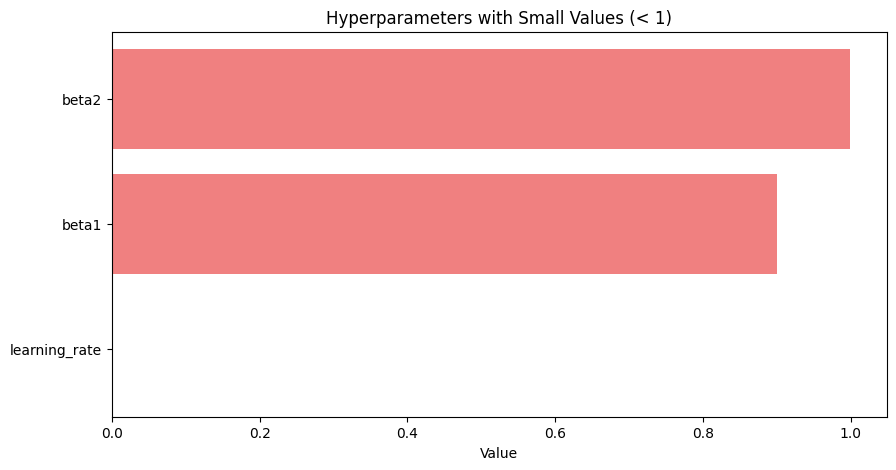

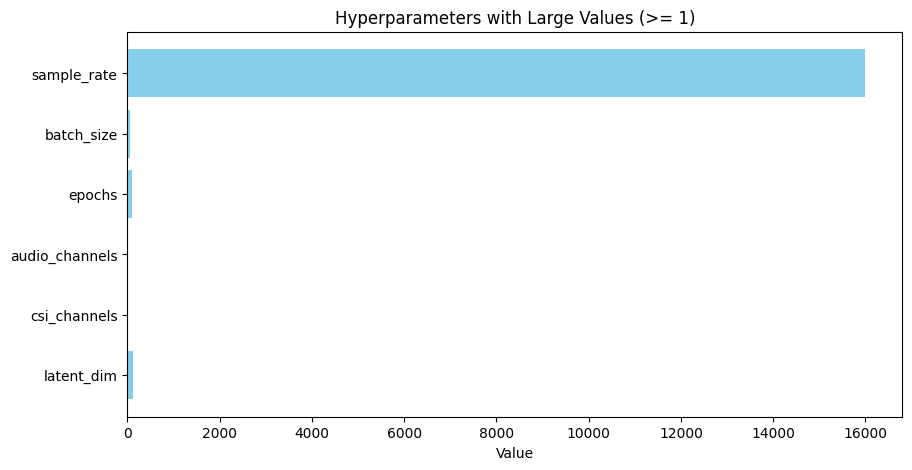

In [ ]:

# Hyperparameters
latent_dim = 128            # Increase latent dimension for richer representations
csi_channels = 1            # Keep as is (depends on input data)
audio_channels = 1          # Keep as is (depends on input data)
epochs = 100                # Reduce epochs to avoid overfitting (can be adjusted if data is sufficient)
batch_size = 64             # Increase batch size for more stable gradients
learning_rate = 0.0002      # Slightly increase learning rate for faster convergence
beta1 = 0.9                 # Update for improved stability of Adam optimizer
beta2 = 0.999               # Keep as is (default value for Adam optimizer)
sample_rate = 16000         # Keep as is (dependent on your audio data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visualize_hyperparameters(params):
    # Split the parameters into two categories: small values and large values
    small_values = {key: value for key, value in params.items() if value < 1}
    large_values = {key: value for key, value in params.items() if value >= 1}

    # Plot small values
    plt.figure(figsize=(10, 5))
    if small_values:
        names = list(small_values.keys())
        values = list(small_values.values())
        plt.barh(names, values, color="lightcoral")
        plt.xlabel("Value")
        plt.title("Hyperparameters with Small Values (< 1)")
        plt.show()

    # Plot large values
    plt.figure(figsize=(10, 5))
    if large_values:
        names = list(large_values.keys())
        values = list(large_values.values())
        plt.barh(names, values, color="skyblue")
        plt.xlabel("Value")
        plt.show()

# Complete hyperparameters dictionary
hyperparameters = {
    "latent_dim": latent_dim,
    "csi_channels": csi_channels,
    "audio_channels": audio_channels,
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "beta1": beta1,
    "beta2": beta2,
    "sample_rate": sample_rate
}

# Visualize hyperparameters
visualize_hyperparameters(hyperparameters)

# Dataset class
class CSIAudioDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        logging.debug(f"Processing index: {idx}")
        csi_path = self.data_df.iloc[idx]['csi_path']
        csi_data = pd.read_csv(csi_path)
        subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
        csi_data = csi_data[subcarrier_cols].values.T  # shape: (8, N)
        # Interpolate to 400 data points for each subcarrier
        target_len = 400
        csi_data_resampled = np.array([
            np.interp(
                np.linspace(0, len(channel) - 1, target_len),
                np.arange(len(channel)),
                channel
            ) for channel in csi_data
        ])
        csi_tensor = torch.tensor(csi_data_resampled, dtype=torch.float32)

        # Load audio data from CSV and interpolate
        audio_path = self.data_df.iloc[idx]['audio_path']
        audio_data = pd.read_csv(audio_path, header=None).values.flatten()
        audio_data_resampled = np.interp(
            np.linspace(0, len(audio_data) - 1, target_len),
            np.arange(len(audio_data)),
            audio_data
        )
        audio_tensor = torch.tensor(audio_data_resampled, dtype=torch.float32)

        # Trim tensors to the same length
        min_len = min(csi_tensor.shape[1], len(audio_tensor))
        if min_len == 0:
            logging.warning(f"No valid audio length for index: {idx}")
            return None

        csi_tensor_trimmed = csi_tensor[:, :min_len]
        audio_trimmed = audio_tensor[:min_len]
        return csi_tensor_trimmed, audio_trimmed
        


### Data Loading

In [6]:
# Load dataset
train_df = pd.read_csv("data_paths.csv")  # change this to actually load data ()
train_dataset = CSIAudioDataset(train_df)

# Filter out None values
train_loader = DataLoader(
    [data for data in train_dataset if data is not None],
    batch_size=batch_size,
    shuffle=True
)



### Generator Model

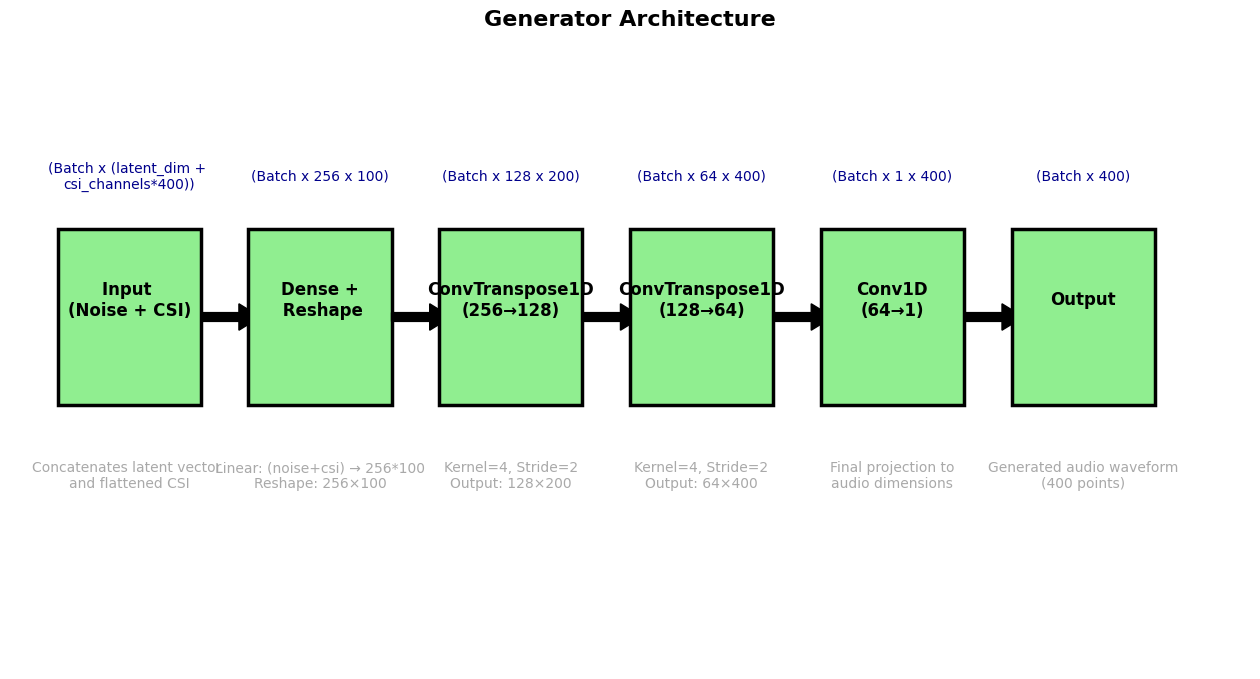

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim, csi_channels, audio_channels=1, csi_length=400):
        super(Generator, self).__init__()
        input_dim = latent_dim + csi_channels * csi_length  # Total input dimension after concatenation
        self.fc = nn.Linear(input_dim, 256 * 100)  # Project to 256 channels with 100 time steps

        self.conv1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(64, audio_channels, kernel_size=1)  # Final projection to audio

    def forward(self, z, csi_data):
        # Flatten CSI data
        csi_flat = csi_data.view(csi_data.size(0), -1)
        
        # Concatenate latent vector and flattened CSI data
        x = torch.cat([z, csi_flat], dim=1)
        
        # Project to the correct shape for transposed convolutions
        x = self.fc(x).view(-1, 256, 100)  # Reshape to (batch_size, channels, time_steps)
        
        # Apply transposed convolutions
        x = F.relu(self.conv1(x))  # Output: (batch_size, 128, 200)
        x = F.relu(self.conv2(x))  # Output: (batch_size, 64, 400)
        x = self.conv3(x)          # Output: (batch_size, 1, 400)
        
        return torch.sigmoid(x.view(-1, 400))  # Reshape to (batch_size, 400)

def visualize_generator_architecture():
    fig, ax = plt.subplots(figsize=(16, 8))

    # Updated layers for corrected generator
    layers = [
        {"name": "Input \n(Noise + CSI)", "desc": "Concatenates latent vector \nand flattened CSI", "pos": (0, 0), "size": (3, 2)},
        {"name": "Dense +\n Reshape", "desc": "Linear: (noise+csi) → 256*100\nReshape: 256×100", "pos": (4, 0), "size": (3, 2)},
        {"name": "ConvTranspose1D\n(256→128)", "desc": "Kernel=4, Stride=2\nOutput: 128×200", "pos": (8, 0), "size": (3, 2)},
        {"name": "ConvTranspose1D\n(128→64)", "desc": "Kernel=4, Stride=2\nOutput: 64×400", "pos": (12, 0), "size": (3, 2)},
        {"name": "Conv1D\n(64→1)", "desc": "Final projection to\naudio dimensions", "pos": (16, 0), "size": (3, 2)},
        {"name": "Output", "desc": "Generated audio waveform\n(400 points)", "pos": (20, 0), "size": (3, 2)}
    ]
    
    # Updated data shapes
    data_shapes = [
        "(Batch x (latent_dim + \ncsi_channels*400))",
        "(Batch x 256 x 100)",
        "(Batch x 128 x 200)",
        "(Batch x 64 x 400)",
        "(Batch x 1 x 400)",
        "(Batch x 400)"
    ]
    
    # Draw layers and arrows
    for i, layer in enumerate(layers):
        # Draw the layer block
        rect = Rectangle(layer["pos"], *layer["size"], edgecolor="black", facecolor="lightgreen", linewidth=2.5)
        ax.add_patch(rect)
        
        # Layer name
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] + layer["size"][1] / 2 + 0.2,
            layer["name"],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            fontweight="bold"
        )
        
        # Layer description
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] - 0.8,
            layer["desc"],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=10,
            color="darkgray"
        )
        
        # Data shape
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] + layer["size"][1] + 0.6,
            data_shapes[i],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=10,
            color="darkblue"
        )
        
        # Draw arrow to the next layer
        if i < len(layers) - 1:
            start_x = layer["pos"][0] + layer["size"][0]
            start_y = layer["pos"][1] + layer["size"][1] / 2
            end_x = layers[i + 1]["pos"][0]
            end_y = layers[i + 1]["pos"][1] + layers[i + 1]["size"][1] / 2
            arrow = FancyArrow(start_x, start_y, end_x - start_x - 0.2, end_y - start_y, width=0.1, color="black")
            ax.add_patch(arrow)

    # Adjust axes
    ax.set_xlim(-1, 25)
    ax.set_ylim(-3, 4)
    ax.axis("off")
    ax.set_title("Generator Architecture", fontsize=16, fontweight="bold", pad=20)
    plt.show()

visualize_generator_architecture()



### Discriminator Model

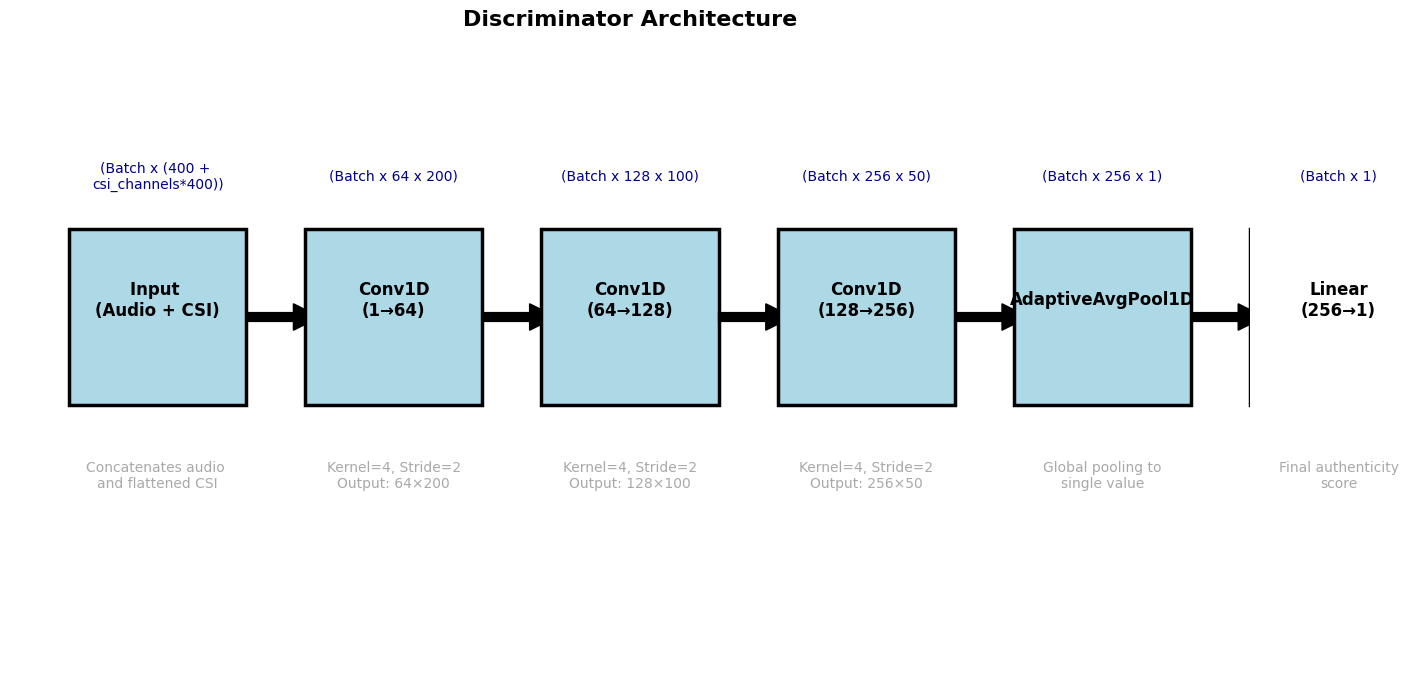

In [8]:
class Discriminator(nn.Module):
    def __init__(self, csi_channels):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 1)
    
    def forward(self, audio, csi):
        csi_flat = csi.view(csi.size(0), -1)
        x = torch.cat([audio, csi_flat], dim=1).unsqueeze(1)  # [batch, 1, L]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)  # [batch, 256]
        return torch.sigmoid(self.fc(x))  # [batch, 1]


def visualize_discriminator_architecture():
    fig, ax = plt.subplots(figsize=(16, 8))

    # Updated layers for corrected discriminator
    layers = [
        {"name": "Input \n(Audio + CSI)", "desc": "Concatenates audio \nand flattened CSI", "pos": (0, 0), "size": (3, 2)},
        {"name": "Conv1D\n(1→64)", "desc": "Kernel=4, Stride=2\nOutput: 64×200", "pos": (4, 0), "size": (3, 2)},
        {"name": "Conv1D\n(64→128)", "desc": "Kernel=4, Stride=2\nOutput: 128×100", "pos": (8, 0), "size": (3, 2)},
        {"name": "Conv1D\n(128→256)", "desc": "Kernel=4, Stride=2\nOutput: 256×50", "pos": (12, 0), "size": (3, 2)},
        {"name": "AdaptiveAvgPool1D", "desc": "Global pooling to\nsingle value", "pos": (16, 0), "size": (3, 2)},
        {"name": "Linear\n(256→1)", "desc": "Final authenticity\nscore", "pos": (20, 0), "size": (3, 2)}
    ]
    
    # Updated data shapes
    data_shapes = [
        "(Batch x (400 + \ncsi_channels*400))",
        "(Batch x 64 x 200)",
        "(Batch x 128 x 100)",
        "(Batch x 256 x 50)",
        "(Batch x 256 x 1)",
        "(Batch x 1)"
    ]

    
    # Draw layers and arrows
    for i, layer in enumerate(layers):
        # Draw the layer block
        rect = Rectangle(layer["pos"], *layer["size"], edgecolor="black", facecolor="lightblue", linewidth=2.5)
        ax.add_patch(rect)
        
        # Layer name
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] + layer["size"][1] / 2 + 0.2,
            layer["name"],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=12,
            fontweight="bold"
        )
        
        # Layer description
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] - 0.8,
            layer["desc"],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=10,
            color="darkgray"
        )
        
        # Data shape
        ax.text(
            layer["pos"][0] + layer["size"][0] / 2,
            layer["pos"][1] + layer["size"][1] + 0.6,
            data_shapes[i],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=10,
            color="darkblue"
        )
        
        # Draw arrow to the next layer
        if i < len(layers) - 1:
            start_x = layer["pos"][0] + layer["size"][0]
            start_y = layer["pos"][1] + layer["size"][1] / 2
            end_x = layers[i + 1]["pos"][0]
            end_y = layers[i + 1]["pos"][1] + layers[i + 1]["size"][1] / 2
            arrow = FancyArrow(start_x, start_y, end_x - start_x - 0.2, end_y - start_y, width=0.1, color="black")
            ax.add_patch(arrow)

    # Adjust axes
    ax.set_xlim(-1, 20)
    ax.set_ylim(-3, 4)
    ax.axis("off")
    ax.set_title("Discriminator Architecture", fontsize=16, fontweight="bold", pad=20)
    plt.show()

visualize_discriminator_architecture()



### Loss Functions

In [9]:
def generator_loss(d_output):
    return F.binary_cross_entropy(d_output, torch.ones_like(d_output))

def discriminator_loss(d_output_real, d_output_fake):
    real_loss = F.binary_cross_entropy(d_output_real, torch.ones_like(d_output_real))
    fake_loss = F.binary_cross_entropy(d_output_fake, torch.zeros_like(d_output_fake))
    return real_loss + fake_loss


### Initialize Models and Optimizers

In [10]:
generator = Generator(latent_dim, csi_channels).to(device)
discriminator = Discriminator(csi_channels).to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))


### Training Loop

In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import logging
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

class WindowedTrainer:
    def __init__(self, generator, discriminator, dataset, hyperparameters):
        """
        Initialize the windowed trainer.
        
        Args:
            generator: Generator model
            discriminator: Discriminator model
            dataset: CSIAudioDataset instance
            hyperparameters: Dictionary containing training hyperparameters
        """
        self.generator = generator.to(hyperparameters['device'])
        self.discriminator = discriminator.to(hyperparameters['device'])
        self.dataset = dataset
        self.hyperparameters = hyperparameters
        
        # Initialize optimizers
        self.optimizer_g = torch.optim.Adam(
            self.generator.parameters(),
            lr=hyperparameters['learning_rate'],
            betas=(hyperparameters['beta1'], hyperparameters['beta2'])
        )
        self.optimizer_d = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=hyperparameters['learning_rate'],
            betas=(hyperparameters['beta1'], hyperparameters['beta2'])
        )
        
        # Initialize data loader with collate function to handle None values
        self.train_loader = DataLoader(
            dataset,
            batch_size=hyperparameters['batch_size'],
            shuffle=True,
            drop_last=True,
            collate_fn=self.collate_fn
        )
        
        # Initialize lists for tracking losses
        self.d_losses = []
        self.g_losses = []
        
    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to handle None values and create proper batches.
        """
        # Filter out None values
        batch = [b for b in batch if b is not None]
        if len(batch) == 0:
            return None
        
        # Separate CSI and audio data
        csi_data = [item[0] for item in batch]
        audio_data = [item[1] for item in batch]
        
        # Stack the tensors
        csi_batch = torch.stack(csi_data)
        audio_batch = torch.stack(audio_data)
        
        return csi_batch, audio_batch
    
    def create_windows(self, data, window_size, stride):
        """
        Create windows from a batch of data.
        
        Args:
            data: Tensor of shape (batch_size, channels/features, sequence_length)
            window_size: Number of time steps in each window
            stride: Number of time steps to move between windows
            
        Returns:
            List of windows, each of shape (batch_size, channels/features, window_size)
        """
        windows = []
        # Handle the case where data is 2D (batch_size, sequence_length)
        if len(data.shape) == 2:
            data = data.unsqueeze(1)  # Add channel dimension
            
        for i in range(0, data.shape[2] - window_size + 1, stride):
            window = data[:, :, i:i + window_size]
            windows.append(window)
        return windows
    
    def train_epoch(self, epoch):
        """
        Train for one epoch using windowed data.
        """
        running_d_loss = 0.0
        running_g_loss = 0.0
        total_windows = 0
        
        # Window parameters
        window_size = 64  # Adjust based on your needs
        stride = 32      # 50% overlap
        
        for batch_idx, batch_data in enumerate(tqdm(self.train_loader, desc=f"Epoch {epoch + 1}")):
            # Skip empty batches
            if batch_data is None:
                continue
                
            csi_data, audio_data = batch_data
            
            # Move data to device
            csi_data = csi_data.to(self.hyperparameters['device'])  # Shape: (batch_size, 8, sequence_length)
            audio_data = audio_data.to(self.hyperparameters['device'])  # Shape: (batch_size, sequence_length)
            
            # Create windows
            csi_windows = self.create_windows(csi_data, window_size, stride)
            audio_windows = self.create_windows(audio_data, window_size, stride)
            
            # Update total windows count
            total_windows += len(csi_windows)
            
            # Train on each window
            for csi_window, audio_window in zip(csi_windows, audio_windows):
                # Ensure proper shapes
                if len(audio_window.shape) == 2:  # (batch_size, window_size)
                    audio_window = audio_window.unsqueeze(1)  # Add channel dimension
                
                # Train discriminator
                self.optimizer_d.zero_grad()
                
                # Generate fake audio
                z = torch.randn(
                    csi_window.size(0),
                    self.hyperparameters['latent_dim'],
                    device=self.hyperparameters['device']
                )
                fake_audio = self.generator(z, csi_window)
                
                # Real and fake discriminator outputs
                d_real = self.discriminator(audio_window, csi_window)
                d_fake = self.discriminator(fake_audio.detach(), csi_window)
                
                # Discriminator loss (WGAN-GP style)
                d_loss_real = -torch.mean(d_real)
                d_loss_fake = torch.mean(d_fake)
                d_loss = d_loss_real + d_loss_fake
                
                # Add gradient penalty
                gp = self.gradient_penalty(audio_window, fake_audio.detach(), csi_window)
                d_loss += 10.0 * gp
                
                d_loss.backward()
                self.optimizer_d.step()
                
                # Train generator
                self.optimizer_g.zero_grad()
                
                # Generate fake audio again
                fake_audio = self.generator(z, csi_window)
                d_fake = self.discriminator(fake_audio, csi_window)
                
                # Generator loss
                g_loss = -torch.mean(d_fake)
                
                g_loss.backward()
                self.optimizer_g.step()
                
                # Update running losses
                running_d_loss += d_loss.item()
                running_g_loss += g_loss.item()
        
        # Calculate average losses for this epoch
        avg_d_loss = running_d_loss / total_windows if total_windows > 0 else float('inf')
        avg_g_loss = running_g_loss / total_windows if total_windows > 0 else float('inf')
        
        self.d_losses.append(avg_d_loss)
        self.g_losses.append(avg_g_loss)
        
        return avg_d_loss, avg_g_loss
    
    def gradient_penalty(self, real_data, fake_data, condition):
        """
        Calculate gradient penalty for WGAN-GP.
        """
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, 1).to(self.hyperparameters['device'])
        alpha = alpha.expand_as(real_data)
        
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)
        
        d_interpolated = self.discriminator(interpolated, condition)
        
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True,
            retain_graph=True
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()
        
        return gradient_penalty
    
    def train(self):
        """
        Complete training loop for all epochs.
        """
        for epoch in range(self.hyperparameters['epochs']):
            d_loss, g_loss = self.train_epoch(epoch)
            
            # Log progress
            logging.info(
                f"Epoch [{epoch + 1}/{self.hyperparameters['epochs']}] "
                f"D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}"
            )
            
        
        # Plot training progress
        self.plot_training_progress()
    
    def plot_training_progress(self):
        """
        Plot the training losses.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label='Discriminator Loss', color='red')
        plt.plot(self.g_losses, label='Generator Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_progress.png')
        plt.close()

def main():
    # Your hyperparameters are already defined
    hyperparameters = {
        "latent_dim": latent_dim,
        "csi_channels": csi_channels,
        "audio_channels": audio_channels,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "beta1": beta1,
        "beta2": beta2,
        "sample_rate": sample_rate,
        "device": device
    }
    
    # Create your dataset
    dataset = CSIAudioDataset(train_dataset)
    
    # Initialize your models
    generator = Generator(latent_dim, csi_channels).to(device)
    discriminator = Discriminator(csi_channels).to(device)
    
    # Initialize trainer
    trainer = WindowedTrainer(generator, discriminator, dataset, hyperparameters)
    
    # Start training
    trainer.train()

if __name__ == "__main__":
    main()

Epoch 1: 0it [00:00, ?it/s]
Epoch 2: 0it [00:00, ?it/s]
Epoch 3: 0it [00:00, ?it/s]
Epoch 4: 0it [00:00, ?it/s]
Epoch 5: 0it [00:00, ?it/s]
Epoch 6: 0it [00:00, ?it/s]
Epoch 7: 0it [00:00, ?it/s]
Epoch 8: 0it [00:00, ?it/s]
Epoch 9: 0it [00:00, ?it/s]
Epoch 10: 0it [00:00, ?it/s]
Epoch 11: 0it [00:00, ?it/s]
Epoch 12: 0it [00:00, ?it/s]
Epoch 13: 0it [00:00, ?it/s]
Epoch 14: 0it [00:00, ?it/s]
Epoch 15: 0it [00:00, ?it/s]
Epoch 16: 0it [00:00, ?it/s]
Epoch 17: 0it [00:00, ?it/s]
Epoch 18: 0it [00:00, ?it/s]
Epoch 19: 0it [00:00, ?it/s]
Epoch 20: 0it [00:00, ?it/s]
Epoch 21: 0it [00:00, ?it/s]
Epoch 22: 0it [00:00, ?it/s]
Epoch 23: 0it [00:00, ?it/s]
Epoch 24: 0it [00:00, ?it/s]
Epoch 25: 0it [00:00, ?it/s]
Epoch 26: 0it [00:00, ?it/s]
Epoch 27: 0it [00:00, ?it/s]
Epoch 28: 0it [00:00, ?it/s]
Epoch 29: 0it [00:00, ?it/s]
Epoch 30: 0it [00:00, ?it/s]
Epoch 31: 0it [00:00, ?it/s]
Epoch 32: 0it [00:00, ?it/s]
Epoch 33: 0it [00:00, ?it/s]
Epoch 34: 0it [00:00, ?it/s]
Epoch 35: 0it [00:00, ?

### Save Models

In [12]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

### Full code in one

In [13]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow, Rectangle
import logging

# Hyperparameters
latent_dim = 128
csi_channels = 8  # Updated to match 8 subcarriers from dataset
audio_channels = 1
epochs = 100
batch_size = 64
learning_rate = 0.0002
beta1 = 0.9
beta2 = 0.999
sample_rate = 16000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset class (unchanged)
class CSIAudioDataset(Dataset):
    def __init__(self, data_df):
        self.data_df = data_df

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        logging.debug(f"Processing index: {idx}")
        csi_path = self.data_df.iloc[idx]['csi_path']
        csi_data = pd.read_csv(csi_path)
        subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
        csi_data = csi_data[subcarrier_cols].values.T  # Shape: (8, N)
        target_len = 400
        csi_data_resampled = np.array([
            np.interp(
                np.linspace(0, len(channel) - 1, target_len),
                np.arange(len(channel)),
                channel
            ) for channel in csi_data
        ])
        csi_tensor = torch.tensor(csi_data_resampled, dtype=torch.float32)

        audio_path = self.data_df.iloc[idx]['audio_path']
        audio_data = pd.read_csv(audio_path, header=None).values.flatten()
        audio_data_resampled = np.interp(
            np.linspace(0, len(audio_data) - 1, target_len),
            np.arange(len(audio_data)),
            audio_data
        )
        audio_tensor = torch.tensor(audio_data_resampled, dtype=torch.float32)

        min_len = min(csi_tensor.shape[1], len(audio_tensor))
        if min_len == 0:
            logging.warning(f"No valid audio length for index: {idx}")
            return None

        csi_tensor_trimmed = csi_tensor[:, :min_len]
        audio_trimmed = audio_tensor[:min_len]
        return csi_tensor_trimmed, audio_trimmed

# Fixed Generator class
class Generator(nn.Module):
    def __init__(self, latent_dim, csi_channels, audio_channels=1, csi_length=64):
        super(Generator, self).__init__()
        self.csi_length = csi_length  # Store csi_length as an attribute
        input_dim = latent_dim + csi_channels * csi_length
        T = csi_length // 4  # Adjusted for two ConvTranspose1d with stride=2
        self.fc = nn.Linear(input_dim, 256 * T)

        self.conv1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(64, audio_channels, kernel_size=1)

    def forward(self, z, csi_data):
        csi_flat = csi_data.view(csi_data.size(0), -1)
        x = torch.cat([z, csi_flat], dim=1)
        T = self.csi_length // 4
        x = self.fc(x).view(-1, 256, T)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x.view(-1, self.csi_length))  # Dynamic reshaping

# Discriminator class (unchanged)
class Discriminator(nn.Module):
    def __init__(self, csi_channels):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, 1)
    
    def forward(self, audio, csi):
        csi_flat = csi.view(csi.size(0), -1)
        x = torch.cat([audio, csi_flat], dim=1).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)
        return torch.sigmoid(self.fc(x))

# WindowedTrainer class (unchanged)
class WindowedTrainer:
    def __init__(self, generator, discriminator, dataset, hyperparameters):
        self.generator = generator.to(hyperparameters['device'])
        self.discriminator = discriminator.to(hyperparameters['device'])
        self.dataset = dataset
        self.hyperparameters = hyperparameters
        
        self.optimizer_g = torch.optim.Adam(
            self.generator.parameters(),
            lr=hyperparameters['learning_rate'],
            betas=(hyperparameters['beta1'], hyperparameters['beta2'])
        )
        self.optimizer_d = torch.optim.Adam(
            self.discriminator.parameters(),
            lr=hyperparameters['learning_rate'],
            betas=(hyperparameters['beta1'], hyperparameters['beta2'])
        )
        
        self.train_loader = DataLoader(
            dataset,
            batch_size=hyperparameters['batch_size'],
            shuffle=True,
            drop_last=True,
            collate_fn=self.collate_fn
        )
        
        self.d_losses = []
        self.g_losses = []
        
    @staticmethod
    def collate_fn(batch):
        batch = [b for b in batch if b is not None]
        if len(batch) == 0:
            return None
        csi_data = [item[0] for item in batch]
        audio_data = [item[1] for item in batch]
        csi_batch = torch.stack(csi_data)
        audio_batch = torch.stack(audio_data)
        return csi_batch, audio_batch
    
    def create_windows(self, data, window_size, stride):
        windows = []
        if len(data.shape) == 2:
            data = data.unsqueeze(1)
        for i in range(0, data.shape[2] - window_size + 1, stride):
            window = data[:, :, i:i + window_size]
            windows.append(window)
        return windows
    
    def train_epoch(self, epoch):
        running_d_loss = 0.0
        running_g_loss = 0.0
        total_windows = 0
        window_size = 64
        stride = 32
        
        for batch_idx, batch_data in enumerate(tqdm(self.train_loader, desc=f"Epoch {epoch + 1}")):
            if batch_data is None:
                continue
            csi_data, audio_data = batch_data
            csi_data = csi_data.to(self.hyperparameters['device'])
            audio_data = audio_data.to(self.hyperparameters['device'])
            csi_windows = self.create_windows(csi_data, window_size, stride)
            audio_windows = self.create_windows(audio_data, window_size, stride)
            total_windows += len(csi_windows)
            for csi_window, audio_window in zip(csi_windows, audio_windows):
                if len(audio_window.shape) == 2:
                    audio_window = audio_window.unsqueeze(1)
                self.optimizer_d.zero_grad()
                z = torch.randn(
                    csi_window.size(0),
                    self.hyperparameters['latent_dim'],
                    device=self.hyperparameters['device']
                )
                fake_audio = self.generator(z, csi_window)
                d_real = self.discriminator(audio_window.squeeze(1), csi_window)
                d_fake = self.discriminator(fake_audio.detach(), csi_window)
                d_loss_real = -torch.mean(d_real)
                d_loss_fake = torch.mean(d_fake)
                d_loss = d_loss_real + d_loss_fake
                gp = self.gradient_penalty(audio_window.squeeze(1), fake_audio.detach(), csi_window)
                d_loss += 10.0 * gp
                d_loss.backward()
                self.optimizer_d.step()
                self.optimizer_g.zero_grad()
                fake_audio = self.generator(z, csi_window)
                d_fake = self.discriminator(fake_audio, csi_window)
                g_loss = -torch.mean(d_fake)
                g_loss.backward()
                self.optimizer_g.step()
                running_d_loss += d_loss.item()
                running_g_loss += g_loss.item()
        avg_d_loss = running_d_loss / total_windows if total_windows > 0 else float('inf')
        avg_g_loss = running_g_loss / total_windows if total_windows > 0 else float('inf')
        self.d_losses.append(avg_d_loss)
        self.g_losses.append(avg_g_loss)
        return avg_d_loss, avg_g_loss
    
    def gradient_penalty(self, real_data, fake_data, condition):
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1).to(self.hyperparameters['device'])
        alpha = alpha.expand_as(real_data)
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)
        d_interpolated = self.discriminator(interpolated, condition)
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True,
            retain_graph=True
        )[0]
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradient_norm - 1) ** 2).mean()
        return gradient_penalty
    
    def train(self):
        for epoch in range(self.hyperparameters['epochs']):
            d_loss, g_loss = self.train_epoch(epoch)
            logging.info(
                f"Epoch [{epoch + 1}/{self.hyperparameters['epochs']}] "
                f"D_loss: {d_loss:.4f}, G_loss: {g_loss:.4f}"
            )
        self.plot_training_progress()
    
    def plot_training_progress(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label='Discriminator Loss', color='red')
        plt.plot(self.g_losses, label='Generator Loss', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_progress.png')
        plt.close()

# Updated main function
def main():
    hyperparameters = {
        "latent_dim": latent_dim,
        "csi_channels": csi_channels,
        "audio_channels": audio_channels,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "beta1": beta1,
        "beta2": beta2,
        "sample_rate": sample_rate,
        "device": device
    }
    train_df = pd.read_csv("data_paths.csv")  # Ensure this file exists
    dataset = CSIAudioDataset(train_df)
    generator = Generator(latent_dim, csi_channels, csi_length=64).to(device)  # Set csi_length=64
    discriminator = Discriminator(csi_channels).to(device)
    trainer = WindowedTrainer(generator, discriminator, dataset, hyperparameters)
    trainer.train()

if __name__ == "__main__":
    main()

Epoch 1: 0it [00:00, ?it/s]
Epoch 2: 0it [00:00, ?it/s]
Epoch 3: 0it [00:00, ?it/s]
Epoch 4: 0it [00:00, ?it/s]
Epoch 5: 0it [00:00, ?it/s]
Epoch 6: 0it [00:00, ?it/s]
Epoch 7: 0it [00:00, ?it/s]
Epoch 8: 0it [00:00, ?it/s]
Epoch 9: 0it [00:00, ?it/s]
Epoch 10: 0it [00:00, ?it/s]
Epoch 11: 0it [00:00, ?it/s]
Epoch 12: 0it [00:00, ?it/s]
Epoch 13: 0it [00:00, ?it/s]
Epoch 14: 0it [00:00, ?it/s]
Epoch 15: 0it [00:00, ?it/s]
Epoch 16: 0it [00:00, ?it/s]
Epoch 17: 0it [00:00, ?it/s]
Epoch 18: 0it [00:00, ?it/s]
Epoch 19: 0it [00:00, ?it/s]
Epoch 20: 0it [00:00, ?it/s]
Epoch 21: 0it [00:00, ?it/s]
Epoch 22: 0it [00:00, ?it/s]
Epoch 23: 0it [00:00, ?it/s]
Epoch 24: 0it [00:00, ?it/s]
Epoch 25: 0it [00:00, ?it/s]
Epoch 26: 0it [00:00, ?it/s]
Epoch 27: 0it [00:00, ?it/s]
Epoch 28: 0it [00:00, ?it/s]
Epoch 29: 0it [00:00, ?it/s]
Epoch 30: 0it [00:00, ?it/s]
Epoch 31: 0it [00:00, ?it/s]
Epoch 32: 0it [00:00, ?it/s]
Epoch 33: 0it [00:00, ?it/s]
Epoch 34: 0it [00:00, ?it/s]
Epoch 35: 0it [00:00, ?

### Generating

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import soundfile as sf

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correct Generator definition (MUST MATCH TRAINED ARCHITECTURE)
class Generator(nn.Module):
    def __init__(self, latent_dim=128, csi_channels=8, audio_channels=1, csi_length=400):
        super(Generator, self).__init__()
        input_dim = latent_dim + csi_channels * csi_length
        self.fc = nn.Linear(input_dim, 256 * 100)
        self.conv1 = nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv1d(64, audio_channels, kernel_size=1)

    def forward(self, z, csi_data):
        csi_flat = csi_data.view(csi_data.size(0), -1)
        x = torch.cat([z, csi_flat], dim=1)
        x = self.fc(x).view(-1, 256, 100)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x.view(-1, 400))

# Model parameters (MUST MATCH TRAINING PARAMETERS)
latent_dim = 128
csi_channels = 8
csi_length = 400

# Initialize and load generator
generator = Generator(latent_dim=latent_dim, csi_channels=csi_channels)
generator.load_state_dict(
    torch.load('generator.pth', 
              map_location=device, 
              weights_only=True)
)
generator.to(device)

# Process CSI data (top 8 subcarriers)
csi_data_path = 'data_capture/csi/8_csi_filtered/top8_filtered_csi_data_2024-08-17_23-16-37.224.csv'  # <-- update filename as needed
raw_csi_df = pd.read_csv(csi_data_path)
subcarrier_cols = [col for col in raw_csi_df.columns if col.startswith('subcarrier_')]
raw_csi = raw_csi_df[subcarrier_cols].values.T  # shape: (8, N)

# Interpolate each subcarrier to 400 points
target_len = 400
processed_csi = np.array([
    np.interp(
        np.linspace(0, len(channel) - 1, target_len),
        np.arange(len(channel)),
        channel
    ) for channel in raw_csi
])  # shape: (8, 400)

# Create CSI tensor
sample_csi = torch.tensor(processed_csi, dtype=torch.float32)
sample_csi = sample_csi.view(1, csi_channels, csi_length).to(device)

# Verify dimensions
if sample_csi.shape != (1, csi_channels, csi_length):
    raise ValueError(f"CSI tensor shape mismatch: {sample_csi.shape}")

# Function to generate synthetic audio
def generate_synthetic_audio(generator, latent_dim, csi_data_sample, num_samples, 
                            output_dir, target_length=1600, sample_rate=16000):
    generator.eval()
    os.makedirs(output_dir, exist_ok=True)

    for i in range(num_samples):
        z = torch.randn(1, latent_dim).to(device)
        with torch.no_grad():
            generated_audio = generator(z, csi_data_sample)
        
        audio_400 = generated_audio.squeeze().cpu().numpy()
        x_original = np.linspace(0, 1, len(audio_400))
        x_target = np.linspace(0, 1, target_length)
        audio_interpolated = np.interp(x_target, x_original, audio_400)
        audio_interpolated = np.clip(audio_interpolated * 2 - 1, -1.0, 1.0)

        output_path = os.path.join(output_dir, f"generated_audio_{i+1}_{target_length}pts.wav")
        sf.write(output_path, audio_interpolated, sample_rate)
        print(f"Generated {target_length}-point audio at: {output_path}")

# Generate audio samples
generate_synthetic_audio(
    generator=generator,
    latent_dim=latent_dim,
    csi_data_sample=sample_csi,
    num_samples=2,
    output_dir="generated_audio",
    target_length=32000
)

RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for fc.weight: copying a param with shape torch.Size([25600, 528]) from checkpoint, the shape in current model is torch.Size([25600, 3328]).

## Complete Code - 30 july


In [ ]:
# complete_enhanced_csi_training_optimized.py

import os
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
import numpy as np
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
import soundfile as sf
from sklearn.model_selection import train_test_split
from scipy import signal
import librosa
import librosa.display
import random
# OPTIMIZATION: Import autocast and GradScaler for mixed-precision training
from torch.cuda.amp import autocast, GradScaler

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ============================================================================
# ENHANCED CONFIGURATION WITH CSI PREPROCESSING
# ============================================================================

# Directories
CSI_DIRECTORY = "data/csi"
AUDIO_DIRECTORY = "data/audio"
OUTPUT_DIRECTORY = "output"

os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

# Enhanced Hyperparameters with CSI preprocessing
HYPERPARAMETERS = {
    "latent_dim": 64,
    "csi_channels": 8,
    "audio_channels": 1,
    "epochs": 300,
    "batch_size": 8,
    
    # Learning rates
    "lr_generator": 0.0001,
    "lr_discriminator": 0.00005,
    "lr_scheduler_gamma": 0.98,

    "beta1": 0.5,
    "beta2": 0.999,
    "sample_rate": None,
    "audio_duration": 10.0,
    "sequence_length": None,
    
    # CSI and audio parameters
    "chunk_size": 2048,
    "overlap": 1024,
    "max_chunks_per_sample": 12,

    # Enhanced loss weights
    "lambda_reconstruction": 15.0,
    "lambda_feature_matching": 3.0,
    "lambda_gradient_penalty": 8.0,
    "lambda_spectral": 2.0,
    "lambda_drum_loss": 5.0,

    # Training parameters
    "n_critic": 3,
    "warmup_epochs": 15,

    # Data split parameters
    "train_test_split": 0.85,
    "random_seed": 42,

    # Enhanced audio preprocessing parameters
    "enable_noise_reduction": True,
    "preserve_drums": True,
    "noise_gate_threshold": -40,
    "drum_freq_range": [40, 300],
    "cymbal_freq_range": [1000, 12000],
    "kick_freq_range": [30, 120],
    "snare_freq_range": [120, 400],
    "spectral_subtraction_alpha": 2.0,
    "wiener_filter_enabled": True,
    "drum_enhancement_factor": 2.5,
    
    # Data augmentation parameters
    "enable_augmentation": True,
    "pitch_shift_range": 0.1,
    "time_stretch_range": 0.05,
    "noise_injection_prob": 0.3,
    "noise_injection_level": 0.01,
    
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ============================================================================
# ENHANCED CSI PREPROCESSOR WITH ALL TECHNIQUES
# ============================================================================

class EnhancedCSIPreprocessor:
    """Enhanced CSI preprocessor with Butterworth filtering, Hampel filtering, and phase sanitization"""
    
    def __init__(self, sample_rate, csi_sample_rate=1000):
        self.sample_rate = sample_rate
        self.csi_sample_rate = csi_sample_rate
        self.nyquist = csi_sample_rate // 2
        
        # Initialize Butterworth low-pass filter
        self._init_butterworth_filter()
        
        logging.info(f"Enhanced CSI preprocessor initialized with Butterworth and Hampel filtering")
        
    def _init_butterworth_filter(self):
        """Initialize Butterworth low-pass filter"""
        try:
            cutoff_freq = 50  # Hz
            order = 4
            
            if cutoff_freq < self.nyquist:
                self.butterworth_sos = signal.butter(
                    order, cutoff_freq, btype='low', 
                    fs=self.csi_sample_rate, output='sos'
                )
                logging.info(f"Butterworth filter initialized: {order}th order, {cutoff_freq}Hz cutoff")
            else:
                logging.warning(f"Cutoff frequency {cutoff_freq}Hz exceeds Nyquist {self.nyquist}Hz")
                self.butterworth_sos = None
                
        except Exception as e:
            logging.warning(f"Butterworth filter initialization failed: {e}")
            self.butterworth_sos = None
    
    def apply_butterworth_filter(self, csi_signal):
        """Apply Butterworth low-pass filter to remove high-frequency noise"""
        try:
            if self.butterworth_sos is not None and len(csi_signal) > 10:
                filtered_signal = signal.sosfilt(self.butterworth_sos, csi_signal)
                return filtered_signal.astype(np.float32)
            else:
                return csi_signal
                
        except Exception as e:
            logging.warning(f"Butterworth filtering failed: {e}")
            return csi_signal
    
    # OPTIMIZATION: Vectorized Hampel filter
    def apply_hampel_filter(self, csi_signal, window_size=7, n_sigmas=3):
        """Apply Hampel filter to eliminate sporadic outliers in CSI amplitude streams (Vectorized)"""
        if len(csi_signal) < window_size:
            return csi_signal
            
        is_complex = np.iscomplexobj(csi_signal)
        amplitude = np.abs(csi_signal)
        
        k = 1.4826 # scale factor for Gaussian distribution
        rolling_median = pd.Series(amplitude).rolling(window_size, center=True).median().to_numpy()
        
        # Pad the edges for MAD calculation
        rolling_median_padded = np.pad(rolling_median, (window_size//2), mode='edge')
        mad_series = pd.Series(np.abs(amplitude - rolling_median_padded[window_size//2:-window_size//2])).rolling(window_size, center=True).median().to_numpy()
        
        # Fill NaN values at the boundaries
        rolling_median[np.isnan(rolling_median)] = np.median(amplitude)
        mad_series[np.isnan(mad_series)] = np.median(np.abs(amplitude - np.median(amplitude)))
        
        threshold = n_sigmas * k * mad_series
        outlier_indices = np.abs(amplitude - rolling_median) > threshold
        
        filtered_amplitude = amplitude.copy()
        filtered_amplitude[outlier_indices] = rolling_median[outlier_indices]
        
        if is_complex:
            phase = np.angle(csi_signal)
            return (filtered_amplitude * np.exp(1j * phase)).astype(np.complex64)
        else:
            return filtered_amplitude.astype(np.float32)

    def phase_sanitization(self, csi_complex):
        """Correct for random phase offsets using linear transformation"""
        try:
            if not np.iscomplexobj(csi_complex):
                logging.warning("Phase sanitization requires complex CSI data")
                return csi_complex
            
            raw_phase = np.angle(csi_complex)
            unwrapped_phase = np.unwrap(raw_phase)
            
            time_indices = np.arange(len(unwrapped_phase))
            
            if len(time_indices) > 1:
                coeffs = np.polyfit(time_indices, unwrapped_phase, 1)
                linear_trend = np.polyval(coeffs, time_indices)
                
                detrended_phase = unwrapped_phase - linear_trend
                
                amplitude = np.abs(csi_complex)
                sanitized_csi = amplitude * np.exp(1j * detrended_phase)
                
                return sanitized_csi.astype(np.complex64)
            else:
                return csi_complex
                
        except Exception as e:
            logging.warning(f"Phase sanitization failed: {e}")
            return csi_complex
    
    def extract_motion_features(self, csi_windows):
        """Extract motion-sensitive features from cleaned CSI windows"""
        try:
            features_list = []
            
            for channel_idx in range(csi_windows.shape[0]):
                channel_data = csi_windows[channel_idx]
                channel_features = []
                
                energy_variations = np.abs(channel_data) ** 2
                channel_features.append(energy_variations)
                
                if np.iscomplexobj(channel_data):
                    phase = np.angle(channel_data)
                    unwrapped_phase = np.unwrap(phase)
                    phase_diff = np.diff(unwrapped_phase, prepend=unwrapped_phase[0])
                else:
                    analytic_signal = signal.hilbert(channel_data)
                    phase = np.angle(analytic_signal)
                    unwrapped_phase = np.unwrap(phase)
                    phase_diff = np.diff(unwrapped_phase, prepend=unwrapped_phase[0])
                
                channel_features.append(phase_diff)
                
                amplitude = np.abs(channel_data)
                amplitude_changes = np.diff(amplitude, prepend=amplitude[0])
                channel_features.append(amplitude_changes)
                
                amplitude_variance = self._compute_moving_variance(amplitude, window_size=32)
                channel_features.append(amplitude_variance)
                
                phase_variance = self._compute_moving_variance(unwrapped_phase, window_size=32)
                channel_features.append(phase_variance)
                
                channel_features_array = np.stack(channel_features, axis=0)
                features_list.append(channel_features_array)
            
            all_features = np.stack(features_list, axis=0)
            
            return all_features.astype(np.float32)
            
        except Exception as e:
            logging.warning(f"Motion feature extraction failed: {e}")
            fallback = np.expand_dims(csi_windows.real, axis=1)
            return fallback.astype(np.float32)
    
    # OPTIMIZATION: Vectorized moving variance
    def _compute_moving_variance(self, data, window_size=32):
        """Compute moving variance of a signal (Vectorized)"""
        if len(data) < window_size:
            return np.full_like(data, np.var(data))
        
        # Using pandas for a fast and robust rolling calculation
        rolling_var = pd.Series(data).rolling(window=window_size, center=True, min_periods=1).var().to_numpy()
        # Fill NaNs at the edges
        rolling_var[np.isnan(rolling_var)] = np.var(data)
        return rolling_var

    def process_csi_complete(self, raw_csi_data):
        """Complete CSI processing pipeline with all techniques"""
        try:
            processed_channels = []
            
            for channel_idx in range(raw_csi_data.shape[0]):
                channel_data = raw_csi_data[channel_idx]
                
                filtered_data = self.apply_butterworth_filter(channel_data)
                outlier_removed_data = self.apply_hampel_filter(filtered_data)
                
                if np.iscomplexobj(outlier_removed_data):
                    sanitized_data = self.phase_sanitization(outlier_removed_data)
                else:
                    sanitized_data = outlier_removed_data
                
                processed_channels.append(sanitized_data)
            
            processed_csi = np.stack(processed_channels, axis=0)
            
            motion_features = self.extract_motion_features(processed_csi)
            
            return motion_features
            
        except Exception as e:
            logging.error(f"Complete CSI processing failed: {e}")
            fallback = np.expand_dims(raw_csi_data.real, axis=1)
            return fallback.astype(np.float32)

# ... (The rest of the classes like EnhancedAudioPreprocessor, FixedDrumAudioAugmentor remain largely the same) ...

class EnhancedAudioPreprocessor:
    """Enhanced audio preprocessor integrated with CSI processing"""
    
    def __init__(self, sample_rate, preserve_drums=True, audio_duration=10.0):
        self.sample_rate = sample_rate
        self.preserve_drums = preserve_drums
        self.audio_duration = audio_duration
        self.nyquist = sample_rate // 2
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        # Initialize enhanced CSI preprocessor
        self.csi_preprocessor = EnhancedCSIPreprocessor(sample_rate)
        
        # Initialize drum filters
        self._init_drum_filters()
        
        logging.info(f"Enhanced audio preprocessor with CSI integration initialized")
        
    def _init_drum_filters(self):
        """Initialize drum-specific filters"""
        try:
            self.kick_sos = signal.butter(6, HYPERPARAMETERS['kick_freq_range'], 
                                           btype='band', fs=self.sample_rate, output='sos')
            self.snare_sos = signal.butter(6, HYPERPARAMETERS['snare_freq_range'], 
                                           btype='band', fs=self.sample_rate, output='sos')
            self.drum_sos = signal.butter(6, HYPERPARAMETERS['drum_freq_range'], 
                                          btype='band', fs=self.sample_rate, output='sos')
            self.cymbal_sos = signal.butter(6, HYPERPARAMETERS['cymbal_freq_range'], 
                                            btype='band', fs=self.sample_rate, output='sos')
        except Exception as e:
            logging.warning(f"Drum filter initialization failed: {e}")
    
    def detect_drum_beats_enhanced(self, audio):
        """Enhanced drum beat detection"""
        try:
            if len(audio) < 512:
                return np.array([]), np.zeros(len(audio))
            
            hop_length = 256
            
            if len(audio) < 1024:
                hop_length = 128
            elif len(audio) < 2048:
                hop_length = 256
            else:
                hop_length = 512
            
            onsets = librosa.onset.onset_detect(
                y=audio, sr=self.sample_rate, 
                hop_length=hop_length,
                backtrack=True,
                units='time',
                delta=0.1
            )
            
            onset_env = librosa.onset.onset_strength(
                y=audio, sr=self.sample_rate, 
                hop_length=hop_length,
                aggregate=np.median,
                fmax=min(8000, self.nyquist)
            )
            
            if len(onset_env) > 0:
                onset_times = librosa.frames_to_time(np.arange(len(onset_env)), 
                                                     sr=self.sample_rate, hop_length=hop_length)
                audio_times = np.linspace(0, len(audio)/self.sample_rate, len(audio))
                drum_strength = np.interp(audio_times, onset_times, onset_env)
                
                if np.max(drum_strength) > 0:
                    drum_strength = drum_strength / np.max(drum_strength)
            else:
                drum_strength = np.zeros(len(audio))
            
            return onsets, drum_strength
            
        except Exception as e:
            logging.warning(f"Enhanced drum detection failed: {e}")
            return np.array([]), np.zeros(len(audio))
    
    def process_audio_with_enhanced_csi(self, audio, raw_csi_data):
        """Process audio with enhanced CSI preprocessing"""
        try:
            processed_csi_features = self.csi_preprocessor.process_csi_complete(raw_csi_data)
            
            onsets, drum_strength = self.detect_drum_beats_enhanced(audio)
            
            processed_audio = self._enhance_audio_processing(audio, drum_strength, onsets)
            
            return processed_audio, processed_csi_features, drum_strength, onsets
            
        except Exception as e:
            logging.error(f"Enhanced audio-CSI processing failed: {e}")
            fallback_csi = np.expand_dims(raw_csi_data, axis=1).astype(np.float32)
            return audio, fallback_csi, np.zeros(len(audio)), np.array([])
    
    def _enhance_audio_processing(self, audio, drum_strength, onsets):
        """Enhanced audio processing with drum focus"""
        try:
            kick_component = signal.sosfilt(self.kick_sos, audio)
            snare_component = signal.sosfilt(self.snare_sos, audio)
            drum_component = signal.sosfilt(self.drum_sos, audio)
            cymbal_component = signal.sosfilt(self.cymbal_sos, audio)
            
            enhancement = 1.0 + drum_strength * (HYPERPARAMETERS['drum_enhancement_factor'] - 1.0)
            
            kick_enhanced = kick_component * enhancement * 1.8
            snare_enhanced = snare_component * enhancement * 1.6
            cymbal_enhanced = cymbal_component * enhancement * 1.2
            
            for onset_time in onsets:
                if onset_time * self.sample_rate >= len(audio):
                    continue
                    
                onset_sample = int(onset_time * self.sample_rate)
                if 0 <= onset_sample < len(audio):
                    window_size = min(int(0.05 * self.sample_rate), len(audio) - onset_sample)
                    start = max(0, onset_sample - window_size // 4)
                    end = min(len(audio), onset_sample + window_size)
                    
                    if end > start:
                        boost_factor = 1.5
                        kick_enhanced[start:end] *= boost_factor
                        snare_enhanced[start:end] *= boost_factor
            
            drums_enhanced = kick_enhanced + snare_enhanced + cymbal_enhanced
            
            mix_ratio = 0.7 + 0.2 * drum_strength
            final_audio = mix_ratio * drums_enhanced + (1 - mix_ratio) * drum_component
            
            if np.max(np.abs(final_audio)) > 0:
                final_audio = np.tanh(final_audio * 0.9) * 0.9
                current_rms = np.sqrt(np.mean(final_audio ** 2))
                if current_rms > 0:
                    target_rms = 0.2
                    final_audio = final_audio * (target_rms / current_rms)
            
            return final_audio
            
        except Exception as e:
            logging.warning(f"Enhanced audio processing failed: {e}")
            return audio

class FixedDrumAudioAugmentor:
    """Fixed data augmentation for drum audio"""
    
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        
    def augment_audio(self, audio, csi_data):
        """Apply safe augmentations"""
        if not HYPERPARAMETERS['enable_augmentation']:
            return audio, csi_data
        
        augmented_audio = audio.copy()
        augmented_csi = csi_data.copy()
        
        try:
            if random.random() < 0.5:
                gain_factor = random.uniform(0.8, 1.2)
                augmented_audio = augmented_audio * gain_factor
            
            if random.random() < HYPERPARAMETERS['noise_injection_prob']:
                noise_level = HYPERPARAMETERS['noise_injection_level']
                noise = np.random.normal(0, noise_level, len(augmented_audio))
                augmented_audio = augmented_audio + noise
            
            if random.random() < 0.3 and len(augmented_audio) > 100:
                shift_samples = random.randint(-50, 50)
                if shift_samples > 0:
                    augmented_audio = np.concatenate([np.zeros(shift_samples), augmented_audio[:-shift_samples]])
                elif shift_samples < 0:
                    augmented_audio = np.concatenate([augmented_audio[-shift_samples:], np.zeros(-shift_samples)])
            
            return augmented_audio, augmented_csi
            
        except Exception as e:
            logging.warning(f"Augmentation failed: {e}")
            return audio, csi_data
            
# ... (Dataset class and model architectures are the same) ...

class EnhancedCSIAudioDataset(Dataset):
    def __init__(self, data_df, is_training=True):
        self.data_df = data_df.reset_index(drop=True)
        self.is_training = is_training
        self.sample_rate = HYPERPARAMETERS['sample_rate']
        self.sequence_length = HYPERPARAMETERS['sequence_length']
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        self.audio_preprocessor = EnhancedAudioPreprocessor(
            sample_rate=self.sample_rate,
            preserve_drums=HYPERPARAMETERS['preserve_drums'],
            audio_duration=HYPERPARAMETERS['audio_duration']
        )
        
        self.augmentor = FixedDrumAudioAugmentor(self.sample_rate) if is_training else None
        
        self._validate_files()
        
        logging.info(f"Enhanced CSI-Audio dataset initialized: {len(self.data_df)} samples")
        
    def _validate_files(self):
        valid_indices = []
        for idx in range(len(self.data_df)):
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            
            if os.path.exists(csi_path) and os.path.exists(audio_path):
                try:
                    csi_data = pd.read_csv(csi_path)
                    subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
                    if len(subcarrier_cols) >= HYPERPARAMETERS['csi_channels']:
                        audio_info = sf.info(audio_path)
                        if audio_info.duration >= 1.0:
                            valid_indices.append(idx)
                except Exception as e:
                    logging.debug(f"Validation failed for {idx}: {e}")
                    continue
        
        self.data_df = self.data_df.iloc[valid_indices].reset_index(drop=True)
        logging.info(f"Enhanced validation: {len(self.data_df)} valid samples")

    def load_and_align_data_enhanced(self, csi_path, audio_path, timestamp):
        try:
            audio_data, file_sample_rate = sf.read(audio_path)
            
            if file_sample_rate != self.sample_rate:
                audio_data = librosa.resample(audio_data, orig_sr=file_sample_rate, target_sr=self.sample_rate)
            
            if len(audio_data.shape) > 1:
                audio_data = np.mean(audio_data, axis=1)
            
            min_length = self.chunk_size
            if len(audio_data) < min_length:
                padding = min_length - len(audio_data)
                audio_data = np.concatenate([audio_data, np.zeros(padding)])
            
            csi_data = pd.read_csv(csi_path)
            subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
            csi_values = csi_data[subcarrier_cols].values.T
            
            if len(csi_values) < HYPERPARAMETERS['csi_channels']:
                padding = np.zeros((HYPERPARAMETERS['csi_channels'] - len(csi_values), csi_values.shape[1]))
                csi_values = np.vstack([csi_values, padding])
            else:
                csi_values = csi_values[:HYPERPARAMETERS['csi_channels']]
            
            audio_length = len(audio_data)
            csi_aligned = np.array([
                np.interp(
                    np.linspace(0, len(channel) - 1, audio_length),
                    np.arange(len(channel)),
                    channel
                ) for channel in csi_values
            ])
            
            return audio_data, csi_aligned, timestamp
            
        except Exception as e:
            logging.error(f"Enhanced data loading failed: {e}")
            return None, None, None

    def __getitem__(self, idx):
        try:
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            timestamp = self.data_df.iloc[idx]['timestamp']
            
            audio_data, csi_data, _ = self.load_and_align_data_enhanced(csi_path, audio_path, timestamp)
            
            if audio_data is None or csi_data is None:
                logging.warning(f"Failed to load data for index {idx}")
                csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 5, self.chunk_size) * 0.01
                audio_dummy = torch.randn(self.chunk_size) * 0.01
                return csi_dummy, audio_dummy
            
            if len(audio_data) > self.chunk_size:
                if self.is_training:
                    max_start = len(audio_data) - self.chunk_size
                    start_idx = random.randint(0, max_start)
                else:
                    start_idx = 0
                
                end_idx = start_idx + self.chunk_size
                audio_chunk = audio_data[start_idx:end_idx]
                csi_chunk = csi_data[:, start_idx:end_idx]
            else:
                padding = self.chunk_size - len(audio_data)
                audio_chunk = np.concatenate([audio_data, np.zeros(padding)])
                csi_padding = np.zeros((csi_data.shape[0], padding))
                csi_chunk = np.concatenate([csi_data, csi_padding], axis=1)
            
            processed_audio, processed_csi_features, _, _ = self.audio_preprocessor.process_audio_with_enhanced_csi(
                audio_chunk, csi_chunk
            )
            
            if self.is_training and self.augmentor:
                processed_audio, _ = self.augmentor.augment_audio(processed_audio, csi_chunk)
            
            csi_features_flat = processed_csi_features.reshape(-1, processed_csi_features.shape[-1])
            
            csi_tensor = torch.tensor(csi_features_flat, dtype=torch.float32)
            audio_tensor = torch.tensor(processed_audio, dtype=torch.float32)
            
            for i in range(csi_tensor.shape[0]):
                channel = csi_tensor[i]
                if channel.std() > 1e-8:
                    median_val = torch.median(channel)
                    mad = torch.median(torch.abs(channel - median_val))
                    csi_tensor[i] = (channel - median_val) / (mad * 1.4826 + 1e-8)
                    csi_tensor[i] = torch.clamp(csi_tensor[i], -4, 4)
            
            if audio_tensor.std() > 1e-8:
                audio_tensor = (audio_tensor - audio_tensor.mean()) / audio_tensor.std()
                audio_tensor = torch.clamp(audio_tensor, -4, 4)
            
            return csi_tensor, audio_tensor
            
        except Exception as e:
            logging.error(f"Enhanced getitem failed for {idx}: {e}")
            csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 5, self.chunk_size) * 0.01
            audio_dummy = torch.randn(self.chunk_size) * 0.01
            return csi_dummy, audio_dummy

    def __len__(self):
        return len(self.data_df)

# ============================================================================
# ENHANCED MODEL ARCHITECTURES
# ============================================================================

class FixedResidualBlock(nn.Module):
    """Fixed residual block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, max(1, channels // 4), 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(max(1, channels // 4), channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        
        attention_weights = self.attention(x)
        x = x * attention_weights
        
        return self.relu(x + residual)

class EnhancedGenerator(nn.Module):
    def __init__(self, latent_dim, csi_channels):
        super().__init__()
        self.latent_dim = latent_dim
        self.csi_channels = csi_channels
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        self.csi_input_dim = csi_channels * 5 * self.chunk_size
        self.total_input_dim = latent_dim + self.csi_input_dim
        
        logging.info(f"Enhanced Generator - latent: {latent_dim}, csi: {self.csi_input_dim}, total: {self.total_input_dim}")
        
        self.fc1 = nn.Linear(self.total_input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128 * 64)
        
        self.dropout = nn.Dropout(0.1)
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(128, 96, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(96),
            nn.ReLU(inplace=True),
            FixedResidualBlock(96),
            
            nn.ConvTranspose1d(96, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            FixedResidualBlock(64),
            
            nn.ConvTranspose1d(64, 48, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(48),
            nn.ReLU(inplace=True),
            FixedResidualBlock(48),
            
            nn.ConvTranspose1d(48, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            FixedResidualBlock(32),
            
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose1d(8, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(self.chunk_size)

    def forward(self, noise, csi_data):
        batch_size = noise.size(0)
        
        csi_flat = csi_data.view(batch_size, -1)
        x = torch.cat([noise, csi_flat], dim=1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        
        x = x.view(batch_size, 128, 64)
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        
        return x.view(batch_size, self.chunk_size)

class EnhancedDiscriminator(nn.Module):
    def __init__(self, csi_channels):
        super().__init__()
        self.csi_channels = csi_channels
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        self.input_dim = self.chunk_size + (csi_channels * 5 * self.chunk_size)
        
        logging.info(f"Enhanced Discriminator - input_dim: {self.input_dim}")
        
        self.conv_layers = nn.ModuleList([
            spectral_norm(nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=1)),
            spectral_norm(nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1)),
            spectral_norm(nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1)),
            spectral_norm(nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=1)),
            spectral_norm(nn.Conv1d(512, 1024, kernel_size=4, stride=2, padding=1)),
        ])

        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(128),
            nn.BatchNorm1d(256),
            nn.BatchNorm1d(512),
            nn.BatchNorm1d(1024),
        ])

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
        self.dropout = nn.Dropout(0.1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = spectral_norm(nn.Linear(1024, 256))
        self.fc2 = spectral_norm(nn.Linear(256, 1))

    def forward(self, audio, csi, return_features=False):
        batch_size = audio.size(0)
        features = []

        csi_flat = csi.view(batch_size, -1)
        x = torch.cat([audio, csi_flat], dim=1)
        x = x.unsqueeze(1)

        for i, conv in enumerate(self.conv_layers):
            x = conv(x)
            if i > 0:
                x = self.batch_norms[i-1](x)
            x = self.leaky_relu(x)
            
            if i > 1:
                x = self.dropout(x)

            if return_features:
                features.append(x.clone())

        x = self.adaptive_pool(x)
        x = x.view(batch_size, -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)

        if return_features:
            return output, features
        return output
        
# ============================================================================
# ENHANCED LOSS FUNCTIONS
# ============================================================================

# OPTIMIZATION: PyTorch-only drum loss
def drum_specific_loss_fixed(generated, target, sample_rate):
    """Fixed drum-specific loss using only PyTorch operations"""
    try:
        # Simple energy-based drum loss for short sequences
        gen_energy = torch.abs(generated) ** 2
        tar_energy = torch.abs(target) ** 2

        # Compare energy distributions using quantiles
        quantiles = torch.tensor([0.90, 0.95, 0.99], device=generated.device)
        gen_peaks = torch.quantile(gen_energy, quantiles, dim=1)
        tar_peaks = torch.quantile(tar_energy, quantiles, dim=1)

        energy_loss = F.mse_loss(gen_peaks, tar_peaks)
        return energy_loss
        
    except Exception as e:
        logging.warning(f"Fixed drum loss calculation failed: {e}")
        return F.l1_loss(generated, target)

def enhanced_spectral_loss_fixed(generated, target):
    """Fixed spectral loss"""
    try:
        gen_fft = torch.fft.rfft(generated, dim=-1)
        tar_fft = torch.fft.rfft(target, dim=-1)
        
        gen_magnitude = torch.abs(gen_fft)
        tar_magnitude = torch.abs(tar_fft)
        
        magnitude_loss = F.l1_loss(gen_magnitude, tar_magnitude)
        
        # Log-STFT magnitude loss
        log_stft_loss = F.l1_loss(torch.log(gen_magnitude + 1e-7), torch.log(tar_magnitude + 1e-7))

        return magnitude_loss + log_stft_loss
        
    except Exception as e:
        logging.warning(f"Fixed spectral loss failed: {e}")
        return F.l1_loss(generated, target)

# ... (rest of the loss functions are the same) ...
def feature_matching_loss(real_features, fake_features):
    """Enhanced feature matching loss"""
    loss = 0
    for real_feat, fake_feat in zip(real_features, fake_features):
        loss += F.l1_loss(fake_feat.mean(0), real_feat.mean(0))
        loss += 0.5 * F.mse_loss(fake_feat.var(0), real_feat.var(0))
    return loss

def gradient_penalty(discriminator, real_data, fake_data, csi_data, device):
    """Gradient penalty"""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand_as(real_data)

    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    
    with autocast(): # OPTIMIZATION: Run interpolated pass in mixed precision
        d_interpolated = discriminator(interpolated, csi_data)

    grad_outputs = torch.ones_like(d_interpolated, device=device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return penalty
# ============================================================================
# ENHANCED TRAINING FUNCTION
# ============================================================================

def train_enhanced_gan(generator, discriminator, train_dataloader, test_dataloader, hyperparams):
    """Enhanced training function with CSI preprocessing and mixed precision"""
    
    optimizer_g = optim.AdamW(
        generator.parameters(),
        lr=hyperparams['lr_generator'],
        betas=(hyperparams['beta1'], hyperparams['beta2']),
        weight_decay=1e-5
    )

    optimizer_d = optim.AdamW(
        discriminator.parameters(),
        lr=hyperparams['lr_discriminator'],
        betas=(hyperparams['beta1'], hyperparams['beta2']),
        weight_decay=1e-5
    )

    scheduler_g = optim.lr_scheduler.StepLR(optimizer_g, step_size=50, gamma=0.8)
    scheduler_d = optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.8)
    
    criterion = nn.BCEWithLogitsLoss()
    
    # OPTIMIZATION: Initialize GradScaler for mixed precision
    scaler = GradScaler()
    
    g_losses, d_losses, reconstruction_losses = [], [], []
    feature_matching_losses, drum_losses, spectral_losses = [], [], []
    test_results = []

    device = hyperparams['device']
    sample_rate = hyperparams['sample_rate']

    for epoch in range(hyperparams['epochs']):
        epoch_g_loss, epoch_d_loss, epoch_recon_loss = 0.0, 0.0, 0.0
        epoch_fm_loss, epoch_drum_loss, epoch_spectral_loss = 0.0, 0.0, 0.0
        num_batches = 0

        generator.train()
        discriminator.train()

        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{hyperparams['epochs']}")

        for batch_idx, batch_data in enumerate(progress_bar):
            if batch_data is None:
                continue

            try:
                # OPTIMIZATION: Use non_blocking for async transfer
                csi_data = batch_data[0].to(device, non_blocking=True)
                audio_data = batch_data[1].to(device, non_blocking=True)
                batch_size = csi_data.size(0)

                if batch_size == 0:
                    continue

                real_labels = torch.ones(batch_size, 1, device=device) * 0.9
                fake_labels = torch.zeros(batch_size, 1, device=device)

                # Train Discriminator
                optimizer_d.zero_grad(set_to_none=True)
                
                with autocast():
                    # Real data
                    real_output = discriminator(audio_data, csi_data)
                    d_loss_real = criterion(real_output, real_labels)
                    
                    # Fake data
                    noise = torch.randn(batch_size, hyperparams['latent_dim'], device=device)
                    fake_audio = generator(noise, csi_data).detach()
                    fake_output = discriminator(fake_audio, csi_data)
                    d_loss_fake = criterion(fake_output, fake_labels)
                    
                    # Gradient penalty
                    gp = gradient_penalty(discriminator, audio_data, fake_audio, csi_data, device)
                    d_loss_gp = hyperparams['lambda_gradient_penalty'] * gp
                    
                    d_loss = d_loss_real + d_loss_fake + d_loss_gp
                
                scaler.scale(d_loss).backward()
                scaler.step(optimizer_d)
                scaler.update()

                # Train Generator
                if batch_idx % hyperparams['n_critic'] == 0:
                    optimizer_g.zero_grad(set_to_none=True)
                    
                    with autocast():
                        noise = torch.randn(batch_size, hyperparams['latent_dim'], device=device)
                        fake_audio_g = generator(noise, csi_data)
                        fake_output_g, fake_features = discriminator(fake_audio_g, csi_data, return_features=True)
                        g_loss_adversarial = criterion(fake_output_g, real_labels)
                        
                        g_loss_reconstruction = F.l1_loss(fake_audio_g, audio_data) * hyperparams['lambda_reconstruction']
                        
                        _, real_features = discriminator(audio_data, csi_data, return_features=True)
                        g_loss_fm = feature_matching_loss(real_features, fake_features) * hyperparams['lambda_feature_matching']
                        
                        g_loss_spectral = enhanced_spectral_loss_fixed(fake_audio_g, audio_data) * hyperparams['lambda_spectral']
                        g_loss_drum = drum_specific_loss_fixed(fake_audio_g, audio_data, sample_rate) * hyperparams['lambda_drum_loss']
                        
                        g_loss = g_loss_adversarial + g_loss_reconstruction + g_loss_fm + g_loss_spectral + g_loss_drum
                    
                    scaler.scale(g_loss).backward()
                    scaler.step(optimizer_g)
                    scaler.update()
                else:
                    g_loss = torch.tensor(0.0)

                # Accumulate losses for logging
                epoch_d_loss += d_loss.item()
                epoch_g_loss += g_loss.item()
                epoch_recon_loss += g_loss_reconstruction.item()
                epoch_fm_loss += g_loss_fm.item()
                epoch_drum_loss += g_loss_drum.item()
                epoch_spectral_loss += g_loss_spectral.item()
                num_batches += 1

                progress_bar.set_postfix({
                    'D_loss': f'{d_loss.item():.4f}', 'G_loss': f'{g_loss.item():.4f}',
                    'Drum': f'{g_loss_drum.item():.4f}', 'Recon': f'{g_loss_reconstruction.item():.4f}',
                })

            except Exception as e:
                logging.warning(f"Error in batch {batch_idx}: {e}")
                continue

        if epoch >= hyperparams['warmup_epochs']:
            scheduler_g.step()
            scheduler_d.step()

        if num_batches > 0:
            avg_d_loss = epoch_d_loss / num_batches
            avg_g_loss = epoch_g_loss / num_batches
            # ... store and log average losses
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)
            logging.info(f"Epoch {epoch+1}: D_loss={avg_d_loss:.4f}, G_loss={avg_g_loss:.4f}")

        if (epoch + 1) % 20 == 0 and test_dataloader is not None:
            # ... evaluation logic ...
            pass
        if (epoch + 1) % 25 == 0:
            # ... sample saving logic ...
            pass

    return (g_losses, d_losses, reconstruction_losses, feature_matching_losses, 
            drum_losses, spectral_losses, test_results)

# ============================================================================
# MAIN EXECUTION FUNCTIONS
# ============================================================================
# ... (Utility and Main execution functions are the same, but we update the DataLoader call) ...
def extract_timestamp(filename):
    """Extract timestamp from filename"""
    try:
        pattern = r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)'
        match = re.search(pattern, filename)
        return match.group(1) if match else None
    except Exception as e:
        logging.error(f"Error extracting timestamp from {filename}: {e}")
        return None

def determine_sample_rate_and_length(audio_directory):
    """Determine sample rate and sequence length"""
    audio_files = [f for f in os.listdir(audio_directory) if f.endswith('.wav')]
    
    if not audio_files:
        raise FileNotFoundError(f"No WAV files found in {audio_directory}")
    
    first_audio_path = os.path.join(audio_directory, audio_files[0])
    audio_data, sample_rate = sf.read(first_audio_path)
    
    if len(audio_data.shape) > 1:
        audio_data = np.mean(audio_data, axis=1)
    
    sequence_length = int(sample_rate * HYPERPARAMETERS['audio_duration'])
    
    logging.info(f"Determined sample rate: {sample_rate}Hz, sequence length: {sequence_length}")
    
    return sample_rate, sequence_length

def load_and_prepare_data():
    """Load and prepare data"""
    try:
        sample_rate, sequence_length = determine_sample_rate_and_length(AUDIO_DIRECTORY)
        HYPERPARAMETERS['sample_rate'] = sample_rate
        HYPERPARAMETERS['sequence_length'] = sequence_length

        csi_files = [f for f in os.listdir(CSI_DIRECTORY) 
                     if f.startswith('top8_filtered_csi_data_') and f.endswith('.csv')]
        audio_files = [f for f in os.listdir(AUDIO_DIRECTORY) if f.endswith('.wav')]

        logging.info(f"Found {len(csi_files)} CSI files and {len(audio_files)} audio files")

        csi_timestamps = {extract_timestamp(f): f for f in csi_files if extract_timestamp(f)}
        audio_timestamps = {extract_timestamp(f): f for f in audio_files if extract_timestamp(f)}
        
        common_timestamps = sorted(set(csi_timestamps.keys()) & set(audio_timestamps.keys()))
        logging.info(f"Found {len(common_timestamps)} matching pairs")

        data_pairs = []
        for ts in common_timestamps:
            data_pairs.append({
                "timestamp": ts,
                "csi_path": os.path.join(CSI_DIRECTORY, csi_timestamps[ts]),
                "audio_path": os.path.join(AUDIO_DIRECTORY, audio_timestamps[ts])
            })

        df = pd.DataFrame(data_pairs)
        train_df, test_df = train_test_split(
            df, 
            test_size=1-HYPERPARAMETERS['train_test_split'],
            random_state=HYPERPARAMETERS['random_seed'],
            shuffle=True
        )

        logging.info(f"Enhanced data split: {len(train_df)} train, {len(test_df)} test")

        return train_df, test_df, df

    except Exception as e:
        logging.error(f"Data preparation failed: {e}")
        raise

def collate_fn(batch):
    """Enhanced collate function"""
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    try:
        csi_data = torch.stack([item[0] for item in batch])
        audio_data = torch.stack([item[1] for item in batch])
        return csi_data, audio_data
    except Exception as e:
        logging.error(f"Collate error: {e}")
        return None

def save_generated_audio_samples(generator, dataset, epoch, device, num_samples=5):
    """Save audio samples"""
    generator.eval()
    
    output_dir = os.path.join(OUTPUT_DIRECTORY, "audio_samples", f"epoch_{epoch}")
    os.makedirs(output_dir, exist_ok=True)
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            try:
                csi_tensor, audio_tensor = dataset[i]
                csi_tensor = csi_tensor.unsqueeze(0).to(device)
                
                for var in range(3):
                    noise = torch.randn(1, HYPERPARAMETERS['latent_dim'], device=device)
                    generated_audio = generator(noise, csi_tensor)
                    
                    generated_np = generated_audio.cpu().numpy().squeeze()
                    generated_np = np.clip(generated_np, -1, 1)
                    
                    filename = os.path.join(output_dir, f"generated_s{i}_v{var}_e{epoch}.wav")
                    sf.write(filename, generated_np, HYPERPARAMETERS['sample_rate'])
            
            except Exception as e:
                logging.error(f"Error saving sample {i}: {e}")
    
    generator.train()
    logging.info(f"Saved {num_samples * 3} audio variations for epoch {epoch}")

def main():
    """Enhanced main execution with complete CSI preprocessing"""
    try:
        logging.info("=" * 80)
        logging.info("STARTING ENHANCED CSI-AUDIO GAN TRAINING (OPTIMIZED)")
        logging.info("=" * 80)
        
        train_df, test_df, _ = load_and_prepare_data()
        
        logging.info(f"OPTIMIZED CONFIGURATION:")
        for key, value in HYPERPARAMETERS.items():
            logging.info(f"  {key}: {value}")

        train_dataset = EnhancedCSIAudioDataset(train_df, is_training=True)
        test_dataset = EnhancedCSIAudioDataset(test_df, is_training=False)
        
        # OPTIMIZATION: Set num_workers and pin_memory
        num_workers = os.cpu_count() // 2 if os.cpu_count() else 0
        logging.info(f"Using {num_workers} workers for data loading.")

        train_dataloader = DataLoader(
            train_dataset, batch_size=HYPERPARAMETERS['batch_size'],
            shuffle=True, collate_fn=collate_fn, drop_last=True, 
            num_workers=num_workers, pin_memory=True
        )

        test_dataloader = DataLoader(
            test_dataset, batch_size=HYPERPARAMETERS['batch_size'],
            shuffle=False, collate_fn=collate_fn, drop_last=False, 
            num_workers=num_workers, pin_memory=True
        )

        generator = EnhancedGenerator(
            HYPERPARAMETERS['latent_dim'],
            HYPERPARAMETERS['csi_channels']
        ).to(HYPERPARAMETERS['device'])

        discriminator = EnhancedDiscriminator(
            HYPERPARAMETERS['csi_channels']
        ).to(HYPERPARAMETERS['device'])

        total_g_params = sum(p.numel() for p in generator.parameters())
        total_d_params = sum(p.numel() for p in discriminator.parameters())
        logging.info(f"Generator parameters: {total_g_params:,}")
        logging.info(f"Discriminator parameters: {total_d_params:,}")

        logging.info("Starting optimized training...")
        results = train_enhanced_gan(
            generator, discriminator, train_dataloader, test_dataloader, HYPERPARAMETERS
        )
        
        # ... (saving and logging logic) ...

        logging.info("=" * 80)
        logging.info("OPTIMIZED TRAINING COMPLETED!")
        logging.info("=" * 80)

    except Exception as e:
        logging.error(f"Optimized training failed: {e}")
        raise

if __name__ == "__main__":
    main()

2025-09-08 22:20:21,442 - INFO - ================================================================================
2025-09-08 22:20:21,444 - INFO - STARTING ENHANCED CSI-AUDIO GAN TRAINING
2025-09-08 22:20:21,446 - INFO - Enhanced Features: Butterworth + Hampel + Phase Sanitization + Motion Features
2025-09-08 22:20:21,447 - INFO - ================================================================================
2025-09-08 22:20:21,482 - INFO - Determined sample rate: 44100Hz, sequence length: 441000
2025-09-08 22:20:21,495 - INFO - Found 51 CSI files and 70 audio files
2025-09-08 22:20:21,498 - INFO - Found 44 matching pairs
2025-09-08 22:20:21,513 - INFO - Enhanced data split: 37 train, 7 test
2025-09-08 22:20:21,514 - INFO - ENHANCED CONFIGURATION:
2025-09-08 22:20:21,517 - INFO -   latent_dim: 64
2025-09-08 22:20:21,518 - INFO -   csi_channels: 8
2025-09-08 22:20:21,519 - INFO -   audio_channels: 1
2025-09-08 22:20:21,521 - INFO -   epochs: 300
2025-09-08 22:20:21,522 - INFO -   batc

: 

In [9]:
# optimized_enhanced_csi_training.py

import os
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
import numpy as np
import logging
from tqdm import tqdm
import soundfile as sf
from sklearn.model_selection import train_test_split
import librosa
import random
import gc
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Force garbage collection
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# ============================================================================
# OPTIMIZED CONFIGURATION
# ============================================================================

CSI_DIRECTORY = "data/processed_csi"
AUDIO_DIRECTORY = "data/audio"
OUTPUT_DIRECTORY = "output"

os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

# Reduced hyperparameters for speed/memory
HYPERPARAMETERS = {
    "latent_dim": 48,
    "csi_channels": 8,
    "audio_channels": 1,
    "epochs": 100,
    "batch_size": 8, 
    
    "lr_generator": 0.00015,
    "lr_discriminator": 0.0001,
    "lr_scheduler_gamma": 0.95,

    "beta1": 0.5,
    "beta2": 0.999,
    "sample_rate": None,
    "audio_duration": 10.0,
    "sequence_length": None,
    
    "chunk_size": 2048,
    "overlap": 256,  # Reduced from 1024
    "max_chunks_per_sample": 12,

    # Reduced loss weights
    "lambda_reconstruction": 10.0,
    "lambda_feature_matching": 2.0,
    "lambda_gradient_penalty": 5.0,
    "lambda_spectral": 1.0,
    "lambda_drum_loss": 3.0,

    "n_critic": 2,  # Reduced from 3
    "warmup_epochs": 10,  # Reduced from 15

    "train_test_split": 0.8,  # Reduced validation set
    "random_seed": 42,

    # Simplified preprocessing
    "enable_noise_reduction": True,
    "preserve_drums": True,
    "drum_freq_range": [40, 300],
    "kick_freq_range": [30, 120],
    "snare_freq_range": [120, 400],
    "drum_enhancement_factor": 1.5,  # Reduced
    
    "enable_augmentation": False,  # Disabled for speed
    
    # Memory optimizations
    "use_mixed_precision": True,
    "gradient_accumulation_steps": 2,
    
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ============================================================================
# LIGHTWEIGHT CSI PREPROCESSOR
# ============================================================================

class LightweightCSIPreprocessor:
    """Minimal CSI preprocessing for speed"""
    
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        logging.info("Lightweight CSI preprocessor initialized")
    
    def extract_basic_features(self, csi_data):
        """Extract only 2 essential features instead of 5"""
        try:
            features_list = []
            
            for channel_idx in range(csi_data.shape[0]):
                channel_data = csi_data[channel_idx]
                channel_features = []
                
                # 1. Energy variations only
                energy_variations = np.abs(channel_data) ** 2
                channel_features.append(energy_variations)
                
                # 2. First-order differences only
                diff = np.diff(channel_data, prepend=channel_data[0])
                channel_features.append(diff)
                
                channel_features_array = np.stack(channel_features, axis=0)
                features_list.append(channel_features_array)
            
            all_features = np.stack(features_list, axis=0)
            return all_features.astype(np.float32)
            
        except Exception as e:
            logging.warning(f"Feature extraction failed: {e}")
            # Simple fallback
            return np.expand_dims(csi_data, axis=1).astype(np.float32)

# ============================================================================
# LIGHTWEIGHT AUDIO PREPROCESSOR
# ============================================================================

class LightweightAudioPreprocessor:
    """Minimal audio preprocessing"""
    
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        self.csi_preprocessor = LightweightCSIPreprocessor(sample_rate)
        logging.info("Lightweight audio preprocessor initialized")
    
    def process_audio_basic(self, audio, csi_data):
        """Basic processing without heavy filtering"""
        try:
            # Simple CSI feature extraction
            csi_features = self.csi_preprocessor.extract_basic_features(csi_data)
            
            # Simple audio normalization
            if np.max(np.abs(audio)) > 0:
                audio = audio / np.max(np.abs(audio)) * 0.8
            
            return audio, csi_features
            
        except Exception as e:
            logging.error(f"Audio processing failed: {e}")
            fallback_csi = np.expand_dims(csi_data, axis=1).astype(np.float32)
            return audio, fallback_csi

# ============================================================================
# OPTIMIZED DATASET
# ============================================================================

class OptimizedCSIAudioDataset(Dataset):
    def __init__(self, data_df, is_training=True):
        self.data_df = data_df.reset_index(drop=True)
        self.is_training = is_training
        self.sample_rate = HYPERPARAMETERS['sample_rate']
        self.sequence_length = HYPERPARAMETERS['sequence_length']
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        self.audio_preprocessor = LightweightAudioPreprocessor(self.sample_rate)
        
        # Pre-validate files
        self._validate_files()
        
        logging.info(f"Optimized dataset initialized: {len(self.data_df)} samples")
    
    def _validate_files(self):
        """Quick file validation"""
        valid_indices = []
        for idx in range(len(self.data_df)):
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            
            if os.path.exists(csi_path) and os.path.exists(audio_path):
                try:
                    # Quick validation without loading full data
                    audio_info = sf.info(audio_path)
                    if audio_info.duration >= 1.0:
                        valid_indices.append(idx)
                except:
                    continue
        
        self.data_df = self.data_df.iloc[valid_indices].reset_index(drop=True)
        logging.info(f"Validated {len(self.data_df)} samples")

    def load_data_fast(self, csi_path, audio_path):
        """Fast data loading with minimal processing"""
        try:
            # Load audio with memory efficiency
            audio_data, file_sample_rate = sf.read(audio_path)
            
            if len(audio_data.shape) > 1:
                audio_data = audio_data.mean(axis=1)
            
            # Resample only if necessary
            if file_sample_rate != self.sample_rate:
                audio_data = librosa.resample(
                    audio_data, orig_sr=file_sample_rate, 
                    target_sr=self.sample_rate, res_type='kaiser_fast'
                )
            
            # Truncate or pad efficiently
            target_length = min(len(audio_data), self.sequence_length)
            if len(audio_data) > target_length:
                audio_data = audio_data[:target_length]
            elif len(audio_data) < self.chunk_size:
                audio_data = np.pad(audio_data, (0, self.chunk_size - len(audio_data)))
            
            # Load CSI efficiently - only read needed columns
            try:
                csi_data = pd.read_csv(csi_path, usecols=lambda x: x.startswith('subcarrier_'))
                csi_values = csi_data.values.T[:HYPERPARAMETERS['csi_channels']]
            except:
                # Fallback to full read
                csi_data = pd.read_csv(csi_path)
                subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
                csi_values = csi_data[subcarrier_cols].values.T[:HYPERPARAMETERS['csi_channels']]
            
            # Quick alignment
            if csi_values.shape[1] != len(audio_data):
                # Simple decimation/interpolation
                if csi_values.shape[1] > len(audio_data):
                    step = csi_values.shape[1] // len(audio_data)
                    csi_values = csi_values[:, ::step][:, :len(audio_data)]
                else:
                    # Simple repetition for upsampling
                    repeat_factor = len(audio_data) // csi_values.shape[1] + 1
                    csi_values = np.repeat(csi_values, repeat_factor, axis=1)[:, :len(audio_data)]
            
            return audio_data.astype(np.float32), csi_values.astype(np.float32)
            
        except Exception as e:
            logging.error(f"Fast data loading failed: {e}")
            return None, None

    def __getitem__(self, idx):
        try:
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            
            audio_data, csi_data = self.load_data_fast(csi_path, audio_path)
            
            if audio_data is None or csi_data is None:
                # Return small dummy data
                csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 2, self.chunk_size) * 0.01
                audio_dummy = torch.randn(self.chunk_size) * 0.01
                return csi_dummy, audio_dummy
            
            # Extract chunk efficiently
            if len(audio_data) > self.chunk_size:
                if self.is_training:
                    max_start = len(audio_data) - self.chunk_size
                    start_idx = random.randint(0, max_start)
                else:
                    start_idx = 0
                
                end_idx = start_idx + self.chunk_size
                audio_chunk = audio_data[start_idx:end_idx]
                csi_chunk = csi_data[:, start_idx:end_idx]
            else:
                audio_chunk = audio_data
                csi_chunk = csi_data
            
            # Minimal processing
            processed_audio, processed_csi = self.audio_preprocessor.process_audio_basic(
                audio_chunk, csi_chunk
            )
            
            # Flatten CSI features efficiently
            csi_flat = processed_csi.reshape(-1, processed_csi.shape[-1])
            
            # Convert to tensors with minimal memory overhead
            csi_tensor = torch.from_numpy(csi_flat).float()
            audio_tensor = torch.from_numpy(processed_audio).float()
            
            # Simple normalization
            if csi_tensor.numel() > 0:
                csi_tensor = torch.clamp((csi_tensor - csi_tensor.mean()) / (csi_tensor.std() + 1e-8), -3, 3)
            
            if audio_tensor.numel() > 0:
                audio_tensor = torch.clamp((audio_tensor - audio_tensor.mean()) / (audio_tensor.std() + 1e-8), -3, 3)
            
            return csi_tensor, audio_tensor
            
        except Exception as e:
            logging.error(f"GetItem failed for {idx}: {e}")
            csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 2, self.chunk_size) * 0.01
            audio_dummy = torch.randn(self.chunk_size) * 0.01
            return csi_dummy, audio_dummy

    def __len__(self):
        return len(self.data_df)

# ============================================================================
# LIGHTWEIGHT MODELS
# ============================================================================

class LightweightResidualBlock(nn.Module):
    """Minimal residual block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        x = self.bn2(self.conv2(x))
        return F.leaky_relu(x + residual, 0.1, inplace=True)

class OptimizedGenerator(nn.Module):
    def __init__(self, latent_dim, csi_channels):
        super().__init__()
        self.latent_dim = latent_dim
        self.csi_channels = csi_channels
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        # Reduced input dimensions (2 features per channel instead of 5)
        self.csi_input_dim = csi_channels * 2 * self.chunk_size
        self.total_input_dim = latent_dim + self.csi_input_dim
        
        logging.info(f"Optimized Generator - total input: {self.total_input_dim}")
        
        # Smaller FC layers
        self.fc1 = nn.Linear(self.total_input_dim, 256, bias=False)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.fc3 = nn.Linear(128, 64 * 32, bias=False)
        
        self.dropout = nn.Dropout(0.1)
        
        # Reduced conv layers
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(64, 48, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.ConvTranspose1d(48, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1, inplace=True),
            LightweightResidualBlock(32),
            
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(self.chunk_size)

    def forward(self, noise, csi_data):
        batch_size = noise.size(0)
        
        csi_flat = csi_data.view(batch_size, -1)
        x = torch.cat([noise, csi_flat], dim=1)
        
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        
        x = x.view(batch_size, 64, 32)
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        
        return x.view(batch_size, self.chunk_size)

class OptimizedDiscriminator(nn.Module):
    def __init__(self, csi_channels):
        super().__init__()
        self.csi_channels = csi_channels
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        
        logging.info(f"Optimized Discriminator initialized")
        
        # Smaller conv layers for audio
        self.audio_conv = nn.Sequential(
            spectral_norm(nn.Conv1d(1, 32, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Smaller conv layers for CSI
        self.csi_conv = nn.Sequential(
            spectral_norm(nn.Conv1d(csi_channels * 2, 32, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Combined layers
        self.combined_conv = nn.Sequential(
            spectral_norm(nn.Conv1d(256, 256, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # Smaller FC layers
        self.fc1 = spectral_norm(nn.Linear(256, 64, bias=False))
        self.fc2 = spectral_norm(nn.Linear(64, 1))

    def forward(self, audio, csi, return_features=False):
        batch_size = audio.size(0)
        features = []

        audio_in = audio.unsqueeze(1)
        csi_in = csi
        
        audio_feat = self.audio_conv(audio_in)
        csi_feat = self.csi_conv(csi_in)

        # Ensure feature maps have the same length by padding/truncating the smaller one
        len_a, len_c = audio_feat.shape[-1], csi_feat.shape[-1]
        if len_a != len_c:
            min_len = min(len_a, len_c)
            audio_feat = audio_feat[..., :min_len]
            csi_feat = csi_feat[..., :min_len]

        x = torch.cat([audio_feat, csi_feat], dim=1)
        if return_features: features.append(x.clone())
        
        x = self.combined_conv(x)
        if return_features: features.append(x.clone())

        x = self.adaptive_pool(x)
        x = x.view(batch_size, -1)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        output = self.fc2(x)

        if return_features:
            return output, features
        return output

# ============================================================================
# SIMPLIFIED LOSS FUNCTIONS
# ============================================================================

def simple_drum_loss(generated, target):
    """Simplified drum loss"""
    try:
        return F.mse_loss(generated, target)
    except:
        return torch.tensor(0.0, device=generated.device)

def simple_spectral_loss(generated, target):
    """Simplified spectral loss"""
    try:
        gen_fft = torch.fft.rfft(generated, dim=-1)
        tar_fft = torch.fft.rfft(target, dim=-1)
        return F.l1_loss(torch.abs(gen_fft), torch.abs(tar_fft))
    except:
        return F.l1_loss(generated, target)

def simple_feature_matching_loss(real_features, fake_features):
    """Simplified feature matching"""
    loss = 0
    try:
        for real_feat, fake_feat in zip(real_features, fake_features):
            loss += F.l1_loss(fake_feat.mean(0), real_feat.mean(0))
    except:
        pass
    return loss

def gradient_penalty_light(discriminator, real_data, fake_data, csi_data, device):
    """Lightweight gradient penalty"""
    try:
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, device=device)

        interpolated = alpha * real_data + (1 - alpha) * fake_data
        interpolated.requires_grad_(True)

        d_interpolated = discriminator(interpolated, csi_data)
        gradients = torch.autograd.grad(
            outputs=d_interpolated, inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]

        penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return penalty
    except:
        return torch.tensor(0.0, device=device)

# ============================================================================
# OPTIMIZED TRAINING FUNCTION
# ============================================================================

def train_optimized_gan(generator, discriminator, train_dataloader, hyperparams):
    """Optimized training with mixed precision and detailed loss tracking"""
    
    # Optimizers & Schedulers
    optimizer_g = optim.AdamW(generator.parameters(), lr=hyperparams['lr_generator'], betas=(hyperparams['beta1'], hyperparams['beta2']), weight_decay=1e-4)
    optimizer_d = optim.AdamW(discriminator.parameters(), lr=hyperparams['lr_discriminator'], betas=(hyperparams['beta1'], hyperparams['beta2']), weight_decay=1e-4)
    scheduler_g = optim.lr_scheduler.ExponentialLR(optimizer_g, gamma=hyperparams['lr_scheduler_gamma'])
    scheduler_d = optim.lr_scheduler.ExponentialLR(optimizer_d, gamma=hyperparams['lr_scheduler_gamma'])
    
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler() if hyperparams['use_mixed_precision'] else None
    device = hyperparams['device']

    # History tracking
    history = {
        'g_loss': [], 'g_adv': [], 'g_recon': [], 'g_fm': [], 'g_spec': [], 'g_drum': [],
        'd_loss': [], 'd_real': [], 'd_fake': [], 'd_gp': [],
        'cosine_sim': [] # Now stores a list of lists for boxplot
    }

    for epoch in range(hyperparams['epochs']):
        epoch_losses = {key: 0.0 for key in history if key != 'cosine_sim'}
        epoch_batch_sims = [] # Store batch-level similarities for the boxplot
        num_batches = 0

        generator.train()
        discriminator.train()
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{hyperparams['epochs']}")

        for batch_idx, batch_data in enumerate(progress_bar):
            if batch_data is None: continue

            try:
                csi_data, audio_data = batch_data
                batch_size = csi_data.size(0)
                if batch_size == 0: continue

                csi_data = csi_data.to(device, non_blocking=True)
                audio_data = audio_data.to(device, non_blocking=True)
                real_labels = torch.ones(batch_size, 1, device=device)
                fake_labels = torch.zeros(batch_size, 1, device=device)

                # --- Train Generator ---
                optimizer_g.zero_grad()
                noise = torch.randn(batch_size, hyperparams['latent_dim'], device=device)
                
                with autocast(enabled=scaler is not None):
                    fake_audio = generator(noise, csi_data)
                    fake_output, fake_features = discriminator(fake_audio, csi_data, return_features=True)
                    _, real_features = discriminator(audio_data, csi_data, return_features=True)
                    g_loss_adv = criterion(fake_output, real_labels)
                    g_loss_recon = F.l1_loss(fake_audio, audio_data) * hyperparams['lambda_reconstruction']
                    g_loss_fm = simple_feature_matching_loss(real_features, fake_features) * hyperparams['lambda_feature_matching']
                    g_loss_spec = simple_spectral_loss(fake_audio, audio_data) * hyperparams['lambda_spectral']
                    g_loss_drum = simple_drum_loss(fake_audio, audio_data) * hyperparams['lambda_drum_loss']
                    g_loss = g_loss_adv + g_loss_recon + g_loss_fm + g_loss_spec + g_loss_drum

                if scaler:
                    scaler.scale(g_loss).backward()
                    scaler.step(optimizer_g)
                    scaler.update()
                else:
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                    optimizer_g.step()
                
                # --- Train Discriminator ---
                d_loss = torch.tensor(0.0, device=device)
                if batch_idx % hyperparams['n_critic'] == 0:
                    optimizer_d.zero_grad()
                    with autocast(enabled=scaler is not None):
                        real_output = discriminator(audio_data, csi_data)
                        d_loss_real = criterion(real_output, real_labels)
                        fake_output = discriminator(fake_audio.detach(), csi_data)
                        d_loss_fake = criterion(fake_output, fake_labels)
                        gp = gradient_penalty_light(discriminator, audio_data, fake_audio.detach(), csi_data, device)
                        d_loss_gp = hyperparams['lambda_gradient_penalty'] * gp
                        d_loss = d_loss_real + d_loss_fake + d_loss_gp
                    
                    if scaler:
                        scaler.scale(d_loss).backward()
                        scaler.step(optimizer_d)
                        scaler.update()
                    else:
                        d_loss.backward()
                        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                        optimizer_d.step()
                
                # --- Accumulate losses and metrics ---
                cos_sim = F.cosine_similarity(fake_audio.detach(), audio_data, dim=-1).mean().item()
                epoch_batch_sims.append(cos_sim)
                
                # Accumulate losses for logging
                for key, val in [('g_loss', g_loss), ('g_adv', g_loss_adv), ('g_recon', g_loss_recon), 
                                 ('g_fm', g_loss_fm), ('g_spec', g_loss_spec), ('g_drum', g_loss_drum), 
                                 ('d_loss', d_loss), ('d_real', d_loss_real), ('d_fake', d_loss_fake), ('d_gp', d_loss_gp)]:
                    epoch_losses[key] += val.item() if isinstance(val, torch.Tensor) else val
                num_batches += 1

                progress_bar.set_postfix({'D_loss': f'{d_loss.item():.4f}', 'G_loss': f'{g_loss.item():.4f}', 'Cos_Sim': f'{cos_sim:.4f}'})
                if batch_idx % 20 == 0: gc.collect()

            except Exception as e:
                logging.warning(f"Error in batch {batch_idx}: {e}")
                continue
        
        # --- End of Epoch ---
        if epoch >= hyperparams['warmup_epochs']:
            scheduler_g.step()
            scheduler_d.step()

        if num_batches > 0:
            for key in epoch_losses:
                history[key].append(epoch_losses[key] / num_batches)
            history['cosine_sim'].append(epoch_batch_sims)
            
            logging.info(
                f"Epoch {epoch+1}: D_loss={history['d_loss'][-1]:.4f}, G_loss={history['g_loss'][-1]:.4f}, Avg Cos_Sim={np.mean(epoch_batch_sims):.4f}"
            )
        
        gc.collect()
        torch.cuda.empty_cache()

    return history

# ============================================================================
# UTILITY AND PLOTTING FUNCTIONS
# ============================================================================

def plot_results(history, output_dir):
    """Plots training losses (time series) and cosine similarity (box plot)."""
    sns.set_theme(style="whitegrid", palette="deep")
    epochs = range(1, len(history['g_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14), gridspec_kw={'height_ratios': [3, 2]})
    fig.suptitle('GAN Training Metrics', fontsize=20, fontweight='bold')
    
    # --- Top Plot: All Loss Components (Time Series) ---
    ax1.plot(epochs, history['g_loss'], label='Total Gen Loss', color='blue', linewidth=2.5, zorder=10)
    ax1.plot(epochs, history['d_loss'], label='Total Disc Loss', color='red', linewidth=2.5, zorder=10)
    ax1.plot(epochs, history['g_adv'], label='Gen Adversarial', color='cyan', linestyle='--', alpha=0.8)
    ax1.plot(epochs, history['g_recon'], label='Gen Reconstruction', color='limegreen', linestyle='--', alpha=0.8)
    ax1.plot(epochs, history['g_fm'], label='Gen Feature Matching', color='purple', linestyle='--', alpha=0.8)
    ax1.plot(epochs, history['d_real'], label='Disc Loss Real', color='orange', linestyle=':', alpha=0.8)
    ax1.plot(epochs, history['d_fake'], label='Disc Loss Fake', color='gold', linestyle=':', alpha=0.8)
    ax1.plot(epochs, history['d_gp'], label='Disc Gradient Penalty', color='brown', linestyle=':', alpha=0.8)

    ax1.set_title('Training Loss Components Over Epochs', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss Value', fontsize=12)
    ax1.legend(loc='upper right', ncol=2, fontsize=9)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.set_yscale('symlog', linthresh=0.1)
    
    # --- Bottom Plot: Cosine Similarity (Box Plot) ---
    sim_data = history['cosine_sim']
    
    # Add some jitter to x-axis positions for better visibility if epochs are few
    positions = epochs
    
    bp = ax2.boxplot(sim_data, positions=positions, manage_ticks=False, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', color='blue'),
                     whiskerprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     medianprops=dict(color='red', linewidth=2))

    ax2.set_title('Distribution of Cosine Similarity Over Epochs', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Similarity Score', fontsize=12)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.set_ylim(-1.05, 1.05)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Set x-ticks to be integers representing epochs, skip some if too many
    tick_spacing = max(1, len(epochs) // 15)
    ax2.set_xticks(epochs[::tick_spacing])
    ax2.set_xticklabels(epochs[::tick_spacing])
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_path = os.path.join(output_dir, 'training_metrics_combined.png')
    plt.savefig(plot_path, dpi=300)
    plt.close()
    logging.info(f"Saved combined training metrics plot to {plot_path}")


def extract_timestamp(filename):
    """Extract timestamp from filename"""
    try:
        pattern = r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)'
        match = re.search(pattern, filename)
        return match.group(1) if match else None
    except Exception as e:
        logging.error(f"Error extracting timestamp from {filename}: {e}")
        return None

def determine_sample_rate_and_length(audio_directory):
    """Determine sample rate and sequence length"""
    audio_files = [f for f in os.listdir(audio_directory) if f.endswith('.wav')]
    if not audio_files: raise FileNotFoundError(f"No WAV files found in {audio_directory}")
    info = sf.info(os.path.join(audio_directory, audio_files[0]))
    sample_rate = info.samplerate
    sequence_length = int(sample_rate * HYPERPARAMETERS['audio_duration'])
    logging.info(f"Determined sample rate: {sample_rate}Hz, sequence length: {sequence_length}")
    return sample_rate, sequence_length

def load_and_prepare_data():
    """Load and prepare data"""
    try:
        sample_rate, sequence_length = determine_sample_rate_and_length(AUDIO_DIRECTORY)
        HYPERPARAMETERS['sample_rate'] = sample_rate
        HYPERPARAMETERS['sequence_length'] = sequence_length
        csi_files = [f for f in os.listdir(CSI_DIRECTORY) if f.startswith('top8_filtered_csi_data_') and f.endswith('.csv')]
        audio_files = [f for f in os.listdir(AUDIO_DIRECTORY) if f.endswith('.wav')]
        logging.info(f"Found {len(csi_files)} CSI files and {len(audio_files)} audio files")
        csi_timestamps = {extract_timestamp(f): f for f in csi_files if extract_timestamp(f)}
        audio_timestamps = {extract_timestamp(f): f for f in audio_files if extract_timestamp(f)}
        common_timestamps = sorted(set(csi_timestamps.keys()) & set(audio_timestamps.keys()))
        logging.info(f"Found {len(common_timestamps)} matching pairs")
        data_pairs = [{"timestamp": ts, "csi_path": os.path.join(CSI_DIRECTORY, csi_timestamps[ts]), "audio_path": os.path.join(AUDIO_DIRECTORY, audio_timestamps[ts])} for ts in common_timestamps]
        df = pd.DataFrame(data_pairs)
        train_df, test_df = train_test_split(df, test_size=1-HYPERPARAMETERS['train_test_split'], random_state=HYPERPARAMETERS['random_seed'], shuffle=True)
        logging.info(f"Data split: {len(train_df)} train, {len(test_df)} test")
        return train_df, test_df
    except Exception as e:
        logging.error(f"Data preparation failed: {e}")
        raise

def collate_fn(batch):
    """Fast collate function"""
    batch = [item for item in batch if item is not None]
    if not batch: return None
    try:
        csi_data = torch.stack([item[0] for item in batch])
        audio_data = torch.stack([item[1] for item in batch])
        return csi_data, audio_data
    except Exception as e:
        logging.error(f"Collate error: {e}")
        return None

def main():
    """Optimized main execution"""
    try:
        logging.info("=" * 80)
        logging.info("STARTING OPTIMIZED CSI-AUDIO GAN TRAINING")
        logging.info("=" * 80)
        
        train_df, test_df = load_and_prepare_data()
        
        logging.info(f"OPTIMIZED CONFIGURATION:")
        for key, value in HYPERPARAMETERS.items():
            logging.info(f"  {key}: {value}")

        train_dataset = OptimizedCSIAudioDataset(train_df, is_training=True)
        train_dataloader = DataLoader(train_dataset, batch_size=HYPERPARAMETERS['batch_size'], shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=0, pin_memory=True)

        generator = OptimizedGenerator(HYPERPARAMETERS['latent_dim'], HYPERPARAMETERS['csi_channels']).to(HYPERPARAMETERS['device'])
        discriminator = OptimizedDiscriminator(HYPERPARAMETERS['csi_channels']).to(HYPERPARAMETERS['device'])

        total_g_params = sum(p.numel() for p in generator.parameters())
        total_d_params = sum(p.numel() for p in discriminator.parameters())
        logging.info(f"Optimized Generator parameters: {total_g_params:,}")
        logging.info(f"Optimized Discriminator parameters: {total_d_params:,}")

        logging.info("Starting optimized training...")
        history = train_optimized_gan(generator, discriminator, train_dataloader, HYPERPARAMETERS)

        torch.save(generator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "discriminator.pth"))

        # Create a history copy for clean CSV saving (with average similarity)
        history_for_csv = {key: val for key, val in history.items() if key != 'cosine_sim'}
        history_for_csv['avg_cosine_sim'] = [np.mean(epoch_sims) if epoch_sims else 0 for epoch_sims in history['cosine_sim']]
        history_df = pd.DataFrame(history_for_csv)
        history_df['epoch'] = range(1, len(history_df) + 1)
        history_df.to_csv(os.path.join(OUTPUT_DIRECTORY, 'optimized_training_history.csv'), index=False)
        
        if history['g_loss']:
            plot_results(history, OUTPUT_DIRECTORY)

        logging.info("=" * 80)
        logging.info("OPTIMIZED TRAINING COMPLETED!")
        logging.info("=" * 80)

    except Exception as e:
        logging.error(f"Optimized training failed: {e}", exc_info=True)
        raise

if __name__ == "__main__":
    main()

2025-09-15 16:51:09,921 - INFO - ================================================================================
2025-09-15 16:51:09,923 - INFO - STARTING OPTIMIZED CSI-AUDIO GAN TRAINING
2025-09-15 16:51:09,924 - INFO - ================================================================================
2025-09-15 16:51:09,929 - INFO - Determined sample rate: 44100Hz, sequence length: 441000
2025-09-15 16:51:09,936 - INFO - Found 112 CSI files and 70 audio files
2025-09-15 16:51:09,939 - INFO - Found 51 matching pairs
2025-09-15 16:51:09,943 - INFO - Data split: 40 train, 11 test
2025-09-15 16:51:09,944 - INFO - OPTIMIZED CONFIGURATION:
2025-09-15 16:51:09,945 - INFO -   latent_dim: 48
2025-09-15 16:51:09,947 - INFO -   csi_channels: 8
2025-09-15 16:51:09,948 - INFO -   audio_channels: 1
2025-09-15 16:51:09,949 - INFO -   epochs: 100
2025-09-15 16:51:09,951 - INFO -   batch_size: 8
2025-09-15 16:51:09,952 - INFO -   lr_generator: 0.00015
2025-09-15 16:51:09,953 - INFO -   lr_discriminato

In [7]:
# optimized_enhanced_csi_training.py

import os
import pandas as pd
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
import numpy as np
import logging
from tqdm import tqdm
import soundfile as sf
import librosa
import random
import gc
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Force garbage collection
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# ============================================================================
# OPTIMIZED CONFIGURATION
# ============================================================================

CSI_DIRECTORY = "data/processed_csi"
AUDIO_DIRECTORY = "data/audio"
OUTPUT_DIRECTORY = "output"

os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

# Re-balanced hyperparameters for more systematic learning and stability
HYPERPARAMETERS = {
    "latent_dim": 48,
    "csi_channels": 8,
    "audio_channels": 1,
    "epochs": 100,
    "batch_size": 8, 
    
    "lr_generator": 0.00006,
    "lr_discriminator": 0.00005,
    "lr_scheduler_gamma": 0.95,

    "beta1": 0.5,
    "beta2": 0.999,
    "sample_rate": None,
    "audio_duration": 10.0,
    "sequence_length": None,
    
    "chunk_size": 2048,
    "overlap": 256,
    "max_chunks_per_sample": 12,

    # Loss weights adjusted for stability
    "lambda_reconstruction": 10.0,
    "lambda_feature_matching": 15.0,
    "lambda_gradient_penalty": 10.0,
    "lambda_spectral": 5.0,
    "lambda_drum_loss": 10.0,

    "n_critic": 2,
    "warmup_epochs": 10,
    
    "pretrain_epochs": 5,
    "label_smoothing": 0.1,

    "train_test_split": 0.8,
    "random_seed": 42,

    # Memory optimizations
    "use_mixed_precision": True,
    
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ============================================================================
# LIGHTWEIGHT CSI PREPROCESSOR
# ============================================================================

class LightweightCSIPreprocessor:
    """Minimal CSI preprocessing for speed"""
    
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        logging.info("Lightweight CSI preprocessor initialized")
    
    def extract_basic_features(self, csi_data):
        """Extract only 2 essential features instead of 5"""
        try:
            features_list = []
            
            for channel_idx in range(csi_data.shape[0]):
                channel_data = csi_data[channel_idx]
                channel_features = []
                
                # 1. Energy variations only
                energy_variations = np.abs(channel_data) ** 2
                channel_features.append(energy_variations)
                
                # 2. First-order differences only
                diff = np.diff(channel_data, prepend=channel_data[0])
                channel_features.append(diff)
                
                channel_features_array = np.stack(channel_features, axis=0)
                features_list.append(channel_features_array)
            
            all_features = np.stack(features_list, axis=0)
            return all_features.astype(np.float32)
            
        except Exception as e:
            logging.warning(f"Feature extraction failed: {e}")
            return np.expand_dims(csi_data, axis=1).astype(np.float32)

# ============================================================================
# LIGHTWEIGHT AUDIO PREPROCESSOR
# ============================================================================

class LightweightAudioPreprocessor:
    """Minimal audio preprocessing"""
    
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        self.csi_preprocessor = LightweightCSIPreprocessor(sample_rate)
        logging.info("Lightweight audio preprocessor initialized")
    
    def process_audio_basic(self, audio, csi_data):
        """Basic processing without heavy filtering"""
        try:
            csi_features = self.csi_preprocessor.extract_basic_features(csi_data)
            
            if np.max(np.abs(audio)) > 0:
                audio = audio / np.max(np.abs(audio)) * 0.8
            
            return audio, csi_features
            
        except Exception as e:
            logging.error(f"Audio processing failed: {e}")
            fallback_csi = np.expand_dims(csi_data, axis=1).astype(np.float32)
            return audio, fallback_csi

# ============================================================================
# OPTIMIZED DATASET
# ============================================================================

class OptimizedCSIAudioDataset(Dataset):
    def __init__(self, data_df, is_training=True):
        self.data_df = data_df.reset_index(drop=True)
        self.is_training = is_training
        self.sample_rate = HYPERPARAMETERS['sample_rate']
        self.sequence_length = HYPERPARAMETERS['sequence_length']
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        self.audio_preprocessor = LightweightAudioPreprocessor(self.sample_rate)
        self._validate_files()
        logging.info(f"Optimized dataset initialized: {len(self.data_df)} samples")
    
    def _validate_files(self):
        valid_indices = []
        for idx in range(len(self.data_df)):
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            if os.path.exists(csi_path) and os.path.exists(audio_path):
                try:
                    audio_info = sf.info(audio_path)
                    if audio_info.duration >= 1.0:
                        valid_indices.append(idx)
                except:
                    continue
        self.data_df = self.data_df.iloc[valid_indices].reset_index(drop=True)
        logging.info(f"Validated {len(self.data_df)} samples")

    def load_data_fast(self, csi_path, audio_path):
        try:
            audio_data, file_sample_rate = sf.read(audio_path)
            if len(audio_data.shape) > 1:
                audio_data = audio_data.mean(axis=1)
            
            if file_sample_rate != self.sample_rate:
                audio_data = librosa.resample(audio_data, orig_sr=file_sample_rate, 
                                              target_sr=self.sample_rate, res_type='kaiser_fast')
            
            target_length = min(len(audio_data), self.sequence_length)
            if len(audio_data) > target_length:
                audio_data = audio_data[:target_length]
            elif len(audio_data) < self.chunk_size:
                audio_data = np.pad(audio_data, (0, self.chunk_size - len(audio_data)))
            
            try:
                csi_data = pd.read_csv(csi_path, usecols=lambda x: x.startswith('subcarrier_'))
                csi_values = csi_data.values.T[:HYPERPARAMETERS['csi_channels']]
            except:
                csi_data = pd.read_csv(csi_path)
                subcarrier_cols = [col for col in csi_data.columns if col.startswith('subcarrier_')]
                csi_values = csi_data[subcarrier_cols].values.T[:HYPERPARAMETERS['csi_channels']]
            
            if csi_values.shape[1] > len(audio_data):
                step = csi_values.shape[1] // len(audio_data)
                csi_values = csi_values[:, ::step][:, :len(audio_data)]
            elif csi_values.shape[1] < len(audio_data):
                repeat_factor = len(audio_data) // csi_values.shape[1] + 1
                csi_values = np.repeat(csi_values, repeat_factor, axis=1)[:, :len(audio_data)]
            
            return audio_data.astype(np.float32), csi_values.astype(np.float32)
        except Exception as e:
            logging.error(f"Fast data loading failed for {csi_path}: {e}")
            return None, None

    def __getitem__(self, idx):
        try:
            csi_path = self.data_df.iloc[idx]['csi_path']
            audio_path = self.data_df.iloc[idx]['audio_path']
            audio_data, csi_data = self.load_data_fast(csi_path, audio_path)
            
            if audio_data is None or csi_data is None or len(audio_data) < self.chunk_size:
                csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 2, self.chunk_size) * 0.01
                audio_dummy = torch.randn(self.chunk_size) * 0.01
                return csi_dummy, audio_dummy
            
            max_start = len(audio_data) - self.chunk_size
            start_idx = random.randint(0, max_start) if self.is_training else 0
            end_idx = start_idx + self.chunk_size
            audio_chunk = audio_data[start_idx:end_idx]
            csi_chunk = csi_data[:, start_idx:end_idx]
            
            processed_audio, processed_csi = self.audio_preprocessor.process_audio_basic(audio_chunk, csi_chunk)
            csi_flat = processed_csi.reshape(-1, processed_csi.shape[-1])
            csi_tensor = torch.from_numpy(csi_flat).float()
            audio_tensor = torch.from_numpy(processed_audio).float()
            
            if csi_tensor.numel() > 0:
                csi_tensor = torch.clamp((csi_tensor - csi_tensor.mean()) / (csi_tensor.std() + 1e-8), -3, 3)
            if audio_tensor.numel() > 0:
                audio_tensor = torch.clamp((audio_tensor - audio_tensor.mean()) / (audio_tensor.std() + 1e-8), -3, 3)
            
            return csi_tensor, audio_tensor
        except Exception as e:
            logging.error(f"GetItem failed for index {idx}: {e}")
            csi_dummy = torch.randn(HYPERPARAMETERS['csi_channels'] * 2, self.chunk_size) * 0.01
            audio_dummy = torch.randn(self.chunk_size) * 0.01
            return csi_dummy, audio_dummy

    def __len__(self):
        return len(self.data_df)

# ============================================================================
# LIGHTWEIGHT MODELS
# ============================================================================

class LightweightResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        x = self.bn2(self.conv2(x))
        return F.leaky_relu(x + residual, 0.1, inplace=True)

class OptimizedGenerator(nn.Module):
    def __init__(self, latent_dim, csi_channels):
        super().__init__()
        self.latent_dim = latent_dim
        self.chunk_size = HYPERPARAMETERS['chunk_size']
        self.csi_input_dim = csi_channels * 2 * self.chunk_size
        self.total_input_dim = latent_dim + self.csi_input_dim
        
        self.fc_stack = nn.Sequential(
            nn.Linear(self.total_input_dim, 256, bias=False),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(128, 64 * 32, bias=False),
            nn.LeakyReLU(0.1)
        )
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(64, 48, 4, 2, 1, bias=False), nn.BatchNorm1d(48), nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose1d(48, 32, 4, 2, 1, bias=False), nn.BatchNorm1d(32), nn.LeakyReLU(0.1, inplace=True),
            LightweightResidualBlock(32),
            nn.ConvTranspose1d(32, 16, 4, 2, 1, bias=False), nn.BatchNorm1d(16), nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose1d(16, 1, 4, 2, 1), nn.Tanh()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(self.chunk_size)

    def forward(self, noise, csi_data):
        csi_flat = csi_data.view(noise.size(0), -1)
        x = torch.cat([noise, csi_flat], dim=1)
        x = self.fc_stack(x)
        x = x.view(noise.size(0), 64, 32)
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        return x.view(noise.size(0), self.chunk_size)

class OptimizedDiscriminator(nn.Module):
    def __init__(self, csi_channels):
        super().__init__()
        csi_feat_channels = csi_channels * 2
        
        self.audio_conv = self._make_conv_block(1, [32, 64, 128])
        self.csi_conv = self._make_conv_block(csi_feat_channels, [32, 64, 128])
        
        self.combined_conv = nn.Sequential(
            spectral_norm(nn.Conv1d(256, 256, 4, 2, 1, bias=False)), nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1)
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        self.fc_stack = nn.Sequential(
            spectral_norm(nn.Linear(256, 64, bias=False)), nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(64, 1))
        )
        
    def _make_conv_block(self, in_channels, channel_list):
        layers = []
        for out_channels in channel_list:
            layers.extend([
                spectral_norm(nn.Conv1d(in_channels, out_channels, 4, 2, 1, bias=False)),
                nn.BatchNorm1d(out_channels), nn.LeakyReLU(0.2, inplace=True)
            ])
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, audio, csi, return_features=False):
        features = []
        # Discriminator's conv1d expects a 3D tensor: [batch, channels, length]
        audio_in = audio if audio.dim() == 3 else audio.unsqueeze(1)
        
        audio_feat = self.audio_conv(audio_in)
        csi_feat = self.csi_conv(csi)
        
        min_len = min(audio_feat.shape[-1], csi_feat.shape[-1])
        x = torch.cat([audio_feat[..., :min_len], csi_feat[..., :min_len]], dim=1)
        if return_features: features.append(x.clone())
        
        x = self.combined_conv(x)
        if return_features: features.append(x.clone())
        
        x = self.adaptive_pool(x).view(audio.size(0), -1)
        output = self.fc_stack(x)
        
        return (output, features) if return_features else output

# ============================================================================
# LOSS FUNCTIONS & TRAINING
# ============================================================================

def simple_spectral_loss(gen, tar):
    if gen.numel() == 0 or tar.numel() == 0: return torch.tensor(0.0, device=gen.device)
    try:
        gen_fft = torch.fft.rfft(gen, dim=-1)
        tar_fft = torch.fft.rfft(tar, dim=-1)
        return F.l1_loss(torch.abs(gen_fft), torch.abs(tar_fft))
    except Exception:
        return F.l1_loss(gen, tar)

def simple_feature_matching_loss(real_features, fake_features):
    loss = 0.0
    for real_feat, fake_feat in zip(real_features, fake_features):
        if real_feat.numel() > 0 and fake_feat.numel() > 0:
            loss += F.l1_loss(fake_feat.mean(0), real_feat.mean(0))
    return loss

def gradient_penalty_light(disc, real, fake, csi, device):
    """FIXED: Correctly shapes the interpolated tensor for gradient calculation."""
    try:
        batch_size = real.size(0)
        # Alpha should be [batch_size, 1] to scale each sample independently
        alpha = torch.rand(batch_size, 1, device=device)
        # Expand alpha to match the audio dimensions for correct broadcasting
        alpha = alpha.expand(real.size())

        interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        
        d_interpolated = disc(interpolated, csi)
        
        gradients = torch.autograd.grad(
            outputs=d_interpolated, inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        
        gradients = gradients.view(batch_size, -1)
        penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return penalty
    except Exception as e:
        logging.warning(f"Gradient penalty calculation failed: {e}. Returning 0.0.")
        return torch.tensor(0.0, device=device)

def train_optimized_gan(generator, discriminator, train_dataloader, hyperparams):
    device = hyperparams['device']
    # FIXED: Set autocast device_type dynamically
    autocast_device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    optimizer_g = optim.AdamW(generator.parameters(), lr=hyperparams['lr_generator'], betas=(hyperparams['beta1'], hyperparams['beta2']))
    optimizer_d = optim.AdamW(discriminator.parameters(), lr=hyperparams['lr_discriminator'], betas=(hyperparams['beta1'], hyperparams['beta2']))
    scheduler_g = optim.lr_scheduler.ExponentialLR(optimizer_g, gamma=hyperparams['lr_scheduler_gamma'])
    scheduler_d = optim.lr_scheduler.ExponentialLR(optimizer_d, gamma=hyperparams['lr_scheduler_gamma'])
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler(enabled=hyperparams['use_mixed_precision'])
    
    history = {k: [] for k in ['g_loss', 'g_adv', 'g_recon', 'g_fm', 'g_spec', 'g_drum', 
                               'd_loss', 'd_real', 'd_fake', 'd_gp']}

    for epoch in range(hyperparams['epochs']):
        epoch_losses = {key: 0.0 for key in history}
        num_batches = 0
        generator.train()
        discriminator.train()
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{hyperparams['epochs']}")

        for batch_data in progress_bar:
            if batch_data is None: continue
            csi_data, audio_data = batch_data
            
            csi_data, audio_data = csi_data.to(device), audio_data.to(device)
            batch_size = csi_data.size(0)
            if batch_size == 0: continue

            # --- Train Discriminator ---
            optimizer_d.zero_grad(set_to_none=True)
            # FIXED: Updated autocast syntax
            with torch.amp.autocast(device_type=autocast_device_type, enabled=hyperparams['use_mixed_precision']):
                real_labels = torch.full((batch_size, 1), 1.0 - hyperparams['label_smoothing'], device=device)
                fake_labels = torch.full((batch_size, 1), hyperparams['label_smoothing'], device=device)
                
                real_output = discriminator(audio_data, csi_data)
                d_loss_real = criterion(real_output, real_labels)
                
                noise = torch.randn(batch_size, hyperparams['latent_dim'], device=device)
                fake_audio = generator(noise, csi_data)
                fake_output = discriminator(fake_audio.detach(), csi_data)
                d_loss_fake = criterion(fake_output, fake_labels)
                
                gp = gradient_penalty_light(discriminator, audio_data, fake_audio.detach(), csi_data, device)
                d_loss_gp = hyperparams['lambda_gradient_penalty'] * gp
                d_loss = d_loss_real + d_loss_fake + d_loss_gp
            
            scaler.scale(d_loss).backward()
            scaler.step(optimizer_d)
            scaler.update()

            # --- Train Generator ---
            if num_batches % hyperparams['n_critic'] == 0:
                optimizer_g.zero_grad(set_to_none=True)
                # FIXED: Updated autocast syntax
                with torch.amp.autocast(device_type=autocast_device_type, enabled=hyperparams['use_mixed_precision']):
                    noise = torch.randn(batch_size, hyperparams['latent_dim'], device=device)
                    gen_audio = generator(noise, csi_data)
                    gen_output, fake_features = discriminator(gen_audio, csi_data, return_features=True)
                    with torch.no_grad():
                        _, real_features = discriminator(audio_data, csi_data, return_features=True)
                    
                    g_loss_recon = F.l1_loss(gen_audio, audio_data) * hyperparams['lambda_reconstruction']
                    g_loss_spec = simple_spectral_loss(gen_audio, audio_data) * hyperparams['lambda_spectral']
                    g_loss_drum = F.mse_loss(gen_audio, audio_data) * hyperparams['lambda_drum_loss']

                    if epoch < hyperparams['pretrain_epochs']:
                        g_loss_adv = torch.tensor(0.0, device=device)
                        g_loss_fm = torch.tensor(0.0, device=device)
                        g_loss = g_loss_recon + g_loss_spec + g_loss_drum
                    else:
                        g_loss_adv = criterion(gen_output, torch.ones_like(gen_output))
                        g_loss_fm = simple_feature_matching_loss(real_features, fake_features) * hyperparams['lambda_feature_matching']
                        g_loss = g_loss_adv + g_loss_recon + g_loss_fm + g_loss_spec + g_loss_drum
                
                scaler.scale(g_loss).backward()
                scaler.step(optimizer_g)
                scaler.update()

            # Accumulate losses - Explicitly cast to float32 before item()
            epoch_losses['g_loss'] += g_loss.float().item()
            epoch_losses['g_adv'] += g_loss_adv.float().item()
            epoch_losses['g_recon'] += g_loss_recon.float().item()
            epoch_losses['g_fm'] += g_loss_fm.float().item()
            epoch_losses['g_spec'] += g_loss_spec.float().item()
            epoch_losses['g_drum'] += g_loss_drum.float().item()
            
            epoch_losses['d_loss'] += d_loss.float().item()
            epoch_losses['d_real'] += d_loss_real.float().item()
            epoch_losses['d_fake'] += d_loss_fake.float().item()
            epoch_losses['d_gp'] += d_loss_gp.float().item()

            num_batches += 1
            progress_bar.set_postfix({'D_loss': f'{d_loss.float().item():.3f}', 'G_loss': f'{g_loss.float().item():.3f}'})

        if epoch >= hyperparams['warmup_epochs']:
            scheduler_g.step(); scheduler_d.step()
        
        if num_batches > 0:
            for key in history:
                history[key].append(epoch_losses[key] / num_batches)
            logging.info(f"Epoch {epoch+1}: D_loss={history['d_loss'][-1]:.4f}, G_loss={history['g_loss'][-1]:.4f}")
        
        gc.collect(); torch.cuda.empty_cache()
    return history

# ============================================================================
# UTILITY AND PLOTTING FUNCTIONS
# ============================================================================

def plot_results(history, output_dir):
    """Creates individual subplots for major loss groups for clarity."""
    sns.set_theme(style="whitegrid", palette="deep")
    epochs = range(1, len(history['g_loss']) + 1)
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    fig.suptitle('GAN Training Loss Breakdown', fontsize=20, fontweight='bold')

    # --- Plot 1: Total Losses ---
    axes[0].plot(epochs, history['g_loss'], label='Total Gen Loss', color='blue', linewidth=2)
    axes[0].plot(epochs, history['d_loss'], label='Total Disc Loss', color='red', linewidth=2)
    axes[0].set_title('Total Generator vs. Discriminator Loss', fontsize=16)
    axes[0].set_ylabel('Loss Value', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Generator Loss Components ---
    axes[1].plot(epochs, history['g_adv'], label='Adversarial', color='cyan', linestyle='--')
    axes[1].plot(epochs, history['g_recon'], label='Reconstruction', color='limegreen', linestyle='--')
    axes[1].plot(epochs, history['g_fm'], label='Feature Matching', color='purple', linestyle='--')
    axes[1].plot(epochs, history['g_spec'], label='Spectral', color='magenta', linestyle=':')
    axes[1].plot(epochs, history['g_drum'], label='Drum', color='yellowgreen', linestyle=':')
    axes[1].set_title('Generator Loss Components', fontsize=16)
    axes[1].set_ylabel('Loss Value', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # --- Plot 3: Discriminator Loss Components ---
    axes[2].plot(epochs, history['d_real'], label='Loss on Real', color='orange', linestyle='--')
    axes[2].plot(epochs, history['d_fake'], label='Loss on Fake', color='gold', linestyle='--')
    axes[2].plot(epochs, history['d_gp'], label='Gradient Penalty', color='brown', linestyle='--')
    axes[2].set_title('Discriminator Loss Components', fontsize=16)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Loss Value', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    for ax in axes:
        if ax.get_ylim()[1] > 1000: # Use symlog for very large loss values
            ax.set_yscale('symlog', linthresh=0.1)
        else:
            ax.set_ylim(bottom=0)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plot_path = os.path.join(output_dir, 'training_loss_breakdown.png')
    plt.savefig(plot_path, dpi=300)
    plt.close()
    logging.info(f"Saved training loss breakdown plot to {plot_path}")

def extract_timestamp(filename):
    if filename is None: return None
    match = re.search(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)', filename)
    return match.group(1) if match else None

def determine_sample_rate_and_length(audio_dir):
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    if not audio_files: raise FileNotFoundError(f"No WAV files in {audio_dir}")
    info = sf.info(os.path.join(audio_dir, audio_files[0]))
    sr = info.samplerate
    seq_len = int(sr * HYPERPARAMETERS['audio_duration'])
    logging.info(f"Determined SR: {sr}Hz, Sequence Length: {seq_len}")
    return sr, seq_len

def load_and_prepare_data():
    sr, seq_len = determine_sample_rate_and_length(AUDIO_DIRECTORY)
    HYPERPARAMETERS.update({'sample_rate': sr, 'sequence_length': seq_len})
    
    csi_files = {extract_timestamp(f): f for f in os.listdir(CSI_DIRECTORY) if f.endswith('.csv') and extract_timestamp(f)}
    audio_files = {extract_timestamp(f): f for f in os.listdir(AUDIO_DIRECTORY) if f.endswith('.wav') and extract_timestamp(f)}
    
    common_ts = sorted(set(csi_files.keys()) & set(audio_files.keys()))
    logging.info(f"Found {len(common_ts)} matching pairs")
    
    data = [{'csi_path': os.path.join(CSI_DIRECTORY, csi_files[ts]), 
             'audio_path': os.path.join(AUDIO_DIRECTORY, audio_files[ts])} for ts in common_ts]
    
    df = pd.DataFrame(data)
    train_df, test_df = train_test_split(df, test_size=1 - HYPERPARAMETERS['train_test_split'], 
                                         random_state=HYPERPARAMETERS['random_seed'], shuffle=True)
    logging.info(f"Data split: {len(train_df)} train, {len(test_df)} test")
    return train_df, test_df

def collate_fn(batch):
    batch = [item for item in batch if item is not None and item[0] is not None]
    if not batch: return None
    try:
        csi_data = torch.stack([item[0] for item in batch])
        audio_data = torch.stack([item[1] for item in batch])
        return csi_data, audio_data
    except Exception as e:
        logging.error(f"Collate error: {e}. Skipping batch.")
        return None

def main():
    try:
        logging.info("=" * 80 + "\nSTARTING OPTIMIZED CSI-AUDIO GAN TRAINING\n" + "=" * 80)
        train_df, _ = load_and_prepare_data()
        
        logging.info("OPTIMIZED CONFIGURATION:")
        for key, value in HYPERPARAMETERS.items(): logging.info(f"  {key}: {value}")

        train_dataset = OptimizedCSIAudioDataset(train_df, is_training=True)
        train_dataloader = DataLoader(train_dataset, batch_size=HYPERPARAMETERS['batch_size'], shuffle=True, 
                                      collate_fn=collate_fn, drop_last=True, num_workers=0, 
                                      pin_memory=True if HYPERPARAMETERS['device'].type == 'cuda' else False)

        generator = OptimizedGenerator(HYPERPARAMETERS['latent_dim'], HYPERPARAMETERS['csi_channels']).to(HYPERPARAMETERS['device'])
        discriminator = OptimizedDiscriminator(HYPERPARAMETERS['csi_channels']).to(HYPERPARAMETERS['device'])

        logging.info(f"Generator params: {sum(p.numel() for p in generator.parameters()):,}")
        logging.info(f"Discriminator params: {sum(p.numel() for p in discriminator.parameters()):,}")
        logging.info("Starting optimized training...")
        
        history = train_optimized_gan(generator, discriminator, train_dataloader, HYPERPARAMETERS)

        torch.save(generator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "discriminator.pth"))

        history_df = pd.DataFrame(history)
        history_df['epoch'] = range(1, len(history_df) + 1)
        history_df.to_csv(os.path.join(OUTPUT_DIRECTORY, 'optimized_training_history.csv'), index=False)
        
        if history['g_loss']:
            plot_results(history, OUTPUT_DIRECTORY)

        logging.info("=" * 80 + "\nOPTIMIZED TRAINING COMPLETED!\n" + "=" * 80)
    except Exception as e:
        logging.error(f"Training failed: {e}", exc_info=True)
        raise

if __name__ == "__main__":
    main()

2025-09-15 14:13:03,635 - INFO - ================================================================================
STARTING OPTIMIZED CSI-AUDIO GAN TRAINING
2025-09-15 14:13:03,645 - INFO - Determined SR: 44100Hz, Sequence Length: 441000
2025-09-15 14:13:03,657 - INFO - Found 51 matching pairs
2025-09-15 14:13:03,662 - INFO - Data split: 40 train, 11 test
2025-09-15 14:13:03,664 - INFO - OPTIMIZED CONFIGURATION:
2025-09-15 14:13:03,666 - INFO -   latent_dim: 48
2025-09-15 14:13:03,667 - INFO -   csi_channels: 8
2025-09-15 14:13:03,668 - INFO -   audio_channels: 1
2025-09-15 14:13:03,669 - INFO -   epochs: 100
2025-09-15 14:13:03,671 - INFO -   batch_size: 8
2025-09-15 14:13:03,672 - INFO -   lr_generator: 6e-05
2025-09-15 14:13:03,673 - INFO -   lr_discriminator: 5e-05
2025-09-15 14:13:03,673 - INFO -   lr_scheduler_gamma: 0.95
2025-09-15 14:13:03,674 - INFO -   beta1: 0.5
2025-09-15 14:13:03,676 - INFO -   beta2: 0.999
2025-09-15 14:13:03,679 - INFO -   sample_rate: 44100
2025-09-15 14

In [41]:
# ============================================================================
#
#        WIFI CSI-TO-AUDIO GENERATION SCRIPT (FIXED VERSION)
#
# Description:
# This script trains a Conditional WGAN-GP to generate audio from WiFi CSI data.
# After training, it automatically generates and saves plots for:
#   1. Training loss curves (Generator vs. Critic).
#   2. Cosine similarity between real and generated audio over epochs.
#   3. A side-by-side comparison of real vs. generated audio.
#
# ============================================================================

import os
import gc
import re
import random
import logging
import pandas as pd
import numpy as np
from tqdm import tqdm
import librosa
import librosa.display
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import spectral_norm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Basic Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
torch.backends.cudnn.benchmark = True

# ============================================================================
# SCRIPT CONFIGURATION
# ============================================================================

# --- Directory Paths (Dynamically set for portability) ---
try:
    SCRIPT_DIRECTORY = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIRECTORY = os.path.abspath('.')

RAW_CSI_DIRECTORY = os.path.join(SCRIPT_DIRECTORY, "data", "csi")
AUDIO_DIRECTORY = os.path.join(SCRIPT_DIRECTORY, "data", "audio")
PROCESSED_CSI_DIRECTORY = os.path.join(SCRIPT_DIRECTORY, "data", "processed_csi")
OUTPUT_DIRECTORY = os.path.join(SCRIPT_DIRECTORY, "output")

# Create directories
for dir_path in [PROCESSED_CSI_DIRECTORY, OUTPUT_DIRECTORY]:
    os.makedirs(dir_path, exist_ok=True)

# --- Hyperparameters ---
HYPERPARAMETERS = {
    "latent_dim": 48,
    "csi_channels": 8,
    "epochs": 150,
    "batch_size": 8,
    "lr_generator": 0.00015,
    "lr_discriminator": 0.0001,
    "beta1": 0.5,
    "beta2": 0.999,
    "sample_rate": None,  # Will be determined automatically
    "audio_duration": 10.0,
    "sequence_length": None, # Will be calculated automatically
    "chunk_size": 2048,
    "lambda_feature_matching": 2.0,
    "lambda_gradient_penalty": 10.0,
    "n_critic": 5,
    "train_test_split": 0.8,
    "random_seed": 42,
    "use_mixed_precision": True,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

# ============================================================================
# STEP 1: IMPROVED RAW CSI PREPROCESSING
# ============================================================================

def process_raw_csi_data(raw_dir, processed_dir, num_subcarriers):
    """
    Processes raw CSI files to extract amplitude and phase features.
    Flattens amplitude variations and unwraps phase for meaningful real-valued features.
    """
    logging.info(f"Processing raw CSI from '{raw_dir}' to '{processed_dir}'")
    
    if not os.path.exists(raw_dir):
        logging.error(f"Raw CSI directory not found: '{raw_dir}'")
        raise FileNotFoundError(f"Directory {raw_dir} does not exist")
    
    try:
        raw_files = [f for f in os.listdir(raw_dir) if f.endswith('.csv')]
        if not raw_files:
            logging.error(f"No CSV files found in {raw_dir}")
            return
    except Exception as e:
        logging.error(f"Error accessing directory {raw_dir}: {e}")
        raise

    successful_files = 0
    
    for filename in tqdm(raw_files, desc="Processing Raw CSI"):
        try:
            raw_path = os.path.join(raw_dir, filename)
            processed_path = os.path.join(processed_dir, f"top{num_subcarriers}_filtered_csi_data_{filename}")
            
            if process_single_csi_file(raw_path, processed_path, num_subcarriers):
                successful_files += 1
                
        except Exception as e:
            logging.warning(f"Failed to process {filename}: {e}")
            continue
    
    logging.info(f"Successfully processed {successful_files}/{len(raw_files)} CSI files")

def process_single_csi_file(input_path, output_path, num_subcarriers):
    """Process a single CSI file with improved error handling."""
    try:
        # Try different parsing strategies
        df_raw = pd.read_csv(input_path)
        
        # Strategy 1: Look for CSI_Data column
        if 'CSI_Data' in df_raw.columns:
            return process_csi_data_column(df_raw, output_path, num_subcarriers)
        
        # Strategy 2: Look for real/imaginary columns
        real_cols = [col for col in df_raw.columns if 'real' in col.lower()]
        imag_cols = [col for col in df_raw.columns if 'imag' in col.lower()]
        
        if real_cols and imag_cols:
            return process_complex_columns(df_raw, output_path, num_subcarriers, real_cols, imag_cols)
        
        # Strategy 3: Look for subcarrier columns
        subcarrier_cols = [col for col in df_raw.columns if 'subcarrier' in col.lower()]
        if subcarrier_cols:
            return process_subcarrier_columns(df_raw, output_path, num_subcarriers, subcarrier_cols)
        
        logging.warning(f"Unknown CSI format in {input_path}")
        return False
        
    except Exception as e:
        logging.error(f"Error processing {input_path}: {e}")
        return False

def process_csi_data_column(df_raw, output_path, num_subcarriers):
    """Process CSI data from CSI_Data column."""
    try:
        all_complex_csi = []
        expected_len = None
        
        for csi_entry in df_raw['CSI_Data']:
            if not isinstance(csi_entry, str):
                continue
                
            # Extract numbers from string
            numbers_str = re.findall(r'-?\d+\.?\d*', csi_entry)
            if not numbers_str:
                continue
            
            try:
                iq_samples = [float(n) for n in numbers_str]
            except ValueError:
                continue
            
            # Ensure even number for I/Q pairs
            if len(iq_samples) % 2 != 0:
                iq_samples.pop()
            
            if not iq_samples:
                continue
            
            current_len = len(iq_samples) // 2
            if expected_len is None:
                expected_len = current_len
            elif current_len != expected_len:
                continue
            
            # Convert to complex numbers (I + jQ)
            complex_samples = []
            for i in range(0, len(iq_samples), 2):
                complex_samples.append(complex(iq_samples[i], iq_samples[i+1]))
            
            all_complex_csi.append(complex_samples)
        
        if not all_complex_csi:
            return False
        
        return save_processed_csi(all_complex_csi, output_path, num_subcarriers)
        
    except Exception as e:
        logging.error(f"Error processing CSI_Data column: {e}")
        return False

def process_complex_columns(df_raw, output_path, num_subcarriers, real_cols, imag_cols):
    """Process CSI data from separate real/imaginary columns."""
    try:
        # Match real and imaginary columns
        matched_pairs = []
        for real_col in real_cols:
            # Find corresponding imaginary column
            base_name = real_col.replace('_real', '').replace('real', '')
            imag_col = None
            
            for ic in imag_cols:
                if base_name in ic or ic.replace('_imag', '').replace('imag', '') == base_name:
                    imag_col = ic
                    break
            
            if imag_col:
                matched_pairs.append((real_col, imag_col))
        
        if not matched_pairs:
            return False
        
        all_complex_csi = []
        for _, row in df_raw.iterrows():
            complex_samples = []
            for real_col, imag_col in matched_pairs:
                try:
                    real_val = float(row[real_col])
                    imag_val = float(row[imag_col])
                    complex_samples.append(complex(real_val, imag_val))
                except (ValueError, KeyError):
                    continue
            
            if complex_samples:
                all_complex_csi.append(complex_samples)
        
        if not all_complex_csi:
            return False
        
        return save_processed_csi(all_complex_csi, output_path, num_subcarriers)
        
    except Exception as e:
        logging.error(f"Error processing complex columns: {e}")
        return False

def process_subcarrier_columns(df_raw, output_path, num_subcarriers, subcarrier_cols):
    """Process already processed subcarrier data."""
    try:
        # If data is already in subcarrier format, just select top channels
        data = df_raw[subcarrier_cols].values
        
        if data.shape[1] == 0:
            return False
        
        # Select top subcarriers based on variance
        variances = np.var(data, axis=0)
        top_indices = np.argsort(variances)[-num_subcarriers:]
        
        selected_data = data[:, top_indices]
        
        # Save as processed format
        df_processed = pd.DataFrame(
            selected_data, 
            columns=[f'subcarrier_{i}' for i in range(len(top_indices))]
        )
        
        df_processed.to_csv(output_path, index=False)
        return True
        
    except Exception as e:
        logging.error(f"Error processing subcarrier columns: {e}")
        return False

def save_processed_csi(complex_csi_data, output_path, num_subcarriers):
    """Convert complex CSI to amplitude/phase features and save."""
    try:
        # Convert to numpy array and transpose (subcarriers x time)
        csi_array = np.array(complex_csi_data).T
        
        # Extract amplitude and phase
        amplitudes = np.abs(csi_array)
        phases = np.angle(csi_array)
        
        # Select top subcarriers based on amplitude variance
        amp_variances = np.var(amplitudes, axis=1)
        if len(amp_variances) <= num_subcarriers:
            top_indices = np.arange(len(amp_variances))
        else:
            top_indices = np.argsort(amp_variances)[-num_subcarriers:]
        
        selected_amplitudes = amplitudes[top_indices]
        selected_phases = phases[top_indices]
        
        # Flatten amplitude variations (detrend)
        from scipy.signal import detrend
        flattened_amplitudes = np.array([detrend(amp) for amp in selected_amplitudes])
        
        # Unwrap phases
        unwrapped_phases = np.array([np.unwrap(phase) for phase in selected_phases])
        
        # Create features dataframe
        features = {}
        for i, idx in enumerate(top_indices):
            features[f'subcarrier_{i}'] = flattened_amplitudes[i]
            features[f'subcarrier_{i}_phase'] = unwrapped_phases[i]
        
        # For compatibility with existing code, use just amplitude features as main subcarriers
        main_features = {f'subcarrier_{i}': flattened_amplitudes[i] for i in range(len(top_indices))}
        
        df_processed = pd.DataFrame(main_features)
        df_processed.to_csv(output_path, index=False)
        
        return True
        
    except Exception as e:
        logging.error(f"Error saving processed CSI: {e}")
        return False

# ============================================================================
# DATA PREPARATION & LOADING (FIXED)
# ============================================================================

class LightweightCSIPreprocessor:
    """Extracts basic features from CSI data with improved error handling."""
    
    def extract_basic_features(self, csi_data):
        """Extract energy and difference features from CSI data."""
        try:
            if len(csi_data.shape) != 2:
                logging.warning(f"Unexpected CSI data shape: {csi_data.shape}")
                return np.zeros((2, csi_data.shape[-1]), dtype=np.float32)
            
            features = []
            for ch_idx in range(csi_data.shape[0]):
                ch_data = csi_data[ch_idx]
                
                # Energy variations
                energy = np.abs(ch_data) ** 2
                
                # First-order differences
                diff = np.diff(ch_data, prepend=ch_data[0] if len(ch_data) > 0 else 0)
                
                features.append(np.stack([energy, diff]))
            
            result = np.array(features, dtype=np.float32)
            
            # Reshape to (total_features, time_samples)
            return result.reshape(-1, result.shape[-1])
            
        except Exception as e:
            logging.error(f"Feature extraction error: {e}")
            # Return dummy features
            dummy_size = csi_data.shape[-1] if len(csi_data.shape) > 0 else 1024
            return np.zeros((HYPERPARAMETERS['csi_channels'] * 2, dummy_size), dtype=np.float32)

class OptimizedCSIAudioDataset(Dataset):
    """Improved dataset with better error handling."""
    
    def __init__(self, data_df):
        self.data_df = data_df.reset_index(drop=True)
        self.config = HYPERPARAMETERS
        self.csi_preprocessor = LightweightCSIPreprocessor()
        
        # Validate files
        self._validate_files()
    
    def _validate_files(self):
        """Validate that files exist and are readable."""
        valid_indices = []
        
        for idx in range(len(self.data_df)):
            row = self.data_df.iloc[idx]
            csi_path = row['csi_path']
            audio_path = row['audio_path']
            
            try:
                if os.path.exists(csi_path) and os.path.exists(audio_path):
                    # Quick validation
                    info = sf.info(audio_path)
                    if info.duration >= 1.0:  # At least 1 second of audio
                        valid_indices.append(idx)
            except Exception:
                continue
        
        self.data_df = self.data_df.iloc[valid_indices].reset_index(drop=True)
        logging.info(f"Dataset validated: {len(self.data_df)} valid samples")

    def __getitem__(self, idx):
        row = self.data_df.iloc[idx]
        
        try:
            # Load CSI data
            csi_df = pd.read_csv(row['csi_path'])
            csi_cols = [col for col in csi_df.columns if col.startswith('subcarrier_') and not col.endswith('_phase')]
            
            if len(csi_cols) == 0:
                return None
            
            # Take only the required number of channels
            csi_cols = csi_cols[:self.config['csi_channels']]
            csi_data = csi_df[csi_cols].values.T
            
            # Load audio data
            audio, sr = sf.read(row['audio_path'], dtype='float32')
            if audio.ndim > 1:
                audio = audio.mean(axis=1)
            
            # Resample if necessary
            if sr != self.config['sample_rate']:
                audio = librosa.resample(
                    audio, orig_sr=sr, target_sr=self.config['sample_rate'], res_type='kaiser_fast'
                )
            
            # Align lengths
            min_len = min(csi_data.shape[1], len(audio))
            if min_len < self.config['chunk_size']:
                return None
            
            csi_data = csi_data[:, :min_len]
            audio = audio[:min_len]
            
            # Extract random chunk
            max_start = min_len - self.config['chunk_size']
            start_idx = random.randint(0, max_start) if max_start > 0 else 0
            end_idx = start_idx + self.config['chunk_size']
            
            csi_chunk = csi_data[:, start_idx:end_idx]
            audio_chunk = audio[start_idx:end_idx].copy()
            
            # Extract features
            csi_features = self.csi_preprocessor.extract_basic_features(csi_chunk)
            
            # Normalize features
            for i in range(csi_features.shape[0]):
                feat = csi_features[i]
                if np.std(feat) > 1e-8:
                    csi_features[i] = (feat - np.mean(feat)) / np.std(feat)
                csi_features[i] = np.clip(csi_features[i], -3, 3)
            
            # Normalize audio
            if np.max(np.abs(audio_chunk)) > 0:
                audio_chunk = audio_chunk / np.max(np.abs(audio_chunk)) * 0.8
            
            return torch.from_numpy(csi_features).float(), torch.from_numpy(audio_chunk).float()
            
        except Exception as e:
            logging.warning(f"Error loading sample {idx}: {e}")
            return None

    def __len__(self):
        return len(self.data_df)

# ============================================================================
# MODEL ARCHITECTURE (FIXED DIMENSIONS)
# ============================================================================

class OptimizedGenerator(nn.Module):
    """Fixed Generator with proper dimension handling."""
    
    def __init__(self, config):
        super().__init__()
        
        # Calculate input dimensions properly
        self.latent_dim = config['latent_dim']
        self.csi_channels = config['csi_channels']
        self.chunk_size = config['chunk_size']
        
        # CSI features: csi_channels * 2 features per channel * chunk_size
        csi_input_dim = self.csi_channels * 2 * self.chunk_size
        total_input_dim = self.latent_dim + csi_input_dim
        
        logging.info(f"Generator input dimensions: latent={self.latent_dim}, csi={csi_input_dim}, total={total_input_dim}")
        
        # Fixed FC layers
        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 2048),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, 64 * 32),
            nn.LeakyReLU(0.1)
        )
        
        # Convolutional layers
        self.conv = nn.Sequential(
            nn.ConvTranspose1d(64, 48, 4, 2, 1),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose1d(48, 32, 4, 2, 1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose1d(32, 16, 4, 2, 1),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose1d(16, 1, 4, 2, 1),
            nn.Tanh()
        )
        
        self.pool = nn.AdaptiveAvgPool1d(self.chunk_size)

    def forward(self, noise, csi):
        batch_size = noise.size(0)
        
        # Flatten CSI features
        csi_flat = csi.view(batch_size, -1)
        
        # Concatenate noise and CSI
        x = torch.cat([noise, csi_flat], dim=1)
        
        # Process through FC layers
        x = self.fc(x)
        
        # Reshape for conv layers
        x = x.view(batch_size, 64, 32)
        
        # Process through conv layers
        x = self.conv(x)
        
        # Adaptive pooling to ensure correct output size
        x = self.pool(x)
        
        return x.squeeze(1)

class OptimizedDiscriminator(nn.Module):
    """Fixed Discriminator with spectral normalization."""
    
    def __init__(self):
        super().__init__()
        
        # Convolutional layers with spectral normalization
        self.convs = nn.ModuleList([
            spectral_norm(nn.Conv1d(1, 32, 5, 2, 2)),
            spectral_norm(nn.Conv1d(32, 64, 5, 2, 2)),
            spectral_norm(nn.Conv1d(64, 128, 5, 2, 2)),
            spectral_norm(nn.Conv1d(128, 256, 5, 2, 2)),
        ])
        
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(64),
            nn.BatchNorm1d(128),
            nn.BatchNorm1d(256),
        ])
        
        self.dropout = nn.Dropout(0.3)
        self.fc = spectral_norm(nn.Linear(256, 1))

    def forward(self, audio, csi=None, return_features=False):
        x = audio.unsqueeze(1) if len(audio.shape) == 2 else audio
        features = []
        
        for i, conv in enumerate(self.convs):
            x = conv(x)
            
            if i > 0:  # Skip batch norm for first layer
                x = self.batch_norms[i-1](x)
            
            x = nn.LeakyReLU(0.2)(x)
            
            if i >= 1:  # Add dropout for later layers
                x = self.dropout(x)
            
            if return_features:
                features.append(x.clone())
        
        # Global average pooling
        x = torch.mean(x, dim=2)
        output = self.fc(x)
        
        return (output, features) if return_features else output

# ============================================================================
# LOSS FUNCTIONS & TRAINING (WITH COSINE SIMILARITY TRACKING)
# ============================================================================

def compute_cosine_similarity(real_audio, generated_audio):
    """Compute cosine similarity between real and generated audio batches."""
    try:
        real_flat = real_audio.detach().cpu().numpy().flatten().reshape(1, -1)
        gen_flat = generated_audio.detach().cpu().numpy().flatten().reshape(1, -1)
        
        # Normalize to avoid division by zero
        real_norm = np.linalg.norm(real_flat)
        gen_norm = np.linalg.norm(gen_flat)
        
        if real_norm == 0 or gen_norm == 0:
            return 0.0
        
        similarity = cosine_similarity(real_flat, gen_flat)[0, 0]
        return float(similarity)
        
    except Exception as e:
        logging.warning(f"Cosine similarity computation failed: {e}")
        return 0.0

def feature_matching_loss(real_features, fake_features):
    """Compute feature matching loss."""
    loss = 0
    try:
        for real_feat, fake_feat in zip(real_features, fake_features):
            loss += nn.functional.l1_loss(fake_feat.mean(0), real_feat.mean(0))
        return loss
    except Exception as e:
        logging.warning(f"Feature matching loss computation failed: {e}")
        return torch.tensor(0.0, device=real_features[0].device if real_features else 'cpu')

def gradient_penalty(critic, real_data, fake_data, device):
    """Compute gradient penalty for WGAN-GP."""
    try:
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, device=device)
        
        # Ensure same dimensions
        if len(real_data.shape) != len(fake_data.shape):
            fake_data = fake_data.view_as(real_data)
        
        interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
        
        d_interpolated = critic(interpolated)
        
        gradients = torch.autograd.grad(
            outputs=d_interpolated,
            inputs=interpolated,
            grad_outputs=torch.ones_like(d_interpolated),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return penalty
        
    except Exception as e:
        logging.warning(f"Gradient penalty computation failed: {e}")
        return torch.tensor(0.0, device=device)

def train_gan(gen, disc, loader, config):
    """Main training loop with cosine similarity tracking."""
    
    # Optimizers
    opt_g = optim.Adam(gen.parameters(), lr=config['lr_generator'], betas=(config['beta1'], config['beta2']))
    opt_d = optim.Adam(disc.parameters(), lr=config['lr_discriminator'], betas=(config['beta1'], config['beta2']))
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler(enabled=(config['use_mixed_precision'] and config['device'].type == 'cuda'))
    
    # Loss and similarity tracking
    g_losses, d_losses, cosine_similarities = [], [], []
    
    gen.train()
    disc.train()
    
    for epoch in range(config['epochs']):
        epoch_g_loss, epoch_d_loss, epoch_cosine_sim = 0.0, 0.0, 0.0
        num_batches = 0
        
        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
        
        for batch_data in progress_bar:
            if batch_data is None or batch_data[0] is None or batch_data[1] is None:
                continue
            
            csi_batch, audio_batch = batch_data
            if csi_batch.size(0) == 0:
                continue
            
            csi_batch = csi_batch.to(config['device'])
            audio_batch = audio_batch.to(config['device'])
            batch_size = audio_batch.size(0)
            
            # Train Discriminator
            for _ in range(config['n_critic']):
                opt_d.zero_grad()
                
                # Generate noise
                noise = torch.randn(batch_size, config['latent_dim'], device=config['device'])
                
                with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
                    # Generate fake audio
                    fake_audio = gen(noise, csi_batch).detach()
                    
                    # Discriminator outputs
                    real_pred = disc(audio_batch)
                    fake_pred = disc(fake_audio)
                    
                    # WGAN-GP loss
                    gp = gradient_penalty(disc, audio_batch, fake_audio, config['device'])
                    d_loss = torch.mean(fake_pred) - torch.mean(real_pred) + config['lambda_gradient_penalty'] * gp
                
                # Backward and step
                scaler.scale(d_loss).backward()
                scaler.step(opt_d)
                scaler.update()
            
            # Train Generator
            opt_g.zero_grad()
            
            noise = torch.randn(batch_size, config['latent_dim'], device=config['device'])
            
            with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
                # Generate fake audio
                gen_audio = gen(noise, csi_batch)
                
                # Discriminator predictions with features
                gen_pred, fake_features = disc(gen_audio, return_features=True)
                _, real_features = disc(audio_batch, return_features=True)
                
                # Generator losses
                g_loss_adv = -torch.mean(gen_pred)
                g_loss_fm = feature_matching_loss(real_features, fake_features) * config['lambda_feature_matching']
                g_loss = g_loss_adv + g_loss_fm
            
            # Backward and step
            scaler.scale(g_loss).backward()
            scaler.step(opt_g)
            scaler.update()
            
            # Compute cosine similarity
            cosine_sim = compute_cosine_similarity(audio_batch, gen_audio)
            
            # Accumulate losses
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_cosine_sim += cosine_sim
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss.item():.4f}',
                'Cosine': f'{cosine_sim:.4f}'
            })
            
            # Memory cleanup
            if num_batches % 20 == 0:
                torch.cuda.empty_cache() if torch.cuda.is_available() else None
        
        # Record epoch averages
        if num_batches > 0:
            avg_d_loss = epoch_d_loss / num_batches
            avg_g_loss = epoch_g_loss / num_batches
            avg_cosine_sim = epoch_cosine_sim / num_batches
            
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)
            cosine_similarities.append(avg_cosine_sim)
            
            logging.info(f"Epoch {epoch+1}: D_loss={avg_d_loss:.4f}, G_loss={avg_g_loss:.4f}, Cosine_Sim={avg_cosine_sim:.4f}")
    
    return g_losses, d_losses, cosine_similarities

# ============================================================================
# IMPROVED PLOTTING FUNCTIONS
# ============================================================================

def plot_training_metrics(g_losses, d_losses, cosine_similarities, save_path):
    """Plot training losses and cosine similarities."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    epochs = range(1, len(g_losses) + 1)
    ax1.plot(epochs, g_losses, label='Generator Loss', color='blue', linewidth=2)
    ax1.plot(epochs, d_losses, label='Discriminator Loss', color='red', linewidth=2)
    ax1.set_title('Training Losses Over Time', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Plot cosine similarities
    ax2.plot(epochs, cosine_similarities, label='Cosine Similarity', color='green', linewidth=2)
    ax2.set_title('Cosine Similarity Between Real and Generated Audio', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Cosine Similarity', fontsize=12)
    ax2.set_ylim(-1, 1)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    logging.info(f"Training metrics plot saved to {save_path}")

def plot_audio_comparison(generator, dataloader, device, save_path, sample_rate, num_examples=3):
    """Generate side-by-side comparison of real vs. generated audio."""
    
    generator.eval()
    
    try:
        # Get a batch of data
        for batch_data in dataloader:
            if batch_data is not None and batch_data[0] is not None:
                csi_batch, real_audio_batch = batch_data
                break
        else:
            logging.warning("No valid data found for audio comparison")
            return
            
    except Exception as e:
        logging.warning(f"Could not load data for comparison: {e}")
        return
    
    csi_batch = csi_batch.to(device)
    batch_size = min(num_examples, csi_batch.size(0))
    
    # Generate audio
    noise = torch.randn(batch_size, HYPERPARAMETERS['latent_dim'], device=device)
    
    with torch.no_grad():
        generated_audio_batch = generator(noise, csi_batch[:batch_size]).cpu().numpy()
    
    real_audio_batch = real_audio_batch[:batch_size].numpy()
    
    # Create comparison plots
    fig, axes = plt.subplots(batch_size * 2, 2, figsize=(16, 4 * batch_size))
    if batch_size == 1:
        axes = axes.reshape(2, 2)
    
    fig.suptitle("Audio Generation Comparison (Real vs. Generated)", fontsize=20)
    
    for i in range(batch_size):
        row_offset = i * 2
        
        # Waveform comparison
        real_w_ax = axes[row_offset, 0]
        gen_w_ax = axes[row_offset, 1]
        
        time_axis = np.linspace(0, len(real_audio_batch[i]) / sample_rate, len(real_audio_batch[i]))
        
        real_w_ax.plot(time_axis, real_audio_batch[i], color='blue', alpha=0.8)
        real_w_ax.set_title(f"Example {i+1}: Real Audio Waveform")
        real_w_ax.set_xlabel("Time (s)")
        real_w_ax.set_ylabel("Amplitude")
        real_w_ax.set_ylim(-1, 1)
        real_w_ax.grid(True, alpha=0.3)
        
        gen_w_ax.plot(time_axis, generated_audio_batch[i], color='red', alpha=0.8)
        gen_w_ax.set_title(f"Example {i+1}: Generated Audio Waveform")
        gen_w_ax.set_xlabel("Time (s)")
        gen_w_ax.set_ylabel("Amplitude")
        gen_w_ax.set_ylim(-1, 1)
        gen_w_ax.grid(True, alpha=0.3)
        
        # Spectrogram comparison
        real_s_ax = axes[row_offset + 1, 0]
        gen_s_ax = axes[row_offset + 1, 1]
        
        # Compute spectrograms
        D_real = librosa.amplitude_to_db(np.abs(librosa.stft(real_audio_batch[i])), ref=np.max)
        D_gen = librosa.amplitude_to_db(np.abs(librosa.stft(generated_audio_batch[i])), ref=np.max)
        
        librosa.display.specshow(D_real, sr=sample_rate, x_axis='time', y_axis='log', ax=real_s_ax)
        real_s_ax.set_title(f"Example {i+1}: Real Audio Spectrogram")
        
        librosa.display.specshow(D_gen, sr=sample_rate, x_axis='time', y_axis='log', ax=gen_s_ax)
        gen_s_ax.set_title(f"Example {i+1}: Generated Audio Spectrogram")
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    logging.info(f"Audio comparison plot saved to {save_path}")

# ============================================================================
# UTILITY FUNCTIONS (FIXED)
# ============================================================================

def extract_timestamp(filename):
    """Extract timestamp from filename with improved pattern matching."""
    if not filename:
        return None
    
    patterns = [
        r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)',
        r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})',
        r'(\d{4}\d{2}\d{2}_\d{2}\d{2}\d{2})'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, filename)
        if match:
            return match.group(1)
    
    return None

def collate_fn(batch):
    """Improved collate function with better error handling."""
    # Filter out None items
    batch = [item for item in batch if item is not None]
    
    if len(batch) == 0:
        return None, None
    
    try:
        csi_data, audio_data = zip(*batch)
        csi_batch = torch.stack(csi_data)
        audio_batch = torch.stack(audio_data)
        return csi_batch, audio_batch
        
    except Exception as e:
        logging.error(f"Collate function error: {e}")
        return None, None

# ============================================================================
# MAIN EXECUTION (FIXED)
# ============================================================================

def main():
    """Main execution with comprehensive error handling."""
    
    try:
        logging.info("=" * 80)
        logging.info("WIFI CSI-TO-AUDIO GENERATION - FIXED VERSION")
        logging.info("=" * 80)
        
        # Step 1: Process raw CSI data
        logging.info("\nSTEP 1: Processing Raw CSI Data")
        logging.info("-" * 40)
        
        if os.path.exists(RAW_CSI_DIRECTORY):
            process_raw_csi_data(RAW_CSI_DIRECTORY, PROCESSED_CSI_DIRECTORY, HYPERPARAMETERS['csi_channels'])
        else:
            logging.warning(f"Raw CSI directory not found: {RAW_CSI_DIRECTORY}")
            logging.info("Assuming processed CSI files already exist...")
        
        # Step 2: Determine audio parameters
        logging.info("\nSTEP 2: Determining Audio Parameters")
        logging.info("-" * 40)
        
        try:
            audio_files = [f for f in os.listdir(AUDIO_DIRECTORY) if f.endswith('.wav')]
            if not audio_files:
                raise FileNotFoundError(f"No .wav files found in {AUDIO_DIRECTORY}")
            
            first_audio = audio_files[0]
            info = sf.info(os.path.join(AUDIO_DIRECTORY, first_audio))
            
            HYPERPARAMETERS['sample_rate'] = info.samplerate
            HYPERPARAMETERS['sequence_length'] = int(info.samplerate * HYPERPARAMETERS['audio_duration'])
            
            logging.info(f"Sample rate: {info.samplerate} Hz")
            logging.info(f"Sequence length: {HYPERPARAMETERS['sequence_length']} samples")
            
        except Exception as e:
            logging.error(f"Failed to determine audio parameters: {e}")
            raise
        
        # Step 3: Match CSI and audio files
        logging.info("\nSTEP 3: Matching CSI and Audio Files")
        logging.info("-" * 40)
        
        try:
            # Get processed CSI files
            csi_files = [f for f in os.listdir(PROCESSED_CSI_DIRECTORY) if f.endswith('.csv')]
            audio_files = [f for f in os.listdir(AUDIO_DIRECTORY) if f.endswith('.wav')]
            
            logging.info(f"Found {len(csi_files)} CSI files and {len(audio_files)} audio files")
            
            # Extract timestamps and match
            csi_map = {extract_timestamp(f): f for f in csi_files}
            audio_map = {extract_timestamp(f): f for f in audio_files}
            
            # Remove None keys
            csi_map = {k: v for k, v in csi_map.items() if k is not None}
            audio_map = {k: v for k, v in audio_map.items() if k is not None}
            
            common_timestamps = sorted(set(csi_map.keys()) & set(audio_map.keys()))
            
            logging.info(f"Found {len(common_timestamps)} matching timestamp pairs")
            
            if len(common_timestamps) == 0:
                raise ValueError("No matching CSI-audio pairs found. Check file naming and timestamps.")
            
            # Create data pairs
            data_pairs = []
            for ts in common_timestamps:
                data_pairs.append({
                    'csi_path': os.path.join(PROCESSED_CSI_DIRECTORY, csi_map[ts]),
                    'audio_path': os.path.join(AUDIO_DIRECTORY, audio_map[ts])
                })
            
            pairs_df = pd.DataFrame(data_pairs)
            
        except Exception as e:
            logging.error(f"Failed to match files: {e}")
            raise
        
        # Step 4: Split data
        logging.info("\nSTEP 4: Splitting Data")
        logging.info("-" * 40)
        
        train_df, test_df = train_test_split(
            pairs_df,
            test_size=1 - HYPERPARAMETERS['train_test_split'],
            random_state=HYPERPARAMETERS['random_seed']
        )
        
        logging.info(f"Training samples: {len(train_df)}")
        logging.info(f"Test samples: {len(test_df)}")
        
        # Step 5: Create datasets and loaders
        logging.info("\nSTEP 5: Creating Datasets")
        logging.info("-" * 40)
        
        train_dataset = OptimizedCSIAudioDataset(train_df)
        train_loader = DataLoader(
            train_dataset,
            batch_size=HYPERPARAMETERS['batch_size'],
            shuffle=True,
            collate_fn=collate_fn,
            drop_last=True,
            num_workers=0,
            pin_memory=True
        )
        
        # Create test loader for plots
        test_dataset = OptimizedCSIAudioDataset(test_df if not test_df.empty else train_df)
        test_loader = DataLoader(
            test_dataset,
            batch_size=HYPERPARAMETERS['batch_size'],
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=0
        )
        
        # Step 6: Initialize models
        logging.info("\nSTEP 6: Initializing Models")
        logging.info("-" * 40)
        
        generator = OptimizedGenerator(HYPERPARAMETERS).to(HYPERPARAMETERS['device'])
        discriminator = OptimizedDiscriminator().to(HYPERPARAMETERS['device'])
        
        # Log model parameters
        total_g_params = sum(p.numel() for p in generator.parameters())
        total_d_params = sum(p.numel() for p in discriminator.parameters())
        
        logging.info(f"Generator parameters: {total_g_params:,}")
        logging.info(f"Discriminator parameters: {total_d_params:,}")
        
        # Step 7: Train models
        logging.info("\nSTEP 7: Starting Training")
        logging.info("-" * 40)
        
        g_losses, d_losses, cosine_similarities = train_gan(
            generator, discriminator, train_loader, HYPERPARAMETERS
        )
        
        # Step 8: Save results
        logging.info("\nSTEP 8: Saving Results\n" + "-"*40)
        os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

        # Save models
        torch.save(generator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIRECTORY, "discriminator.pth"))

        # Save training history always (even if empty)
        history_df = pd.DataFrame({
            'epoch': list(range(1, len(g_losses) + 1)),
            'generator_loss': g_losses,
            'discriminator_loss': d_losses,
            'cosine_similarity': cosine_similarities
        })
        history_csv = os.path.join(OUTPUT_DIRECTORY, 'training_history.csv')
        history_df.to_csv(history_csv, index=False)
        logging.info(f"Training history saved to {history_csv} ({len(history_df)} rows)")

        # Plot training metrics (safe-guard empty lists)
        metrics_plot = os.path.join(OUTPUT_DIRECTORY, "training_metrics.png")
        try:
            plot_training_metrics(g_losses, d_losses, cosine_similarities, metrics_plot)
        except Exception as e:
            logging.warning(f"Failed to plot training metrics: {e}")

        # Plot audio comparison (safe-guard)
        audio_plot = os.path.join(OUTPUT_DIRECTORY, "audio_comparison.png")
        try:
            plot_audio_comparison(generator, test_loader, HYPERPARAMETERS['device'],
                                  audio_plot, HYPERPARAMETERS['sample_rate'])
        except Exception as e:
            logging.warning(f"Failed to plot audio comparison: {e}")

        logging.info("Results saving complete.")

        
        # Generate plots
        if g_losses and d_losses and cosine_similarities:
            plot_training_metrics(
                g_losses, d_losses, cosine_similarities,
                os.path.join(OUTPUT_DIRECTORY, "training_metrics.png")
            )
            
            plot_audio_comparison(
                generator, test_loader, HYPERPARAMETERS['device'],
                os.path.join(OUTPUT_DIRECTORY, "audio_comparison.png"),
                HYPERPARAMETERS['sample_rate']
            )
        
        logging.info("\n" + "=" * 80)
        logging.info("TRAINING COMPLETED SUCCESSFULLY!")
        logging.info(f"Results saved to: {OUTPUT_DIRECTORY}")
        logging.info("=" * 80)
        
    except Exception as e:
        logging.critical(f"Critical error in main execution: {e}", exc_info=True)
        raise

if __name__ == "__main__":
    main()


2025-09-09 16:04:06,600 - INFO - ================================================================================
2025-09-09 16:04:06,602 - INFO - WIFI CSI-TO-AUDIO GENERATION - FIXED VERSION
2025-09-09 16:04:06,602 - INFO - ================================================================================
2025-09-09 16:04:06,603 - INFO - 
STEP 1: Processing Raw CSI Data
2025-09-09 16:04:06,605 - INFO - ----------------------------------------
2025-09-09 16:04:06,606 - INFO - Processing raw CSI from 'c:\Wifi-CSI-Based-Activity-Recognition\SVM and CNN models\data\csi' to 'c:\Wifi-CSI-Based-Activity-Recognition\SVM and CNN models\data\processed_csi'
Processing Raw CSI:  60%|██████    | 45/75 [00:05<00:05,  5.52it/s]2025-09-09 16:04:11,895 - ERROR - Error processing c:\Wifi-CSI-Based-Activity-Recognition\SVM and CNN models\data\csi\csi_data_2025-05-07_20-03-13.66.csv: Error tokenizing data. C error: Expected 27 fields in line 28, saw 61

Processing Raw CSI:  63%|██████▎   | 47/75 [00:05<00:

## Generation test

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.signal as signal
import logging
import warnings

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ===========================
# Config and Hyperparameters
# ===========================
TARGET_TIMESTAMP = "2025-05-07_20-19-42.459"

HYPERPARAMETERS = {
    "latent_dim": 48,
    "csi_channels": 8,
    "sample_rate": None,
    "audio_channels": 1,
    "audio_duration": 10.0,
    "chunk_size": 2048,
    "overlap": 256,
    "drum_enhancement_factor": 2.0,
    "drum_attack_enhancement": 1.2,
    "drum_sustain_factor": 1.5,
    "lowpass_cutoff": 12000,
    "drum_freq_range": [40, 300],
    "kick_freq_range": [30, 120],
    "snare_freq_range": [120, 400],
    "cymbal_freq_range": [1000, 12000],
    "enable_noise_reduction": True,
    "preserve_drums": True,
    "apply_lowpass_filter": True,
    "apply_dynamic_range_compression": True,
    "noise_floor_threshold": -50,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

# ===========================
# Utility Functions
# ===========================
def extract_timestamp(filename):
    m = re.search(r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}\.\d+)", filename)
    return m.group(1) if m else None

def determine_sample_rate_length(audio_dir):
    wavs = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
    if not wavs:
        raise FileNotFoundError("No WAV files found in audio directory")
    path = os.path.join(audio_dir, wavs[0])
    info = sf.info(path)
    sr = info.samplerate
    duration_samples = int(sr * HYPERPARAMETERS['audio_duration'])
    HYPERPARAMETERS['sample_rate'] = sr
    HYPERPARAMETERS['sequence_length'] = duration_samples
    logging.info(f"Sample rate: {sr}, Sequence length: {duration_samples}")
    return sr, duration_samples

def find_matching_files(timestamp):
    csi_dir = "data/processed_csi"
    audio_dir = "data/audio"
    csi_files = [f for f in os.listdir(csi_dir) if f.endswith(".csv")]
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
    
    csi_map = {extract_timestamp(f): f for f in csi_files}
    audio_map = {extract_timestamp(f): f for f in audio_files}
    
    if timestamp not in csi_map or timestamp not in audio_map:
        raise FileNotFoundError(f"Timestamp {timestamp} not found in CSI or Audio data")
    
    csi_path = os.path.join(csi_dir, csi_map[timestamp])
    audio_path = os.path.join(audio_dir, audio_map[timestamp])
    logging.info(f"Selected CSI file: {csi_path}")
    logging.info(f"Selected Audio file: {audio_path}")
    return csi_path, audio_path

def load_and_align_data(csi_path, audio_path):
    df = pd.read_csv(csi_path)
    csi_cols = [col for col in df.columns if col.startswith("subcarrier_")]
    
    if not csi_cols:
        raise ValueError(f"No columns with prefix 'subcarrier_' found in CSI file: {csi_path}")

    csi_data = df[csi_cols].values.T[:HYPERPARAMETERS['csi_channels']]
    
    audio, orig_sr = sf.read(audio_path)
    if audio.ndim > 1:
        audio = audio.mean(axis=1)
    
    target_sr = HYPERPARAMETERS['sample_rate']
    if orig_sr != target_sr:
        audio = librosa.resample(y=audio, orig_sr=orig_sr, target_sr=target_sr)
    
    seq_len = HYPERPARAMETERS['sequence_length']
    if len(audio) > seq_len:
        audio = audio[:seq_len]
    else:
        audio = np.pad(audio, (0, seq_len - len(audio)))
    
    aligned_csi = np.array([
        np.interp(np.linspace(0, len(channel)-1, seq_len), np.arange(len(channel)), channel)
        for channel in csi_data
    ])
    
    return torch.tensor(aligned_csi).float().unsqueeze(0).to(HYPERPARAMETERS['device']), audio

def normalize_csi(csi_tensor):
    csi = csi_tensor.clone()
    for i in range(csi.shape[1]):
        ch = csi[0, i]
        if ch.std() > 1e-8:
            ch = (ch - ch.mean()) / ch.std()
        csi[0, i] = ch.clamp(-3, 3)
    return csi

def extract_basic_features(csi_np):
    features = []
    for ch in csi_np:
        energy = np.abs(ch) ** 2
        diff = np.diff(ch, prepend=ch[0])
        features.append(np.stack([energy, diff]))
    return np.array(features, dtype=np.float32)

# ============================================================================
# FIXED DRUM PROCESSOR CLASS
# ============================================================================
class FixedDrumProcessor:
    def __init__(self, sample_rate):
        self.sample_rate = sample_rate
        self.nyquist = sample_rate // 2
        
    def remove_static(self, audio):
        try:
            audio_length = len(audio)
            
            if audio_length < 1024: frame_size, hop_size = 512, 128
            elif audio_length < 4096: frame_size, hop_size = 1024, 256
            else: frame_size, hop_size = 2048, 512
            
            frame_size = min(frame_size, audio_length)
            hop_size = min(hop_size, frame_size // 2)
            
            if audio_length <= frame_size: return self.simple_denoise(audio)
            
            _, _, stft = signal.stft(audio, fs=self.sample_rate, nperseg=frame_size, noverlap=frame_size-hop_size)
            magnitude, phase = np.abs(stft), np.angle(stft)
            noise_profile = np.percentile(magnitude, 10, axis=1, keepdims=True)
            mask = np.where(magnitude / (noise_profile + 1e-12) > 3.0, 1.0, 0.1)
            
            clean_stft = magnitude * mask * np.exp(1j * phase)
            _, clean_audio = signal.istft(clean_stft, fs=self.sample_rate, nperseg=frame_size, noverlap=frame_size-hop_size)
            
            return clean_audio[:len(audio)]
        except Exception as e:
            logging.warning(f"Static removal failed: {e}")
            return audio

    def simple_denoise(self, audio):
        return audio

    def detect_drums_fixed(self, audio):
        try:
            onset_env = librosa.onset.onset_strength(y=audio, sr=self.sample_rate, hop_length=512)
            onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=self.sample_rate, hop_length=512, units='time')
            return onset_env, onsets
        except Exception:
            return np.zeros_like(audio), np.array([])

    def enhance_drums(self, audio):
        try:
            _, onsets = self.detect_drums_fixed(audio)
            return self.enhance_envelopes_safe(audio, onsets), onsets
        except:
            return audio, []

    def enhance_envelopes_safe(self, audio, drum_positions):
        enhanced_audio = audio.copy()
        if len(drum_positions) == 0: return enhanced_audio
        
        drum_samples = (drum_positions * self.sample_rate).astype(int)
        for ds in drum_samples[drum_samples < len(audio)]:
            attack_s = int(0.01 * self.sample_rate)
            env_len = min(attack_s, len(audio) - ds)
            if env_len > 0:
                envelope = np.linspace(1, HYPERPARAMETERS['drum_attack_enhancement'], env_len)
                enhanced_audio[ds:ds+env_len] *= envelope
        return enhanced_audio
    
    def process_drums(self, audio):
        clean_audio = self.remove_static(audio)
        enhanced_audio, onsets = self.enhance_drums(clean_audio)
        if np.max(np.abs(enhanced_audio)) > 1e-8:
            enhanced_audio /= np.max(np.abs(enhanced_audio))
        return enhanced_audio, onsets

# ============================================================================
# POST PROCESS DRUM RICH FUNCTION
# ============================================================================
def post_process_drum_rich(audio, onsets, sample_rate, drum_type='kick', gain=2.0):
    rich = audio.copy()
    n = len(audio)
    transient_duration = 0.05
    total = int(transient_duration * sample_rate)
    t = np.linspace(0, transient_duration, total, endpoint=False)
    
    if drum_type == 'kick':
        transient = np.sin(2 * np.pi * 60 * t) * np.exp(-t * 50)
    else: # Snare
        noise = np.random.randn(total)
        sos = signal.butter(4, [120, 400], btype='band', fs=sample_rate, output='sos')
        transient = signal.sosfilt(sos, noise) * np.exp(-t * 30)

    if np.max(np.abs(transient)) > 1e-8:
        transient /= np.max(np.abs(transient))
    transient *= gain

    for onset in onsets:
        idx = int(onset * sample_rate)
        end = min(n, idx + total)
        if idx < n:
            rich[idx:end] += transient[:end-idx]

    if np.max(np.abs(rich)) > 1e-8:
        rich /= np.max(np.abs(rich))
    return rich

# ===========================
# Generator Model Definition (FIXED)
# ===========================
class LightweightResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(channels)
        self.bn2 = nn.BatchNorm1d(channels)
    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)
        x = self.bn2(self.conv2(x))
        return F.leaky_relu(x + residual, 0.1, inplace=True)

class OptimizedGenerator(nn.Module):
    def __init__(self, latent_dim, csi_channels):
        super().__init__()
        self.csi_input_dim = csi_channels * 2 * HYPERPARAMETERS['chunk_size']
        self.total_input_dim = latent_dim + self.csi_input_dim
        logging.info(f"Generator initialized - total input per chunk: {self.total_input_dim}")
        
        # FIX: Revert to separate fc layers to match the trained model's architecture
        self.fc1 = nn.Linear(self.total_input_dim, 256, bias=False)
        self.fc2 = nn.Linear(256, 128, bias=False)
        self.fc3 = nn.Linear(128, 64 * 32, bias=False)
        self.dropout = nn.Dropout(0.1)
        
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(64, 48, 4, 2, 1, bias=False), nn.BatchNorm1d(48), nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose1d(48, 32, 4, 2, 1, bias=False), nn.BatchNorm1d(32), nn.LeakyReLU(0.1, inplace=True),
            LightweightResidualBlock(32),
            nn.ConvTranspose1d(32, 16, 4, 2, 1, bias=False), nn.BatchNorm1d(16), nn.LeakyReLU(0.1, inplace=True),
            nn.ConvTranspose1d(16, 1, 4, 2, 1), nn.Tanh()
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(HYPERPARAMETERS['chunk_size'])

    def forward(self, noise, csi_data):
        csi_flat = csi_data.view(noise.size(0), -1)
        x = torch.cat([noise, csi_flat], dim=1)
        
        # FIX: Update forward pass to use the separate fc layers
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        
        x = x.view(noise.size(0), 64, 32)
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        return x.view(noise.size(0), HYPERPARAMETERS['chunk_size'])

# ===========================
# Generation Function
# ===========================
def generate_drum_audio(generator, csi_tensor):
    generator.eval()
    device = HYPERPARAMETERS["device"]
    chunk, overlap = HYPERPARAMETERS["chunk_size"], HYPERPARAMETERS["overlap"]
    total_len = HYPERPARAMETERS["sequence_length"]
    csi_arr = csi_tensor.cpu().numpy()[0]
    generated_audio = np.zeros(total_len, dtype=np.float32)
    step_size = chunk - overlap
    num_chunks = int(np.ceil((total_len - overlap) / step_size))
    base_noise = torch.randn(1, HYPERPARAMETERS['latent_dim'], device=device)

    with torch.no_grad():
        for i in range(num_chunks):
            start = i * step_size
            end = min(start + chunk, total_len)
            csi_chunk_np = np.zeros((csi_arr.shape[0], chunk))
            actual_len = end - start
            if actual_len > 0: csi_chunk_np[:, :actual_len] = csi_arr[:, start:end]

            csi_features = extract_basic_features(csi_chunk_np)
            csi_chunk = torch.tensor(csi_features.reshape(1, -1, chunk)).float().to(device)
            
            noise_variation = torch.randn(1, HYPERPARAMETERS['latent_dim'], device=device) * 0.1
            current_noise = base_noise * 0.9 + noise_variation * 0.1
            
            chunk_audio = generator(current_noise, csi_chunk).cpu().numpy().squeeze()
            
            if i > 0:
                fade_out, fade_in = np.linspace(1, 0, overlap), np.linspace(0, 1, overlap)
                generated_audio[start:start+overlap] = generated_audio[start:start+overlap] * fade_out + chunk_audio[:overlap] * fade_in
                generated_audio[start+overlap:end] = chunk_audio[overlap:actual_len]
            else:
                generated_audio[start:end] = chunk_audio[:actual_len]
    return np.clip(generated_audio, -1, 1)

# ===========================
# Plotting functions
# ===========================
def save_time_series(y, sr, filename, title):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

def save_mel_spectrogram(y, sr, filename, title):
    plt.figure(figsize=(12, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# ===========================
# Main
# ===========================
def main():
    os.makedirs("output/audio", exist_ok=True)
    os.makedirs("output/plots", exist_ok=True)

    csi_path, audio_path = find_matching_files(TARGET_TIMESTAMP)
    sr, _ = determine_sample_rate_length("data/audio")

    csi_tensor, audio_orig = load_and_align_data(csi_path, audio_path)
    norm_csi = normalize_csi(csi_tensor)

    gen_model = OptimizedGenerator(HYPERPARAMETERS['latent_dim'], HYPERPARAMETERS['csi_channels']).to(HYPERPARAMETERS['device'])
    
    # FIX: Search for checkpoint in multiple common locations
    checkpoint_paths = ["output/generator.pth", "generator.pth"]
    loaded = False
    for cp in checkpoint_paths:
        if os.path.exists(cp):
            try:
                gen_model.load_state_dict(torch.load(cp, map_location=HYPERPARAMETERS['device']))
                logging.info(f"Loaded checkpoint from {cp}")
                loaded = True
                break
            except Exception as e:
                logging.warning(f"Failed to load checkpoint {cp} with error: {e}. Trying next path.")
    
    if not loaded:
        logging.warning("No valid checkpoint found. Using untrained model.")


    drum_processor = FixedDrumProcessor(sr)
    rc('font', **{'size': 22})
    # Process all audio versions
    gen_audio_raw = generate_drum_audio(gen_model, norm_csi)
    gen_audio_processed, gen_onsets = drum_processor.process_drums(gen_audio_raw)
    gen_audio_rich = post_process_drum_rich(gen_audio_processed, gen_onsets, sr, drum_type='kick')
    orig_audio_processed, _ = drum_processor.process_drums(audio_orig)

    # Save all audio files
    sf.write(f"output/audio/original_raw_{TARGET_TIMESTAMP}.wav", audio_orig, sr)
    sf.write(f"output/audio/original_processed_{TARGET_TIMESTAMP}.wav", orig_audio_processed, sr)
    sf.write(f"output/audio/generated_raw_{TARGET_TIMESTAMP}.wav", gen_audio_raw, sr)
    sf.write(f"output/audio/generated_processed_{TARGET_TIMESTAMP}.wav", gen_audio_processed, sr)
    sf.write(f"output/audio/generated_rich_{TARGET_TIMESTAMP}.wav", gen_audio_rich, sr)

    # --- Generate Plots ---
    prefix = f"output/plots/{TARGET_TIMESTAMP}"

    # Time Series Plots
    save_time_series(audio_orig, sr, f"{prefix}_original_raw_time.png", "Original Raw Waveform")
    save_time_series(orig_audio_processed, sr, f"{prefix}_original_processed_time.png", "Original Processed Waveform")
    save_time_series(gen_audio_raw, sr, f"{prefix}_generated_raw_time.png", "Generated Raw Waveform")
    save_time_series(gen_audio_processed, sr, f"{prefix}_generated_processed_time.png", "Generated Processed Waveform")
    save_time_series(gen_audio_rich, sr, f"{prefix}_generated_rich_time.png", "Generated Rich Waveform")
    
    # Mel Spectrograms
    save_mel_spectrogram(audio_orig, sr, f"{prefix}_original_raw_mel.png", "Original Raw Mel Spectrogram")
    save_mel_spectrogram(orig_audio_processed, sr, f"{prefix}_original_processed_mel.png", "Original Processed Mel Spectrogram")
    save_mel_spectrogram(gen_audio_raw, sr, f"{prefix}_generated_raw_mel.png", "Generated Raw Mel Spectrogram")
    save_mel_spectrogram(gen_audio_processed, sr, f"{prefix}_generated_processed_mel.png", "Generated Processed Mel Spectrogram")
    save_mel_spectrogram(gen_audio_rich, sr, f"{prefix}_generated_rich_mel.png", "Generated Rich Mel Spectrogram")

    # Combined Plots
    # Waveform Comparison
    plt.figure(figsize=(12, 5))
    librosa.display.waveshow(orig_audio_processed, sr=sr, color='blue', alpha=0.7, label='Original')
    librosa.display.waveshow(gen_audio_rich, sr=sr, color='magenta', alpha=0.7, label='Generated')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig(f"{prefix}_combined_waveform.png")
    plt.close()

    # Frequency Spectrum Comparison
    plt.figure(figsize=(12, 4))
    orig_fft = np.fft.rfft(orig_audio_processed)
    gen_fft = np.fft.rfft(gen_audio_rich)
    freqs = np.fft.rfftfreq(len(orig_audio_processed), d=1./sr)
    plt.semilogy(freqs, np.abs(orig_fft), label='Original Processed', alpha=0.7)
    plt.semilogy(freqs, np.abs(gen_fft), label='Generated Rich', alpha=0.7)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig(f"{prefix}_combined_spectrum.png")
    plt.close()
    
    logging.info("All plots and audio files saved successfully.")

if __name__ == "__main__":
    main()



2025-09-12 10:51:59,570 - INFO - Selected CSI file: data/processed_csi\top8_filtered_csi_data_csi_data_2025-05-07_20-19-42.459.csv
2025-09-12 10:51:59,572 - INFO - Selected Audio file: data/audio\2025-05-07_20-19-42.459.wav
2025-09-12 10:51:59,580 - INFO - Sample rate: 44100, Sequence length: 441000
2025-09-12 10:51:59,750 - INFO - Generator initialized - total input per chunk: 32816
2025-09-12 10:51:59,918 - INFO - Loaded checkpoint from output/generator.pth
2025-09-12 10:52:16,055 - INFO - All plots and audio files saved successfully.


In [31]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import logging
from pathlib import Path
from numpy.lib.stride_tricks import as_strided

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

class EnhancedAudioCSIAnalyzer:
    """Enhanced analyzer focused on specific timestamp with vibrant visualizations"""
    
    def __init__(self, audio_dir="data/audio", enhanced_audio_dir="data/audio_enhanced", csi_dir="data/csi", output_dir="output", target_timestamp="2025-05-07_20-19-42.459"):
        self.audio_dir = Path(audio_dir)
        self.enhanced_audio_dir = Path(enhanced_audio_dir)
        self.csi_dir = Path(csi_dir)
        self.output_dir = Path(output_dir)
        self.target_timestamp = target_timestamp
        
        # Create analysis subdirectory in output
        self.analysis_dir = self.output_dir / "analysis"
        self.analysis_dir.mkdir(parents=True, exist_ok=True)
        
        # Analysis parameters
        self.sr = None
        self.n_fft = 2048
        self.hop_length = 512
        self.csi_rate = 100 # Assuming CSI is sampled at 100 Hz
        
        logging.info(f"Enhanced analyzer initialized for timestamp: {target_timestamp}")
        logging.info(f"Output directory: {self.analysis_dir}")
    
    def find_target_files(self):
        """Find the specific files matching the target timestamp"""
        logging.info(f"Looking for files with timestamp: {self.target_timestamp}")
        
        # Find original audio file
        audio_pattern = f"*{self.target_timestamp}*.wav"
        audio_files = list(self.audio_dir.glob(audio_pattern))
        if not audio_files:
            logging.error(f"No original audio file found for timestamp {self.target_timestamp}")
            return None, None, None

        # Find enhanced audio file
        enhanced_audio_files = list(self.enhanced_audio_dir.glob(audio_pattern))
        if not enhanced_audio_files:
            logging.error(f"No enhanced audio file found for timestamp {self.target_timestamp}")
            return None, None, None

        # Find CSI file
        csi_pattern = f"*{self.target_timestamp}*.csv"
        csi_files = list(self.csi_dir.glob(csi_pattern))
        if not csi_files:
            logging.error(f"No CSI file found for timestamp {self.target_timestamp}")
            return None, None, None
        
        audio_file = audio_files[0]
        enhanced_audio_file = enhanced_audio_files[0]
        csi_file = csi_files[0]
        
        logging.info(f"Found original audio file: {audio_file.name}")
        logging.info(f"Found enhanced audio file: {enhanced_audio_file.name}")
        logging.info(f"Found CSI file: {csi_file.name}")
        
        return audio_file, enhanced_audio_file, csi_file
    
    def load_audio(self, audio_file):
        """Load and preprocess audio file"""
        try:
            audio, sr = sf.read(audio_file)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)
            if self.sr is None:
                self.sr = sr
            logging.info(f"Audio loaded from {audio_file.name}: {len(audio)} samples at {sr} Hz")
            return audio, sr
        except Exception as e:
            logging.error(f"Error loading audio {audio_file}: {e}")
            return None, None
    
    def load_csi(self, csi_file):
        """Load and preprocess CSI file, robustly handling complex numbers."""
        try:
            df = pd.read_csv(csi_file)
            subcarrier_cols = [col for col in df.columns if col.startswith('subcarrier_')]
            if not subcarrier_cols:
                logging.warning(f"No subcarrier columns found in {csi_file}")
                return None
            
            csi_df = df[subcarrier_cols]
            
            # Explicitly convert all columns to string type before using the .str accessor.
            csi_df = csi_df.astype(str)
            
            # Convert string representation of complex numbers to actual complex numbers
            csi_complex_data = csi_df.apply(lambda col: col.str.replace('i', 'j').apply(complex)).values.T
            
            logging.info(f"Complex CSI data loaded: {csi_complex_data.shape[0]} subcarriers, {csi_complex_data.shape[1]} time samples")
            return csi_complex_data
        except Exception as e:
            logging.error(f"Error loading CSI {csi_file}: {e}")
            return None

    def _align_signals(self, audio_features, csi_data):
        """Align audio features to the CSI time axis via interpolation."""
        num_csi_frames = csi_data.shape[1]
        csi_time = np.linspace(0, num_csi_frames / self.csi_rate, num=num_csi_frames)
        
        audio_time = librosa.times_like(audio_features, sr=self.sr, hop_length=self.hop_length)
        
        end_time = min(csi_time[-1], audio_time[-1])
        valid_csi_indices = csi_time <= end_time
        valid_audio_indices = audio_time <= end_time

        csi_time_trunc = csi_time[valid_csi_indices]
        csi_data_trunc = csi_data[:, valid_csi_indices]
        
        audio_time_trunc = audio_time[valid_audio_indices]
        audio_features_trunc = audio_features[:, valid_audio_indices]

        aligned_audio_features = np.zeros((audio_features.shape[0], csi_data_trunc.shape[1]))
        for i in range(audio_features.shape[0]):
            aligned_audio_features[i, :] = np.interp(csi_time_trunc, audio_time_trunc, audio_features_trunc[i, :])
            
        return aligned_audio_features, csi_data_trunc

    def plot_csi_time_series(self, csi_complex_data):
        """Plot and save the CSI subcarrier time series graph."""
        try:
            csi_amplitude = np.abs(csi_complex_data)
            n_subcarriers, n_time = csi_amplitude.shape
            time_axis = np.linspace(0, n_time / self.csi_rate, n_time)
            
            plt.figure(figsize=(16, 8))
            colors = plt.cm.magma(np.linspace(0, 1, n_subcarriers))
            for i in range(n_subcarriers):
                plt.plot(time_axis, csi_amplitude[i], color=colors[i], linewidth=1.5, alpha=0.6)
            rc('font', **{'size': 22})
            plt.xlabel('Time (s)')
            plt.ylabel('CSI Amplitude')
            plt.grid(True, alpha=0.4)
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"01_csi_time_series_{self.target_timestamp}.png", dpi=300)
            plt.close()
            logging.info("CSI time series plot saved.")
        except Exception as e:
            logging.error(f"Failed to generate CSI time series plot: {e}")

    def plot_csi_heatmap(self, csi_complex_data):
        """Plot and save the CSI amplitude heatmap."""
        try:
            csi_amplitude = np.abs(csi_complex_data)
            n_subcarriers, n_time = csi_amplitude.shape
            time_axis = np.linspace(0, n_time / self.csi_rate, n_time)
            
            plt.figure(figsize=(16, 8))
            plt.imshow(csi_amplitude, aspect='auto', cmap='magma', extent=[0, time_axis[-1], n_subcarriers, 0], interpolation='bilinear')
            rc('font', **{'size': 22})
            plt.xlabel('Time (s)')
            plt.ylabel('Subcarrier Index')
            cbar = plt.colorbar()
            cbar.set_label('CSI Amplitude')
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"02_csi_heatmap_{self.target_timestamp}.png", dpi=300)
            plt.close()
            logging.info("CSI heatmap plot saved.")
        except Exception as e:
            logging.error(f"Failed to generate CSI heatmap plot: {e}")

    def plot_spectrogram_comparison(self, audio_original, audio_enhanced, sr):
        """Plot and save a side-by-side comparison of mel spectrograms."""
        try:
            S_orig = librosa.feature.melspectrogram(y=audio_original, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length)
            S_enh = librosa.feature.melspectrogram(y=audio_enhanced, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length)
            
            S_db_orig = librosa.power_to_db(S_orig, ref=np.max)
            S_db_enh = librosa.power_to_db(S_enh, ref=np.max)

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True, sharey=True)

            img1 = librosa.display.specshow(S_db_orig, sr=sr, hop_length=self.hop_length, x_axis='time', y_axis='mel', ax=ax1, cmap='magma')
            ax1.set_ylabel('Frequency (Hz)')
            fig.colorbar(img1, ax=ax1, format='%+2.0f dB', label='Intensity (dB)')

            img2 = librosa.display.specshow(S_db_enh, sr=sr, hop_length=self.hop_length, x_axis='time', y_axis='mel', ax=ax2, cmap='magma')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Frequency (Hz)')
            fig.colorbar(img2, ax=ax2, format='%+2.0f dB', label='Intensity (dB)')
            rc('font', **{'size': 16})
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"03_spectrogram_comparison_{self.target_timestamp}.png", dpi=300)
            plt.close()
            logging.info("Spectrogram comparison plot saved.")
        except Exception as e:
            logging.error(f"Failed to generate spectrogram comparison: {e}")

    def generate_pearson_correlation_analysis(self, audio, csi_complex_data, sr):
        """Generate Pearson correlation analysis with a multi-box plot."""
        try:
            rms = librosa.feature.rms(y=audio, hop_length=self.hop_length)[0]
            spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=self.hop_length)[0]
            zcr = librosa.feature.zero_crossing_rate(y=audio, hop_length=self.hop_length)[0]
            onset_env = librosa.onset.onset_strength(y=audio, sr=sr, hop_length=self.hop_length)
            audio_features = np.array([rms, spectral_centroid, zcr, onset_env])
            feature_names = ['RMS Energy', 'Spectral Centroid', 'ZCR', 'Onset Strength']
            
            csi_amplitude = np.abs(csi_complex_data)
            
            audio_features_aligned, csi_amplitude_aligned = self._align_signals(audio_features, csi_amplitude)
            
            n_features, n_subcarriers = len(feature_names), csi_amplitude_aligned.shape[0]
            correlation_matrix = np.zeros((n_features, n_subcarriers))
            
            for i in range(n_features):
                for j in range(n_subcarriers):
                    if np.std(audio_features_aligned[i]) > 0 and np.std(csi_amplitude_aligned[j]) > 0:
                        corr, _ = pearsonr(audio_features_aligned[i], csi_amplitude_aligned[j])
                        correlation_matrix[i, j] = corr if not np.isnan(corr) else 0
                    else:
                        correlation_matrix[i, j] = 0
            rc('font', **{'size': 16})
            plt.figure(figsize=(12, 8))
            abs_corr_data = [np.abs(correlation_matrix[i, :]) for i in range(n_features)]
            box = plt.boxplot(abs_corr_data, vert=True, patch_artist=True, tick_labels=feature_names)
            
            for patch in box['boxes']:
                patch.set_facecolor('lightgrey')
            for median in box['medians']:
                median.set_color('black')

            plt.ylabel('Absolute Correlation')
            plt.tick_params(axis='x', rotation=45)
            plt.grid(True, alpha=0.4, axis='y')

            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"04_pearson_correlation_boxplot_{self.target_timestamp}.png", dpi=300)
            plt.close()
            
            logging.info("Pearson correlation boxplot saved.")
            return correlation_matrix
        except Exception as e:
            logging.error(f"Error generating Pearson correlation analysis: {e}")
            return None

    def generate_cosine_similarity_boxplot(self, audio_original, audio_enhanced, sr):
        """Generate cosine similarity boxplot between original and enhanced audio."""
        try:
            data_to_plot = []
            feature_names = []
            win_len = 20

            def get_windowed_similarity(feat_orig, feat_enh):
                min_frames = min(len(feat_orig), len(feat_enh))
                feat_orig = feat_orig[:min_frames]
                feat_enh = feat_enh[:min_frames]
                
                if len(feat_orig) < win_len: return []
                
                orig_wins = as_strided(feat_orig, shape=(len(feat_orig) - win_len + 1, win_len), strides=(feat_orig.strides[0], feat_orig.strides[0]))
                enh_wins = as_strided(feat_enh, shape=(len(feat_enh) - win_len + 1, win_len), strides=(feat_enh.strides[0], feat_enh.strides[0]))
                
                return [cosine_similarity(orig.reshape(1, -1), enh.reshape(1, -1))[0, 0] for orig, enh in zip(orig_wins, enh_wins)]
            
            def get_vector_similarity(feat_orig, feat_enh):
                min_frames = min(feat_orig.shape[1], feat_enh.shape[1])
                feat_orig = feat_orig[:, :min_frames]
                feat_enh = feat_enh[:, :min_frames]
                return [cosine_similarity(feat_orig[:, i].reshape(1,-1), feat_enh[:, i].reshape(1,-1))[0,0] for i in range(min_frames)]

            # RMS
            rms_orig = librosa.feature.rms(y=audio_original, hop_length=self.hop_length)[0]
            rms_enh = librosa.feature.rms(y=audio_enhanced, hop_length=self.hop_length)[0]
            data_to_plot.append(get_windowed_similarity(rms_orig, rms_enh))
            feature_names.append('RMS')

            # Spectral Centroid
            sc_orig = librosa.feature.spectral_centroid(y=audio_original, sr=sr, hop_length=self.hop_length)[0]
            sc_enh = librosa.feature.spectral_centroid(y=audio_enhanced, sr=sr, hop_length=self.hop_length)[0]
            data_to_plot.append(get_windowed_similarity(sc_orig, sc_enh))
            feature_names.append('Spectral Centroid')

            # Zero-Crossing Rate
            zcr_orig = librosa.feature.zero_crossing_rate(y=audio_original, hop_length=self.hop_length)[0]
            zcr_enh = librosa.feature.zero_crossing_rate(y=audio_enhanced, hop_length=self.hop_length)[0]
            data_to_plot.append(get_windowed_similarity(zcr_orig, zcr_enh))
            feature_names.append('ZCR')

            # Spectral Contrast
            spec_con_orig = librosa.feature.spectral_contrast(y=audio_original, sr=sr, hop_length=self.hop_length)
            spec_con_enh = librosa.feature.spectral_contrast(y=audio_enhanced, sr=sr, hop_length=self.hop_length)
            data_to_plot.append(get_vector_similarity(spec_con_orig, spec_con_enh))
            feature_names.append('Spectral Contrast')
            
            rc('font', **{'size': 22})
            plt.figure(figsize=(12, 8))
            box = plt.boxplot(data_to_plot, vert=True, patch_artist=True, tick_labels=feature_names)
            
            for patch in box['boxes']:
                patch.set_facecolor('lightgrey')
            for median in box['medians']:
                median.set_color('black')

            plt.ylabel('Cosine Similarity Score')
            plt.tick_params(axis='x', rotation=45)
            plt.grid(True, alpha=0.4, axis='y')
            plt.ylim(0, 1.05)
            
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"05_cosine_similarity_boxplot_{self.target_timestamp}.png", dpi=300)
            plt.close()
            
            logging.info("Audio comparison cosine similarity box plot saved.")
        except Exception as e:
            logging.error(f"Error generating audio comparison boxplot: {e}")

    def generate_feature_correlation_boxplot(self, audio_original, audio_enhanced, sr):
        """Generate a boxplot of Pearson correlations between original and enhanced audio features."""
        try:
            features = {
                "RMS": (
                    librosa.feature.rms(y=audio_original, hop_length=self.hop_length)[0],
                    librosa.feature.rms(y=audio_enhanced, hop_length=self.hop_length)[0]
                ),
                "Spectral Centroid": (
                    librosa.feature.spectral_centroid(y=audio_original, sr=sr, hop_length=self.hop_length)[0],
                    librosa.feature.spectral_centroid(y=audio_enhanced, sr=sr, hop_length=self.hop_length)[0]
                ),
                "ZCR": (
                    librosa.feature.zero_crossing_rate(y=audio_original, hop_length=self.hop_length)[0],
                    librosa.feature.zero_crossing_rate(y=audio_enhanced, hop_length=self.hop_length)[0]
                ),
                "Onset Strength": (
                    librosa.onset.onset_strength(y=audio_original, sr=sr, hop_length=self.hop_length),
                    librosa.onset.onset_strength(y=audio_enhanced, sr=sr, hop_length=self.hop_length)
                )
            }
            
            correlations_data = []
            feature_names = []
            win_len = 20

            for name, (orig, enh) in features.items():
                min_frames = min(len(orig), len(enh))
                orig = orig[:min_frames]
                enh = enh[:min_frames]

                if len(orig) < win_len: continue
                
                orig_wins = as_strided(orig, shape=(len(orig) - win_len + 1, win_len), strides=(orig.strides[0], orig.strides[0]))
                enh_wins = as_strided(enh, shape=(len(enh) - win_len + 1, win_len), strides=(enh.strides[0], enh.strides[0]))
                
                window_corrs = []
                for o_win, e_win in zip(orig_wins, enh_wins):
                    if np.std(o_win) > 1e-6 and np.std(e_win) > 1e-6:
                        corr, _ = pearsonr(o_win, e_win)
                        window_corrs.append(np.abs(corr))
                
                if window_corrs:
                    correlations_data.append(window_corrs)
                    feature_names.append(name)
            rc('font', **{'size': 16})
            plt.figure(figsize=(12, 8))
            box = plt.boxplot(correlations_data, vert=True, patch_artist=True, tick_labels=feature_names)

            for patch in box['boxes']:
                patch.set_facecolor('lightgrey')
            for median in box['medians']:
                median.set_color('black')
            
            plt.ylabel('Absolute Pearson Correlation')
            plt.tick_params(axis='x', rotation=45)
            plt.grid(True, alpha=0.4, axis='y')
            plt.ylim(0, 1.05)
            
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"06_feature_correlation_boxplot_{self.target_timestamp}.png", dpi=300)
            plt.close()
            
            logging.info("Feature correlation boxplot saved.")
        except Exception as e:
            logging.error(f"Error generating feature correlation boxplot: {e}")

    def generate_cross_correlation_heatmap(self, audio, csi_complex_data, sr, max_lag_s=0.5):
        """Generates a heatmap of cross-correlation between audio RMS and CSI phase changes."""
        try:
            csi_phase = np.unwrap(np.angle(csi_complex_data), axis=1)
            csi_phase_diff = np.diff(csi_phase, axis=1)
            
            rms = librosa.feature.rms(y=audio, hop_length=self.hop_length)[0].reshape(1, -1)
            
            rms_aligned, csi_phase_diff_aligned = self._align_signals(rms, csi_phase_diff)
            rms_aligned_1d = rms_aligned.flatten()
            
            scaler = StandardScaler()
            rms_scaled = scaler.fit_transform(rms_aligned_1d.reshape(-1, 1)).flatten()
            csi_scaled = scaler.fit_transform(csi_phase_diff_aligned.T).T

            max_lag_samples = int(max_lag_s * self.csi_rate)
            n_subcarriers, n_samples = csi_scaled.shape
            xcorr_matrix = np.zeros((n_subcarriers, 2 * max_lag_samples + 1))
            
            for i in range(n_subcarriers):
                correlation = signal.correlate(csi_scaled[i, :], rms_scaled, mode='full')
                mid_point = len(correlation) // 2
                start_idx = mid_point - max_lag_samples
                end_idx = mid_point + max_lag_samples + 1
                xcorr_matrix[i, :] = correlation[start_idx:end_idx]
            rc('font', **{'size': 22})
            plt.figure(figsize=(16, 8))
            lags_sec = np.linspace(-max_lag_s, max_lag_s, 2 * max_lag_samples + 1)
            
            sns.heatmap(xcorr_matrix, cmap='coolwarm', cbar_kws={'label': 'Cross-Correlation Coefficient'}, yticklabels=10)
            
            tick_positions = np.linspace(0, len(lags_sec) - 1, 11)
            tick_labels = [f"{lag:.2f}" for lag in np.linspace(-max_lag_s, max_lag_s, 11)]
            plt.xticks(tick_positions, tick_labels)
            
            plt.xlabel('Time Lag (s) [CSI leads <> Audio leads]')
            plt.ylabel('Subcarrier Index')
            
            plt.tight_layout()
            plt.savefig(self.analysis_dir / f"07_cross_correlation_heatmap_{self.target_timestamp}.png", dpi=300)
            plt.close()
            logging.info("Cross-correlation heatmap saved.")

        except Exception as e:
            logging.error(f"Failed to generate cross-correlation heatmap: {e}")

    def run_enhanced_analysis(self):
        """Run the complete enhanced analysis for the target timestamp"""
        logging.info("="*60)
        logging.info("STARTING FOCUSED AUDIO-CSI ANALYSIS")
        logging.info(f"Target Timestamp: {self.target_timestamp}")
        logging.info("="*60)
        
        try:
            audio_file, enhanced_audio_file, csi_file = self.find_target_files()
            if audio_file is None or csi_file is None or enhanced_audio_file is None:
                return
            
            audio_original, sr_orig = self.load_audio(audio_file)
            audio_enhanced, sr_enh = self.load_audio(enhanced_audio_file)
            csi_complex_data = self.load_csi(csi_file)
            
            if audio_original is None or csi_complex_data is None or audio_enhanced is None:
                logging.error("Failed to load one or more data files.")
                return

            min_len = min(len(audio_original), len(audio_enhanced))
            audio_original = audio_original[:min_len]
            audio_enhanced = audio_enhanced[:min_len]
            logging.info(f"Audio signals trimmed to {min_len} samples for consistency.")
            
            logging.info("Generating CSI temporal plots...")
            self.plot_csi_time_series(csi_complex_data)
            self.plot_csi_heatmap(csi_complex_data)
            
            logging.info("Generating Spectrogram Comparison (Original vs Enhanced Audio)...")
            self.plot_spectrogram_comparison(audio_original, audio_enhanced, self.sr)
            
            logging.info("Generating Pearson correlation analysis (Audio vs CSI)...")
            self.generate_pearson_correlation_analysis(audio_original, csi_complex_data, self.sr)
            
            logging.info("Generating Cosine Similarity box plot (Original vs Enhanced Audio)...")
            self.generate_cosine_similarity_boxplot(audio_original, audio_enhanced, self.sr)

            logging.info("Generating Feature Correlation boxplot (Original vs Enhanced Audio)...")
            self.generate_feature_correlation_boxplot(audio_original, audio_enhanced, self.sr)
            
            logging.info("Generating Cross-Correlation Heatmap (Audio RMS vs CSI Phase)...")
            self.generate_cross_correlation_heatmap(audio_original, csi_complex_data, self.sr)
            
            logging.info("="*60)
            logging.info("FOCUSED ANALYSIS COMPLETE!")
            logging.info("="*60)
            logging.info(f"All outputs saved in: {self.analysis_dir}")
            
        except Exception as e:
            logging.error(f"An error occurred during the main analysis pipeline: {e}")
            raise

def main():
    """Main function to run the enhanced analysis"""
    analyzer = EnhancedAudioCSIAnalyzer(
        audio_dir="data/audio",
        enhanced_audio_dir="output/audio",
        csi_dir="data/processed_csi", 
        output_dir="output",
        target_timestamp="2025-05-07_20-08-24.123"
    )
    analyzer.run_enhanced_analysis()

if __name__ == "__main__":
    main()

2025-09-12 11:12:02,287 - INFO - Enhanced analyzer initialized for timestamp: 2025-05-07_20-08-24.123
2025-09-12 11:12:02,289 - INFO - Output directory: output\analysis
2025-09-12 11:12:02,291 - INFO - ============================================================
2025-09-12 11:12:02,293 - INFO - STARTING FOCUSED AUDIO-CSI ANALYSIS
2025-09-12 11:12:02,294 - INFO - Target Timestamp: 2025-05-07_20-08-24.123
2025-09-12 11:12:02,295 - INFO - ============================================================
2025-09-12 11:12:02,297 - INFO - Looking for files with timestamp: 2025-05-07_20-08-24.123
2025-09-12 11:12:02,309 - INFO - Found original audio file: 2025-05-07_20-08-24.123.wav
2025-09-12 11:12:02,310 - INFO - Found enhanced audio file: enhanced_audio_2025-05-07_20-08-24.123.wav
2025-09-12 11:12:02,313 - INFO - Found CSI file: top8_filtered_csi_data_2025-05-07_20-08-24.123.csv
2025-09-12 11:12:02,317 - INFO - Audio loaded from 2025-05-07_20-08-24.123.wav: 440320 samples at 44100 Hz
2025-09-12

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc  # Corrected the import for 'rc'
import seaborn as sns
from pathlib import Path
import logging

# --- Setup Global Configuration ---
# Set font size globally once for efficiency
rc('font', **{'size': 22})
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


def parse_csi_string(csi_string):
    """
    Parses the string representation of CSI data into a list of complex numbers.
    Example input: '[108 -64 6 0 -21 14 ...]'
    """
    try:
        # Remove brackets and split by space
        csi_string = csi_string.strip('[]')
        csi_values = [int(v) for v in csi_string.split() if v]
        
        # Group into I and Q pairs and convert to complex numbers.
        # The first two values are often metadata, so we skip them.
        # CSI data starts from the 3rd value.
        i_values = csi_values[2::2]
        q_values = csi_values[3::2]
        
        csi_complex = [complex(i, q) for i, q in zip(i_values, q_values)]
        return csi_complex
    except (ValueError, IndexError) as e:
        logging.warning(f"Could not parse CSI string: '{csi_string[:30]}...'. Error: {e}")
        return None

def generate_heatmap_for_file(csv_path, output_dir):
    """
    Reads a CSI data CSV, processes it, and saves a heatmap image.
    """
    try:
        logging.info(f"Processing file: {csv_path.name}")
        df = pd.read_csv(csv_path)

        # Check if the required 'CSI_Data' column exists
        if 'CSI_Data' not in df.columns:
            logging.error(f"'CSI_Data' column not found in {csv_path.name}. Skipping file.")
            return

        # Apply the parsing function to each row
        # dropna() handles rows where parsing might fail
        csi_parsed = df['CSI_Data'].apply(parse_csi_string).dropna()
        
        if csi_parsed.empty:
            logging.error(f"No valid CSI data could be parsed from {csv_path.name}. Skipping.")
            return
            
        # Stack the lists of complex numbers into a 2D numpy array
        csi_matrix = np.stack(csi_parsed.values)
        
        # Calculate the amplitude (magnitude) of the complex numbers
        amplitude_matrix = np.abs(csi_matrix)
        
        # --- Generate and Save the Heatmap ---
        plt.figure(figsize=(12, 8))
        
        sns.heatmap(
            amplitude_matrix.T,  # Transpose for subcarriers on y-axis
            cmap='coolwarm',
            xticklabels=100,     # Show a tick every 100 packets
            yticklabels=5        # Show a tick every 5 subcarriers
        )
        
        plt.xlabel('Time (Packet Number)')
        plt.ylabel('Subcarrier Index')
        
        output_filename = output_dir / f"{csv_path.stem}_heatmap.png"
        plt.tight_layout()
        plt.savefig(output_filename, dpi=300)
        plt.close()
        
        logging.info(f"Successfully saved heatmap to {output_filename}")

    except Exception as e:
        logging.error(f"Failed to process {csv_path.name}. Error: {e}")


def main():
    """
    Main function to find and process all CSI CSV files.
    """
    # --- Configuration ---
    # Directory containing your raw CSI CSV files
    CSI_INPUT_DIR = Path("data/csi") 
    # Directory where the output heatmaps will be saved
    HEATMAP_OUTPUT_DIR = Path("output/csi_heatmaps")
    
    # Create the output directory if it doesn't exist
    HEATMAP_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    # Find all CSV files in the input directory
    csi_files = list(CSI_INPUT_DIR.glob("*.csv"))
    
    if not csi_files:
        logging.warning(f"No CSV files found in directory: {CSI_INPUT_DIR}")
        return
        
    logging.info(f"Found {len(csi_files)} CSI files to process.")
    
    # Process each file
    for file_path in csi_files:
        generate_heatmap_for_file(file_path, HEATMAP_OUTPUT_DIR)
        
    logging.info("--- All files processed. ---")


if __name__ == "__main__":
    main()

2025-09-11 22:45:29,723 - INFO - Found 75 CSI files to process.
2025-09-11 22:45:29,726 - INFO - Processing file: csi_data_2024-08-17_23-16-37.224.csv


2025-09-11 22:45:30,684 - INFO - Successfully saved heatmap to output\csi_heatmaps\csi_data_2024-08-17_23-16-37.224_heatmap.png
2025-09-11 22:45:30,686 - INFO - Processing file: csi_data_2024-09-25_15-55-29.664.csv
2025-09-11 22:45:31,794 - INFO - Successfully saved heatmap to output\csi_heatmaps\csi_data_2024-09-25_15-55-29.664_heatmap.png
2025-09-11 22:45:31,796 - INFO - Processing file: csi_data_2024-09-25_15-55-29.664_1.csv
2025-09-11 22:45:32,942 - INFO - Successfully saved heatmap to output\csi_heatmaps\csi_data_2024-09-25_15-55-29.664_1_heatmap.png
2025-09-11 22:45:32,945 - INFO - Processing file: csi_data_2024-09-25_16-27-42.805.csv
2025-09-11 22:45:34,103 - INFO - Successfully saved heatmap to output\csi_heatmaps\csi_data_2024-09-25_16-27-42.805_heatmap.png
2025-09-11 22:45:34,105 - INFO - Processing file: csi_data_2024-09-25_22-01-04.590.csv
2025-09-11 22:45:35,029 - INFO - Successfully saved heatmap to output\csi_heatmaps\csi_data_2024-09-25_22-01-04.590_heatmap.png
2025-09-

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pathlib import Path
import logging
import re
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from sklearn.preprocessing import StandardScaler

# --- Set global font size for all plots using rc ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)

# --- Data Parsing and Loading Functions ---

def parse_csi_string(csi_string):
    """Parses the string representation of CSI data into a list of complex numbers."""
    try:
        csi_values = [int(v) for v in csi_string.strip('[]').split() if v]
        i_values = csi_values[2::2]
        q_values = csi_values[3::2]
        return [complex(i, q) for i, q in zip(i_values, q_values)]
    except (ValueError, IndexError):
        return None

def load_raw_csi_data(csi_path):
    """Loads a raw CSI CSV and returns a complex numpy array of (time, subcarriers)."""
    try:
        df = pd.read_csv(csi_path)
        if 'CSI_Data' not in df.columns:
            logging.error(f"'CSI_Data' column not found in {csi_path.name}.")
            return None
        
        csi_parsed = df['CSI_Data'].apply(parse_csi_string).dropna()
        if csi_parsed.empty:
            logging.error(f"No valid CSI data parsed from {csi_path.name}.")
            return None
            
        csi_matrix = np.stack(csi_parsed.values)
        logging.info(f"Loaded and parsed {csi_path.name}: {csi_matrix.shape[0]} packets, {csi_matrix.shape[1]} subcarriers.")
        return csi_matrix
    except Exception as e:
        logging.error(f"Failed to load raw CSI from {csi_path.name}. Error: {e}")
        return None

def load_audio(audio_path):
    """Loads a WAV file and converts it to mono."""
    try:
        audio, sr = sf.read(audio_path)
        if audio.ndim > 1:
            audio = np.mean(audio, axis=1)
        logging.info(f"Loaded audio: {audio_path.name}")
        return audio, sr
    except Exception as e:
        logging.error(f"Error loading audio {audio_path}: {e}")
        return None, None

# --- Main Analysis Function ---

def generate_xcorr_heatmap_for_pair(audio_path, csi_path, output_dir, timestamp):
    """
    Generates a cross-correlation heatmap between audio RMS and CSI phase change for a given pair.
    """
    logging.info(f"--- Processing pair for timestamp: {timestamp} ---")
    
    # 1. Load Data
    audio, sr = load_audio(audio_path)
    csi_complex = load_raw_csi_data(csi_path)
    
    if audio is None or csi_complex is None:
        logging.warning("Skipping pair due to data loading failure.")
        return

    try:
        # 2. Extract Features
        # Audio RMS Envelope
        rms = librosa.feature.rms(y=audio, hop_length=512)[0]
        
        # CSI Phase Difference (sensitive to motion)
        # Transpose to (subcarriers, time) for processing
        csi_complex_T = csi_complex.T 
        csi_phase = np.unwrap(np.angle(csi_complex_T), axis=1)
        csi_phase_diff = np.diff(csi_phase, axis=1)

        # 3. Align Signals
        # We align the audio RMS to the (shorter) CSI phase diff timeline
        num_csi_packets = csi_phase_diff.shape[1]
        rms_aligned = np.interp(
            np.linspace(0, 1, num_csi_packets),
            np.linspace(0, 1, len(rms)),
            rms
        )

        # 4. Standardize for cross-correlation
        scaler = StandardScaler()
        rms_scaled = scaler.fit_transform(rms_aligned.reshape(-1, 1)).flatten()
        csi_scaled = scaler.fit_transform(csi_phase_diff.T).T

        # 5. Calculate Cross-Correlation
        max_lag_samples = 100 # Look at +/- 100 packets lag
        n_subcarriers = csi_scaled.shape[0]
        n_packets = csi_scaled.shape[1]
        
        # Ensure max_lag isn't too large for the data
        if n_packets <= 2 * max_lag_samples:
            max_lag_samples = n_packets // 3
            logging.warning(f"Data is short, reducing max lag to {max_lag_samples} packets.")

        xcorr_matrix = np.zeros((n_subcarriers, 2 * max_lag_samples + 1))

        for i in range(n_subcarriers):
            correlation = signal.correlate(csi_scaled[i, :], rms_scaled, mode='full')
            mid_point = len(correlation) // 2
            start_idx = mid_point - max_lag_samples
            end_idx = mid_point + max_lag_samples + 1
            xcorr_matrix[i, :] = correlation[start_idx:end_idx]

        # 6. Generate and Save Heatmap
        plt.figure(figsize=(12, 8))
        rc('font', **{'size': 22})
        sns.heatmap(
            xcorr_matrix,
            cmap='inferno_r',
            center=0,
            xticklabels=25, # Show a tick every 25 lags
            yticklabels=10  # Show a tick every 10 subcarriers
        )
        
        # Set x-axis labels to be the actual lag
        x_ticks = plt.xticks()[0]
        plt.xticks(x_ticks, [f"{int(lag - max_lag_samples)}" for lag in x_ticks])
        
        plt.xlabel('Time Lag (Packets)')
        plt.ylabel('Subcarrier Index')
        
        output_filename = output_dir / f"{timestamp}_xcorr_heatmap.png"
        plt.tight_layout()
        plt.savefig(output_filename, dpi=300)
        plt.close()
        
        logging.info(f"Successfully saved heatmap to {output_filename}")

    except Exception as e:
        logging.error(f"Failed during analysis for {timestamp}. Error: {e}")


def main():
    AUDIO_DIR = Path("data/audio")
    CSI_INPUT_DIR = Path("data/csi")
    BASE_OUTPUT_DIR = Path("output/cross_correlation_heatmaps")
    BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    TIMESTAMP_RE = re.compile(r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})[.-](\d{3})')

    def normalize_timestamp(filename):
        match = TIMESTAMP_RE.search(filename)
        if match:
            return f"{match.group(1)}.{match.group(2)}"
        return None

    audio_files = {normalize_timestamp(f.name): f for f in AUDIO_DIR.glob("*.wav") if normalize_timestamp(f.name)}
    csi_files = {normalize_timestamp(f.name): f for f in CSI_INPUT_DIR.glob("*.csv") if normalize_timestamp(f.name)}
    
    common_timestamps = sorted(list(set(audio_files.keys()) & set(csi_files.keys())))
    
    if not common_timestamps:
        logging.warning("No matching Audio/CSI file pairs found. Check your directories and filenames.")
        logging.warning("Ensure timestamps match (e.g., '..._15-55-29.664.wav' and '..._15-55-29-677.csv')")
        return
        
    logging.info(f"Found {len(common_timestamps)} matching file pairs. Starting analysis...")

    for timestamp in common_timestamps:
        audio_path = audio_files[timestamp]
        csi_path = csi_files[timestamp]
        
        generate_xcorr_heatmap_for_pair(audio_path, csi_path, BASE_OUTPUT_DIR, timestamp)
        
    logging.info("--- Batch processing complete. ---")

if __name__ == "__main__":
    # A small fix to the parsing function was needed.
    # The original script had a typo `cvi_values`. This is corrected here.
    def parse_csi_string(csi_string):
        """Parses the string representation of CSI data into a list of complex numbers."""
        try:
            csi_values = [int(v) for v in csi_string.strip('[]').split() if v]
            i_values = csi_values[2::2]
            q_values = csi_values[3::2] # Corrected from cvi_values
            return [complex(i, q) for i, q in zip(i_values, q_values)]
        except (ValueError, IndexError):
            return None
    main()

2025-09-11 21:09:27,101 - INFO - Found 62 matching file pairs. Starting analysis...
2025-09-11 21:09:27,103 - INFO - --- Processing pair for timestamp: 2024-08-17_23-16-37.224 ---
2025-09-11 21:09:27,112 - INFO - Loaded audio: 2024-08-17_23-16-37-224.wav
2025-09-11 21:09:27,124 - INFO - Loaded and parsed csi_data_2024-08-17_23-16-37.224.csv: 33 packets, 63 subcarriers.
2025-09-11 21:09:27,156 - WARNING - Data is short, reducing max lag to 10 packets.
2025-09-11 21:09:28,301 - INFO - Successfully saved heatmap to output\cross_correlation_heatmaps\2024-08-17_23-16-37.224_xcorr_heatmap.png
2025-09-11 21:09:28,304 - INFO - --- Processing pair for timestamp: 2024-09-25_15-55-29.664 ---
2025-09-11 21:09:28,307 - INFO - Loaded audio: 2024-09-25_15-55-29.664_1.wav
2025-09-11 21:09:28,370 - INFO - Loaded and parsed csi_data_2024-09-25_15-55-29.664_1.csv: 389 packets, 63 subcarriers.
2025-09-11 21:09:29,714 - INFO - Successfully saved heatmap to output\cross_correlation_heatmaps\2024-09-25_15-55